# UTKFace Age Prediction

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
import os
from torchsummary import summary
from tqdm import tqdm
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
SEED = 3407
# setting random seed
torch.cuda.set_device(0)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(device)

cuda


## Data PrePreocessing

In [3]:
# Extracting the data from the files
DIR_PATH = "/scratch/storage0/be20b032/Feature-Sieve-for-RL/Feature-Sieve-for-Regression/Data/UTKFace"

data = {}
data['image'] = []
data['age'] = []
data['gender'] = []
data['ethinicity'] = []

for filename in os.listdir(DIR_PATH):
  f = os.path.join(DIR_PATH, filename)
  d = filename.split("_")

  if os.path.isfile(f) and len(d) == 4:
    data['image'].append(f)
    data['age'].append(int(d[0]))
    data['gender'].append(int(d[1]))
    data['ethinicity'].append(int(d[2]))

# Creating a dataframe to store the images and corresponding attributes
data_df = pd.DataFrame(data)
data_df.to_csv("./Data/data.csv")
TOTAL_PTS = len(data_df)
print(f"Total Data Pts: {TOTAL_PTS}")
data_df.head()

Total Data Pts: 23705


image  age  gender  ethinicity
0  /scratch/storage0/be20b032/Feature-Sieve-for-R...   28       0           3
1  /scratch/storage0/be20b032/Feature-Sieve-for-R...   90       0           0
2  /scratch/storage0/be20b032/Feature-Sieve-for-R...   25       0           1
3  /scratch/storage0/be20b032/Feature-Sieve-for-R...   36       1           1
4  /scratch/storage0/be20b032/Feature-Sieve-for-R...    1       1           2

In [4]:
#Paths
DIR_PATH = "/scratch/storage0/be20b032/Feature_Sieve-for-RL/UTKFace/Data/UTKFace"
DATA_PATH = './Data/data.csv'

#loading the dataset
data_df = pd.read_csv(DATA_PATH)
TOTAL_PTS = len(data_df)

# Spliting the dataset
TRAIN_PTS = int(0.6 * TOTAL_PTS)
TEST_PTS = int(0.2 *  TOTAL_PTS)

#Shuffling the Dataframe
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df = data_df.drop("Unnamed: 0", axis = 1)

train_df = data_df[:TRAIN_PTS].reset_index(drop=True)
test_df = data_df[TRAIN_PTS: TRAIN_PTS + TEST_PTS].reset_index(drop=True)
val_df = data_df[TRAIN_PTS + TEST_PTS: ].reset_index(drop=True)

print(f"Number of Total Data Points: {len(data_df)}")
print(f"Number of Training Data Points: {len(train_df)}")
print(f"Number of Test Data Points: {len(test_df)}")
print(f"Number of Validation Data Points: {len(val_df)}")

Number of Total Data Points: 23705
Number of Training Data Points: 14223
Number of Test Data Points: 4741
Number of Validation Data Points: 4741


## Custom Dataset

In [5]:
# Custom Dataset
class UTKFaceDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform=None):
    self.image_dir = image_dir
    self.df = dataframe
    self.images = dataframe['image'].values
    self.y = dataframe['age'].values
    self.gender = dataframe['gender'].values
    self.eth = dataframe['ethinicity'].values
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.images[index])

    if self.transform is not None:
      img = self.transform(img)

    label = self.y[index]
    gender = self.gender[index]
    return img, label, gender

  def __len__(self):
    return self.y.shape[0]

In [6]:
#Seggregating male and female data points for biasing
male_df = train_df[train_df['gender'] == 0].reset_index(drop=True)
female_df = train_df[train_df['gender'] == 1].reset_index(drop=True)

print(f"Male data pts: {len(male_df)}")
print(f"Female data pts: {len(female_df)}")

Male data pts: 7448
Female data pts: 6775


In [7]:
print(male_df.age.values.mean())
print(female_df.age.values.mean())

35.77295918367347
30.512177121771217


<Axes: >

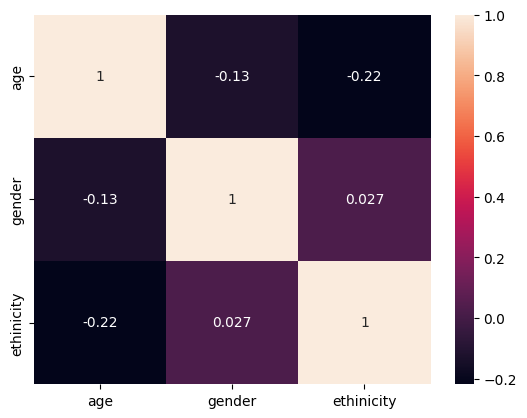

In [8]:
corr_df = data_df.drop("image", axis = 1)
sns.heatmap(corr_df.corr(), annot = True)

## Dataset Generation 1

In [9]:
# Creating dataframes
ages = list(data_df.age.unique())
ages = sorted(ages)

def dataframe(male_df, female_df, total_datapts = 5000, percent = 0.5, thresh = 50, old = "male"):
  MALE_POP = int(percent * total_datapts)
  FEMALE_POP = int((1-percent) * total_datapts)
  print(MALE_POP, FEMALE_POP)

  if old == "male":
    male_datapts = male_df[male_df["age"] > thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] < thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]



  else:
    male_datapts = male_df[male_df["age"] < thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] > thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]

  print(f"Male Population: {len(male_datapts)}/{len(male_datapts) + len(female_datapts)}; Female Population: {len(female_datapts)}/{len(male_datapts) + len(female_datapts)}")
  datapts = [male_datapts, female_datapts]
  datapts = pd.concat(datapts)
  datapts = datapts.sample(frac=1).reset_index(drop=True)
  return datapts

2500 2500
5574 2404
Male Population: 2500/5000; Female Population: 2500/5000


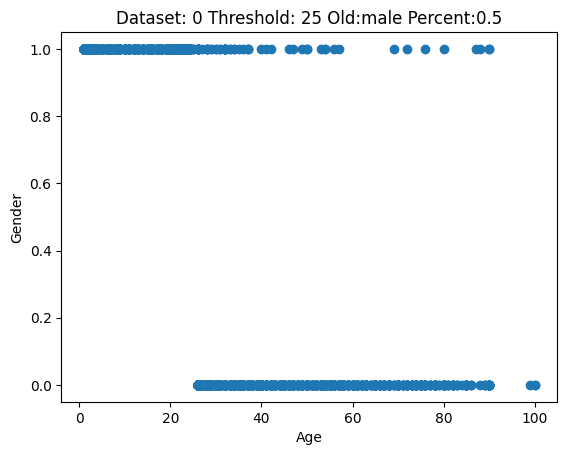

2500 2500
1263 5188
Male Population: 2500/5000; Female Population: 2500/5000


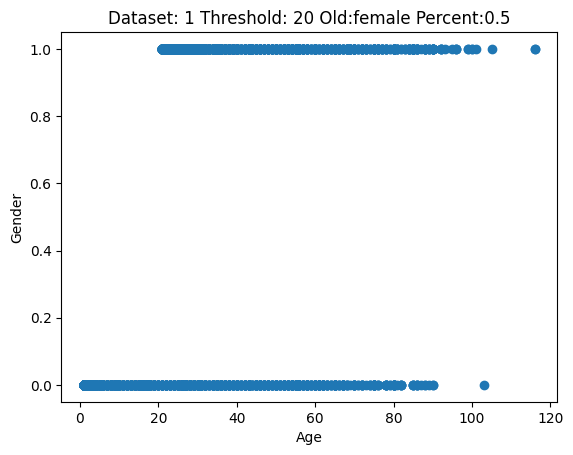

2500 2500
5893 1883
Male Population: 2500/5000; Female Population: 2500/5000


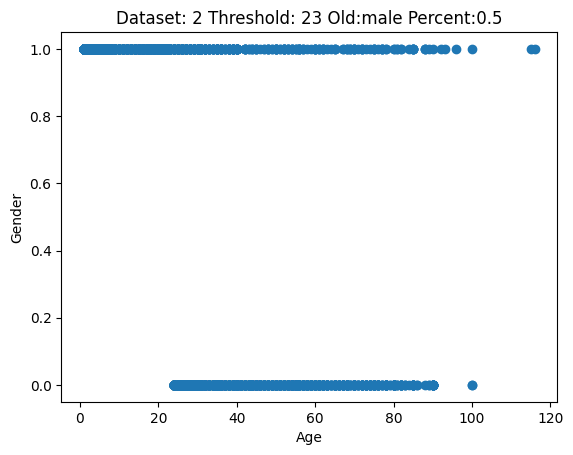

3500 1500
1471 4721
Male Population: 3500/5000; Female Population: 1500/5000


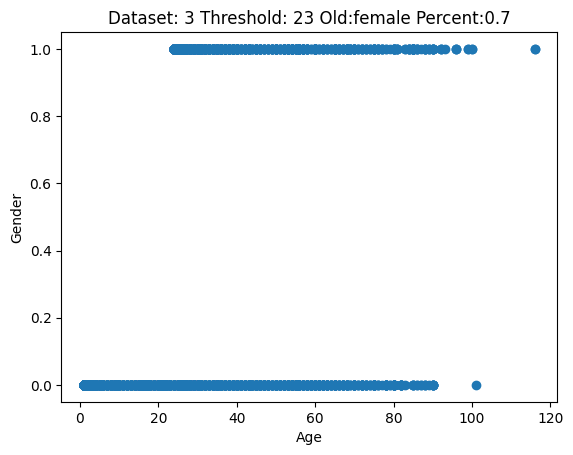

4000 999
5574 2404
Male Population: 4000/4999; Female Population: 999/4999


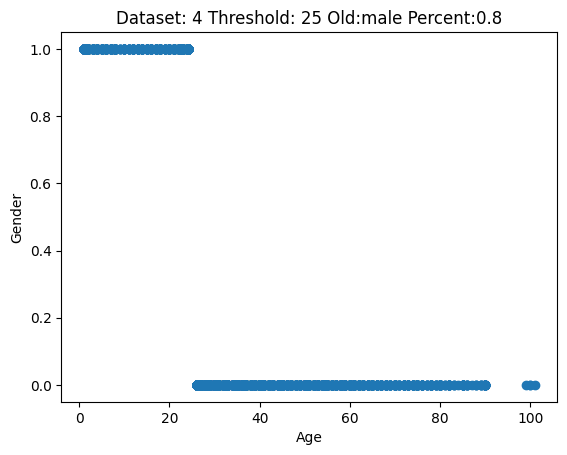

1000 4000
2453 3171
Male Population: 1000/5000; Female Population: 4000/5000


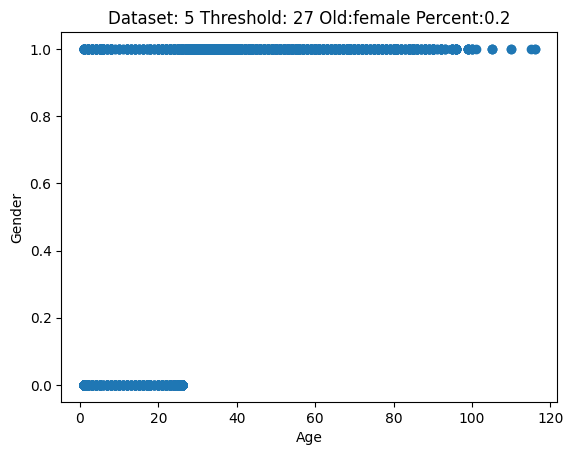

1500 3500
2874 5212
Male Population: 1500/5000; Female Population: 3500/5000


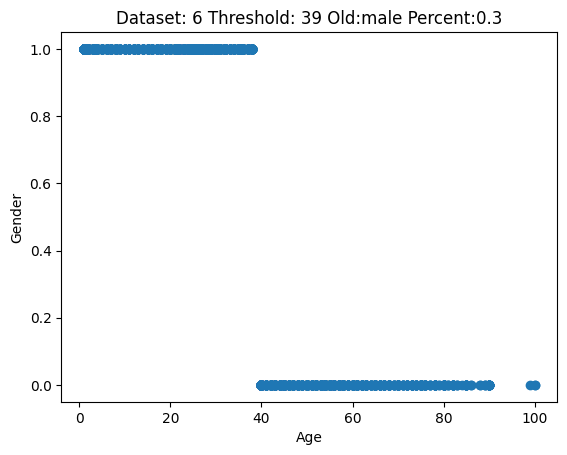

2500 2500
4838 1294
Male Population: 2500/5000; Female Population: 2500/5000


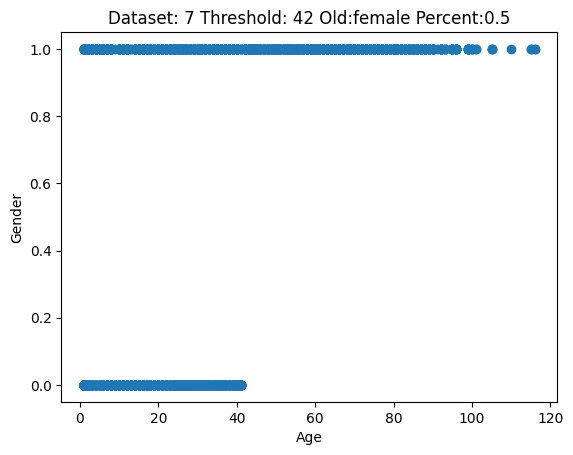

4000 999
2503 5426
Male Population: 4000/4999; Female Population: 999/4999


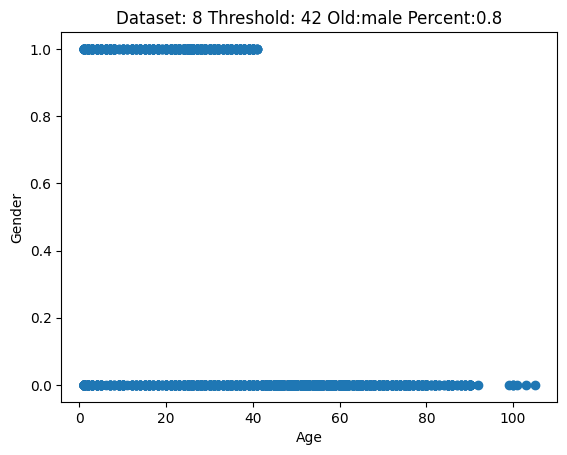

2000 3000
3103 2505
Male Population: 2000/5000; Female Population: 3000/5000


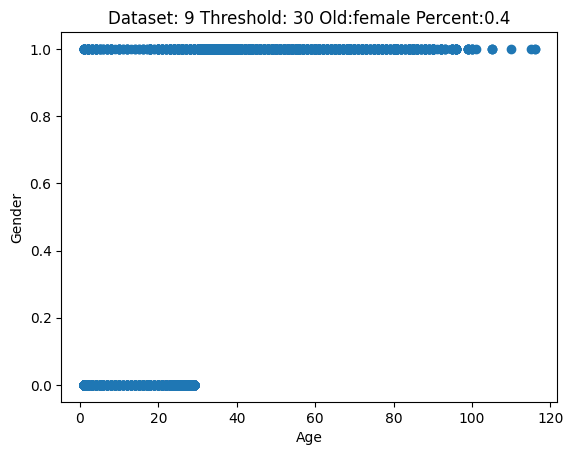

In [10]:
#Creating Datasets using Gen1 Dataframe
threshs = [25, 20, 23, 23, 25, 27, 39, 42, 42, 30]
olds = ["male", "female", "male", "female", "male", "female", 'male', 'female', 'male', 'female']
percents = [0.5, 0.5, 0.5, 0.7, 0.8, 0.2, 0.3, 0.5, 0.8, 0.4]
dfs = []

for i in range(len(threshs)):
    df = dataframe(male_df, female_df, thresh=threshs[i], old=olds[i], percent=percents[i])
    df.to_csv(f"./Datasets/Gen1/train_df{i}.csv")
    dfs.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Threshold: {threshs[i]} Old:{olds[i]} Percent:{percents[i]}")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.savefig(f"./Datasets/Gen1/Dataset{i}.png")
    plt.show()

## Dataset Generation 2

In [11]:
#Creating Dataframes using normal distribution
def dataframe_gen2(male_df, female_df, percent, male_mean, female_mean, male_var, female_var, total_datapts=5000):
    MALE_POP = int(percent * total_datapts)
    FEMALE_POP = int((1-percent) * total_datapts)
    print(MALE_POP, FEMALE_POP)

    male_age = np.sort(male_df.age)
    male_fx = np.exp(-1*(male_age - male_mean)**2 / (2*male_var)) / np.sqrt(2*np.pi*male_var)
    male_sample_probs = male_fx 

    female_age = np.sort(female_df.age)
    female_fx = np.exp(-1*(female_age - female_mean)**2 / (2*female_var)) / np.sqrt(2*np.pi*female_var)
    female_sample_probs = female_fx

    female_df_sorted = female_df.sort_values("age")
    male_df_sorted = male_df.sort_values("age")
    female_datapts = female_df_sorted.sample(n=FEMALE_POP, weights=female_sample_probs, replace=False)
    male_datapts = male_df_sorted.sample(n=MALE_POP, weights=male_sample_probs, replace=False)

    df = [male_datapts, female_datapts]
    df = pd.concat(df)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

3000 2000
24.582666666666668
44.048
image         5000
age             64
gender           2
ethinicity       5
dtype: int64


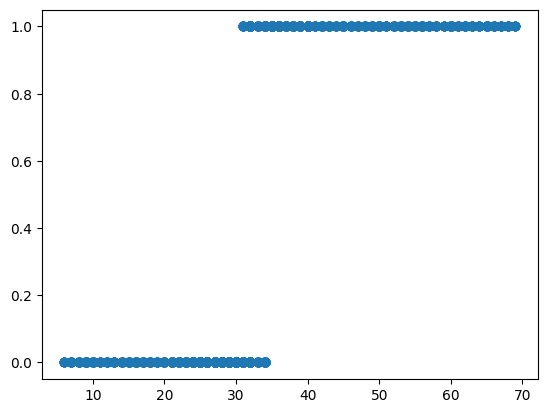

In [12]:
# Testing Dataset Gen2
dataset_1 = dataframe_gen2(male_df, female_df, percent=0.6, male_mean=20, female_mean=50, male_var=1, female_var=1)
dataset_1_male = dataset_1[dataset_1["gender"]==0]
dataset_1_female = dataset_1[dataset_1["gender"]==1]
print(dataset_1_male.age.values.mean())
print(dataset_1_female.age.values.mean())

print(dataset_1.nunique())
plt.scatter(dataset_1.age.values, dataset_1.gender.values)
plt.show()

4000 999


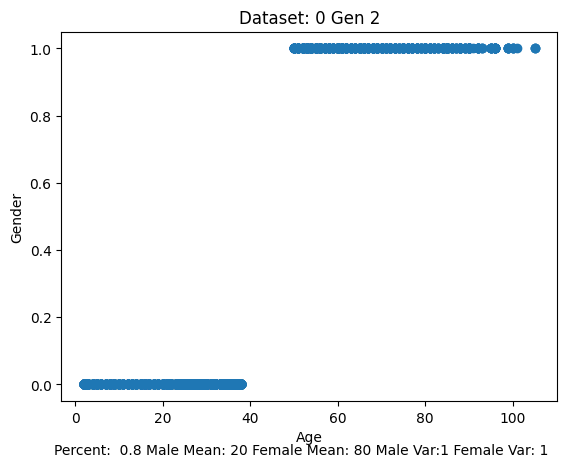

2500 2500


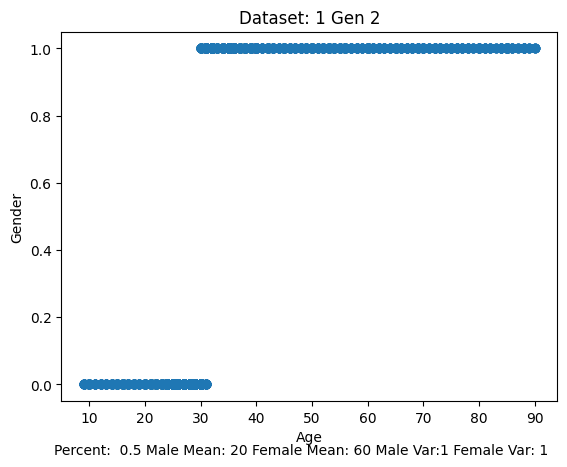

3000 2000


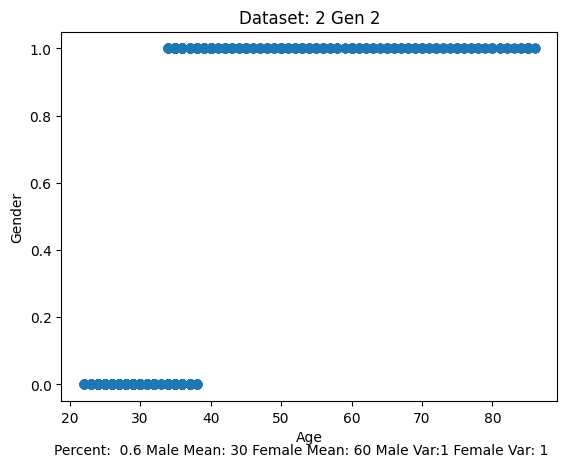

2500 2500


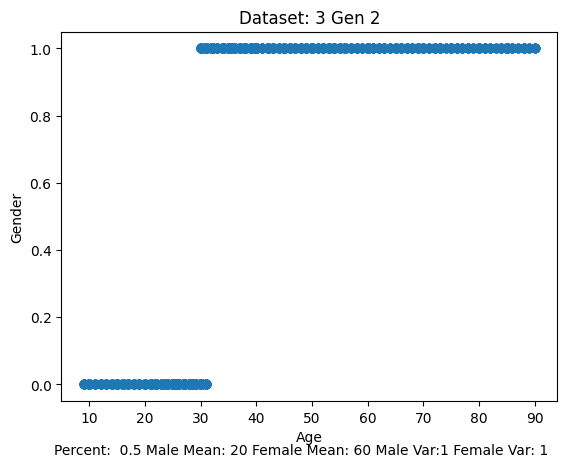

2000 3000


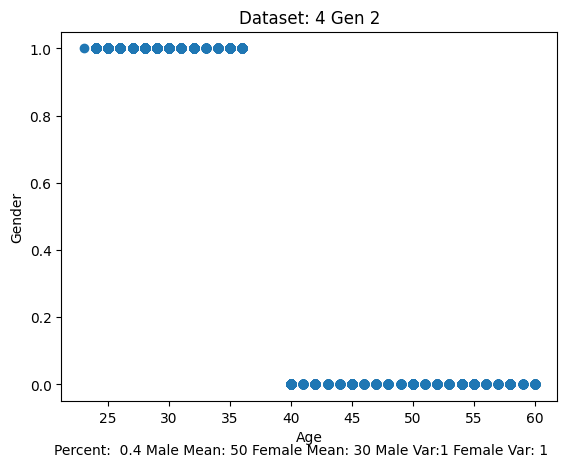

2000 3000


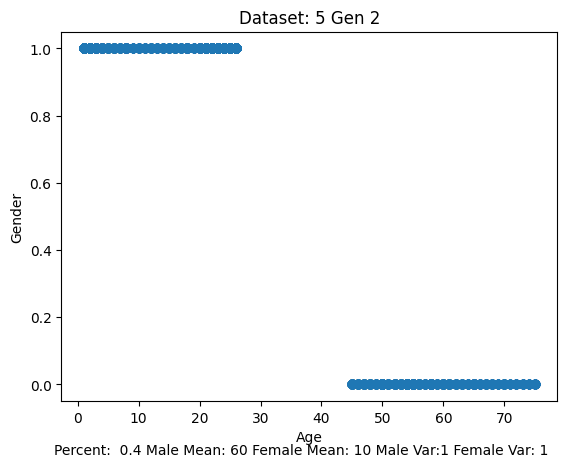

4000 999


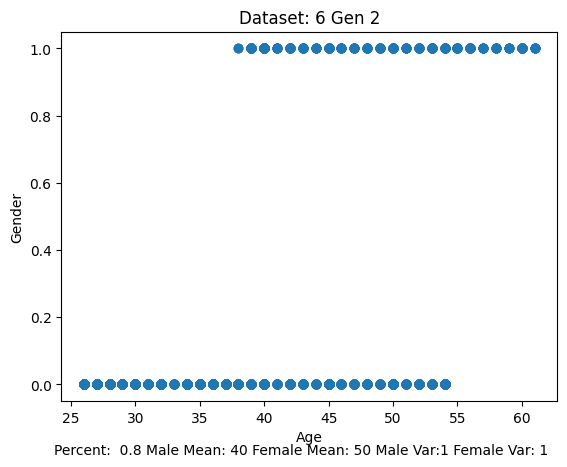

4000 999


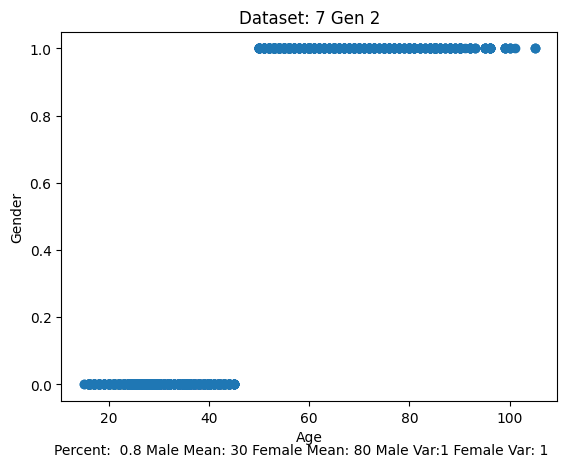

1000 4000


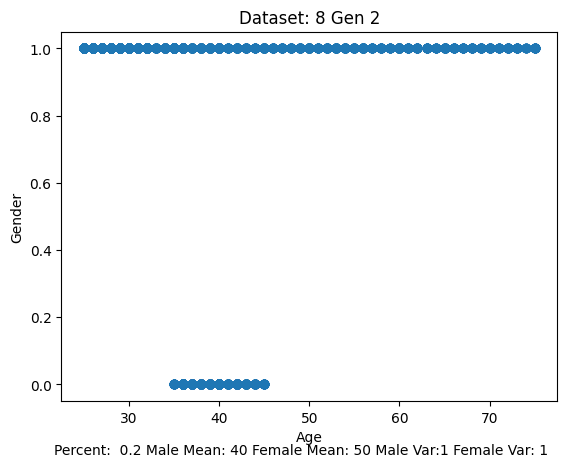

3000 2000


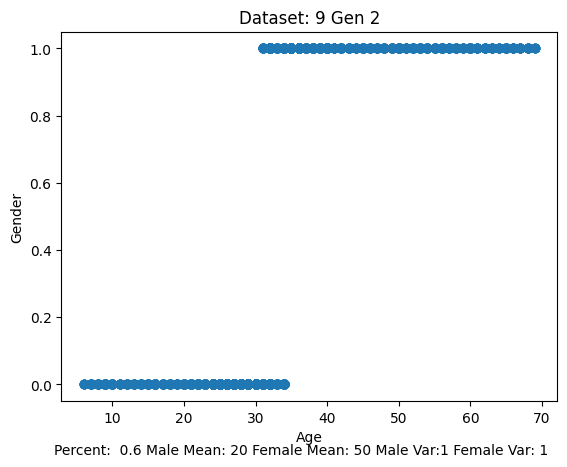

In [13]:
#Creating Dataframes using Gen2
percents = [0.8, 0.5, 0.6, 0.5, 0.4, 0.4, 0.8, 0.8, 0.2, 0.6]
male_means = [20, 20, 30, 20, 50, 60, 40, 30, 40, 20]
female_means = [80, 60, 60, 60, 30, 10, 50, 80, 50, 50]
male_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
female_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

dfs_gen2 = []
for i in range(len(percents)):
    df = dataframe_gen2(male_df, female_df, percent=percents[i], male_mean=male_means[i], female_mean=female_means[i], male_var=male_vars[i], female_var=female_vars[i])
    df.to_csv(f"./Datasets/Gen2/train_df{i}.csv", index = False)
    dfs_gen2.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Gen 2")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.figtext(0.5, 0.0001, f"Percent:  {percents[i]} Male Mean: {male_means[i]} Female Mean: {female_means[i]} Male Var:{male_vars[i]} Female Var: {female_vars[i]}", wrap=True, horizontalalignment='center', fontsize=10)
    plt.savefig(f"./Datasets/Gen2/Dataset{i}.png")
    plt.show()

## Datasets and Dataloaders

In [14]:
## acquiring the datasets
dfs_gen2 = []
for i in range(10):
    dfs_gen2.append(pd.read_csv(f"./Datasets/Gen2/train_df{i}.csv"))

In [15]:
# Datasets and Dataloaders
##Datasets
NUM_TRAIN_DATASETS = len(dfs_gen2)
BATCH_SIZE = 128

custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

test_dataset = UTKFaceDataset(dataframe = test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

val_dataset = UTKFaceDataset(dataframe = val_df,
                             image_dir = DIR_PATH,
                             transform = custom_transform)

TEST_SIZE = len(test_dataset)

train_datasets = []
train_dataloaders = []
for i in range(NUM_TRAIN_DATASETS):
  train_dataset = UTKFaceDataset(dataframe = dfs_gen2[i],
                                 image_dir= DIR_PATH,
                                 transform = custom_transform)

  train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

  train_dataloaders.append(train_dataloader)
  train_datasets.append(train_dataset)

##Dataloaders
test_dataloader = DataLoader(dataset = test_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True)

In [16]:
# Training Dataset and Dataloader
comp_train_dataset = UTKFaceDataset(dataframe=train_df,
                                   image_dir = DIR_PATH,
                                   transform = custom_transform)
comp_train_dataloader = DataLoader(dataset = comp_train_dataset,
                                   batch_size = BATCH_SIZE,
                                  shuffle = True)

## Dataset Visualization

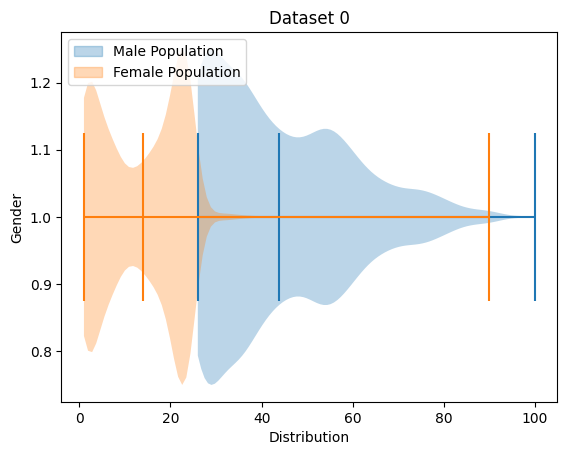

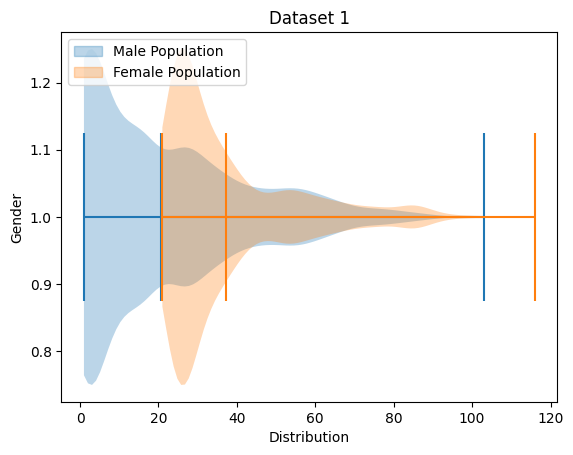

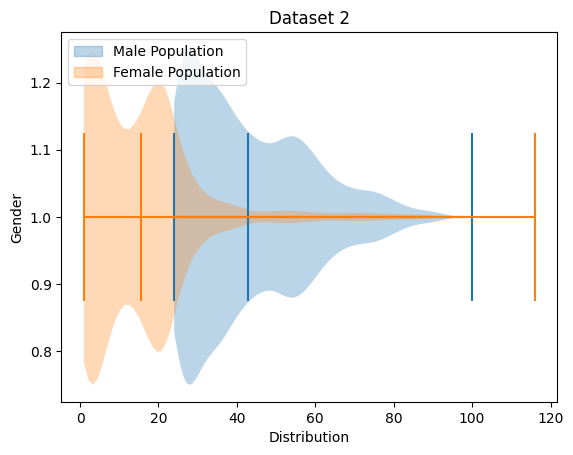

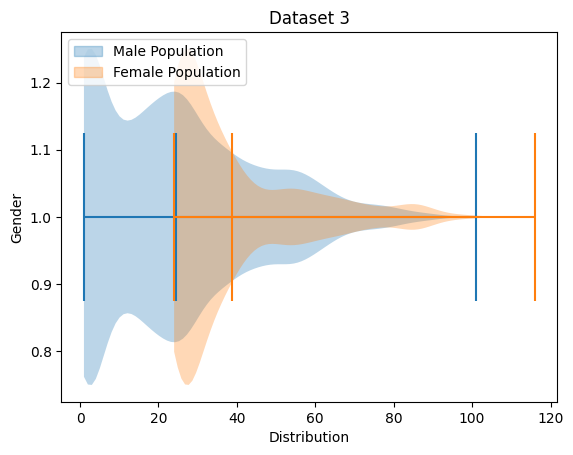

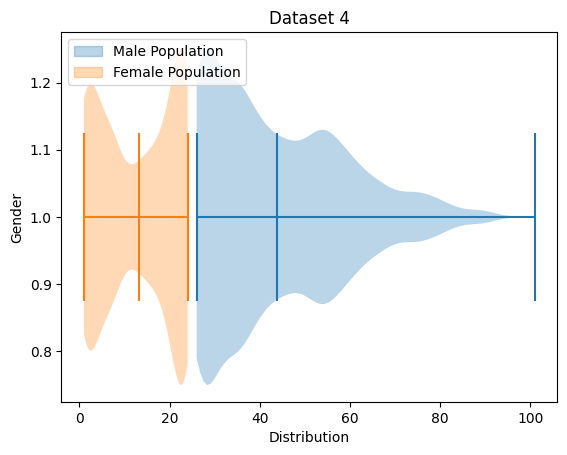

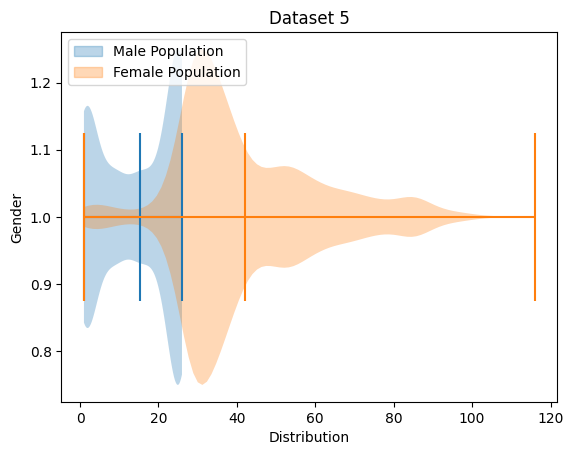

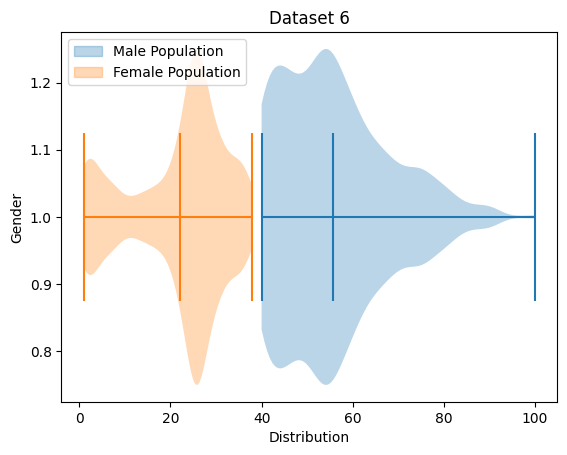

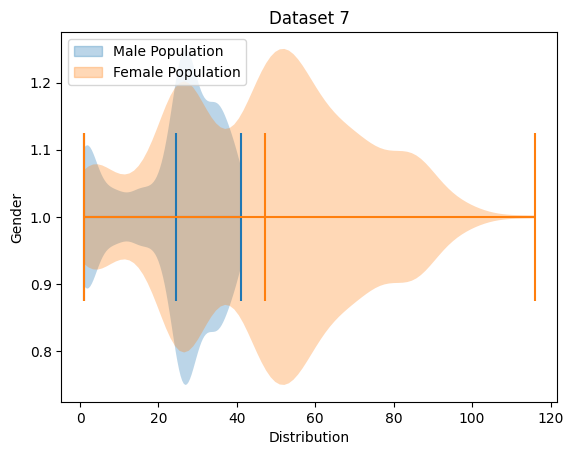

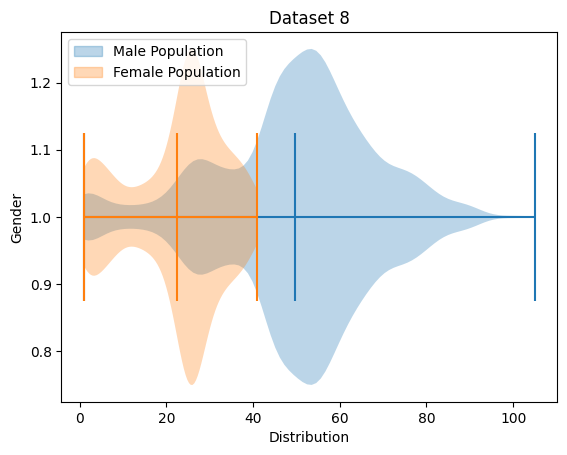

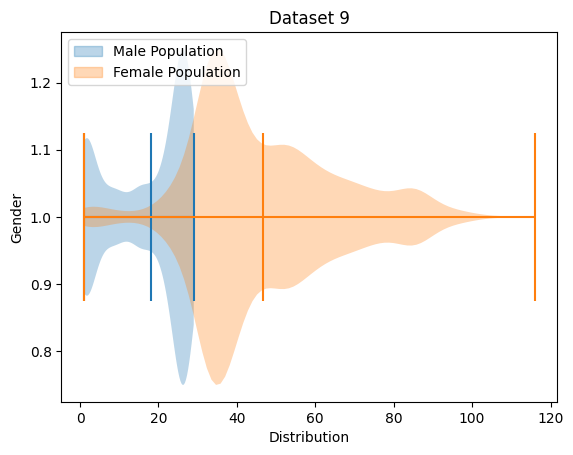

In [17]:
## Dataset Gen1 
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color = color), label))

for i in range(len(dfs)):
    labels  = []
    df = dfs[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Population")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen1/dataset_dist{i}.png")
    plt.show()

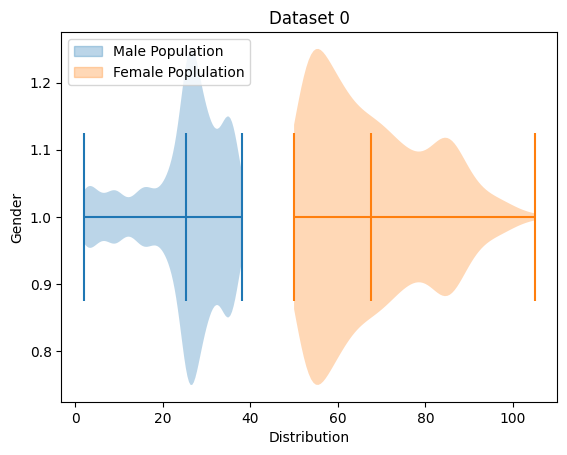

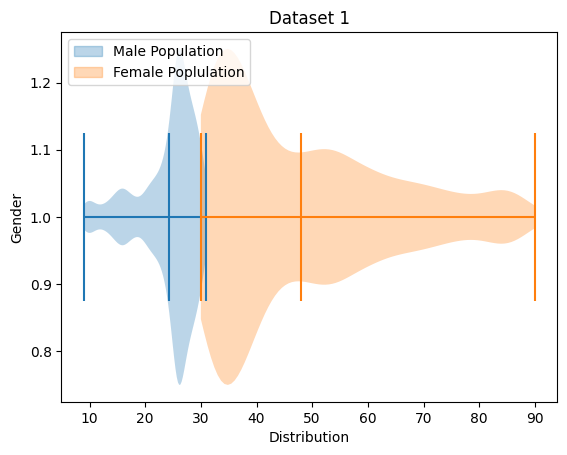

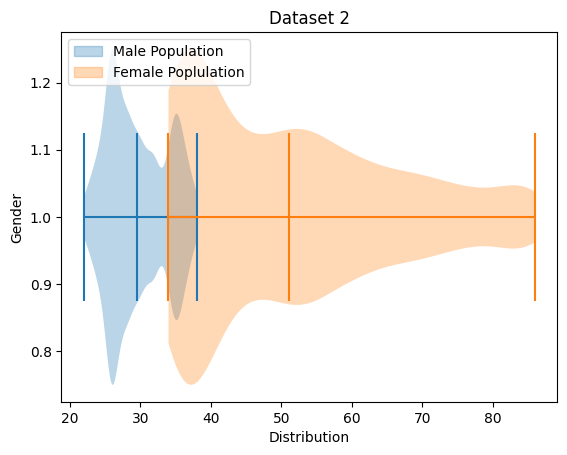

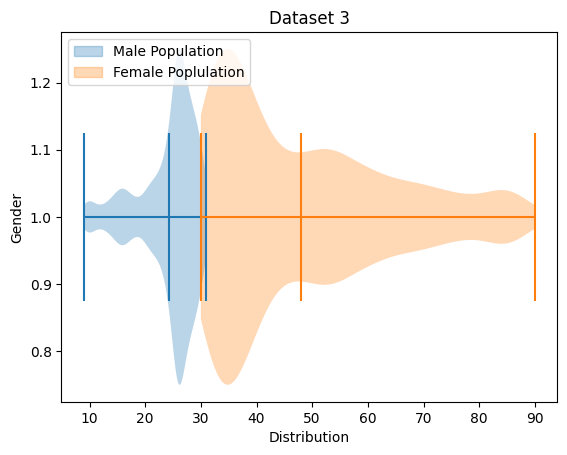

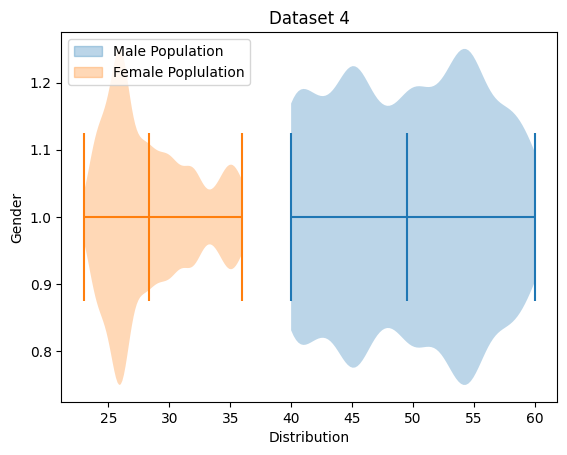

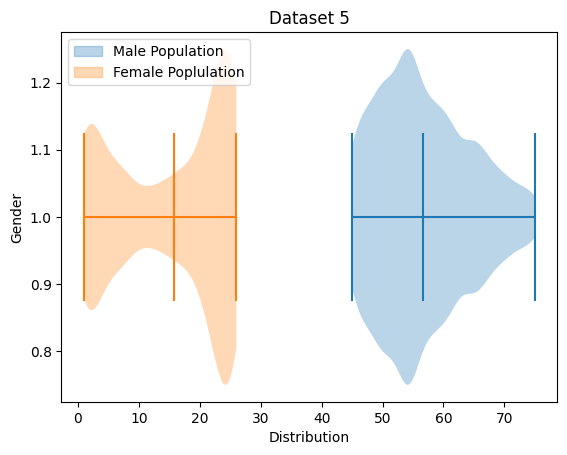

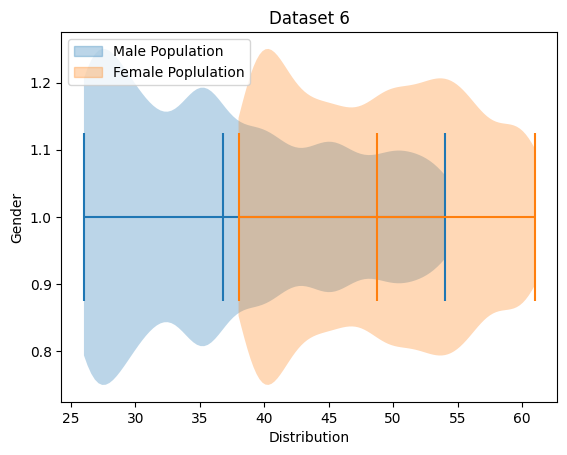

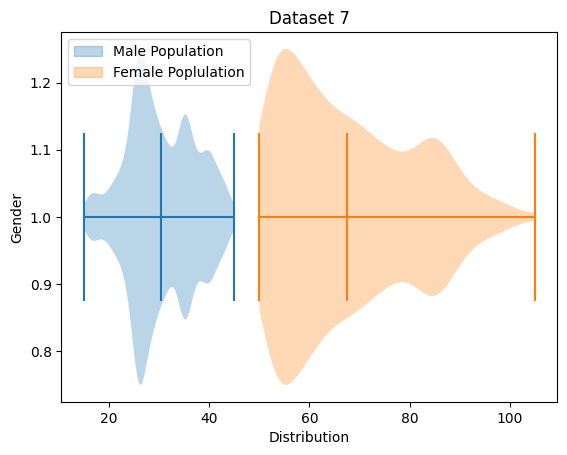

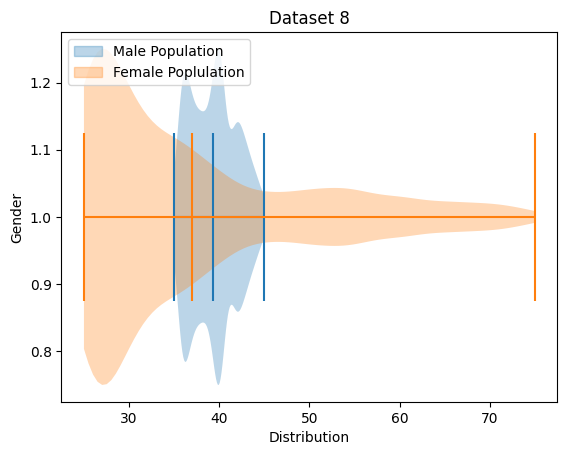

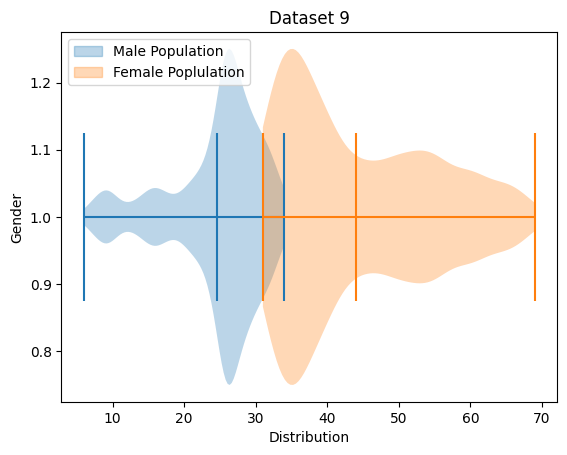

In [18]:
# Dataset Gen 2
for i in range(len(dfs_gen2)):
    labels = []
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    add_label(plt.violinplot(male_df.age, vert = False, showmeans = True), "Male Population")
    add_label(plt.violinplot(female_df.age, vert = False, showmeans = True), "Female Poplulation")
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.legend(*zip(*labels), loc = 2)
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/Gen2/dataset_dist{i}.png")
    plt.show()

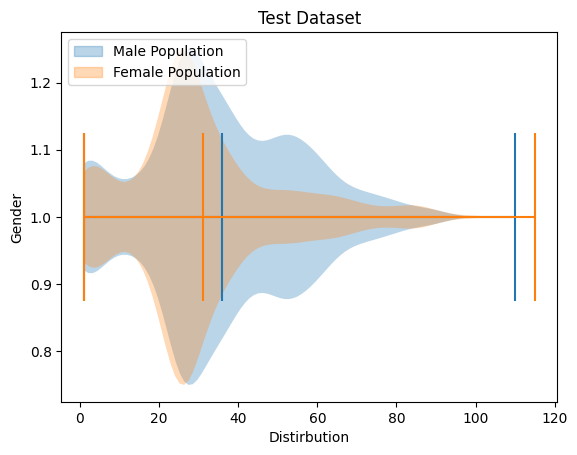

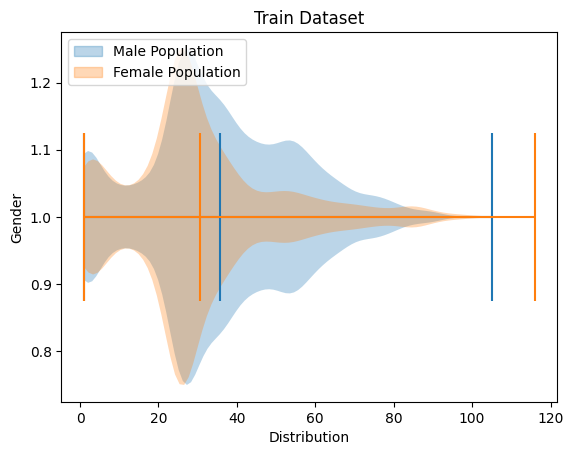

In [19]:
#Plotting distribution of test dataset
labels = []
male_test_df = test_df[test_df.gender == 0].age.values
female_test_df = test_df[test_df.gender == 1].age.values
add_label(plt.violinplot(male_test_df, vert = False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_test_df, vert = False, showmeans = True), "Female Population")
plt.xlabel("Distirbution")
plt.ylabel("Gender")
plt.title("Test Dataset")
plt.legend(*zip(*labels), loc = 2)
plt.savefig("./Datasets/test_distribution.png")
plt.show()

labels = []
male_train_df = train_df[train_df.gender == 0].age.values
female_train_df = train_df[train_df.gender == 1].age.values
add_label(plt.violinplot(male_train_df, vert=False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_train_df, vert = False, showmeans= True), "Female Population")
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.legend(*zip(*labels), loc = 2)
plt.title("Train Dataset")
plt.savefig("./Datasets/train_distribution.png")
plt.show()

## Models on Dataset without Bias

Length of the Train Dataset with no bias: 5000


/tmp/ipykernel_1104354/160073186.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
/tmp/ipykernel_1104354/160073186.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_train_df_nb = train_df_nb[train_df.gender == 1].age.values


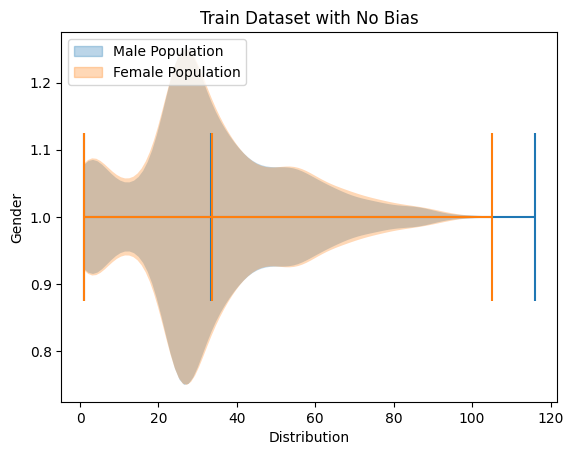

In [20]:
train_df_nb = train_df.sample(n=5000).reset_index(drop = True)
no_bias_dataset = UTKFaceDataset(dataframe = train_df_nb,
                                image_dir = DIR_PATH,
                                transform = custom_transform)

print(f"Length of the Train Dataset with no bias: {len(no_bias_dataset)}")

no_bias_dataloader = DataLoader(dataset = no_bias_dataset,
                               shuffle = True,
                               batch_size = BATCH_SIZE)

labels = []
male_train_df_nb = train_df_nb[train_df.gender == 0].age.values
female_train_df_nb = train_df_nb[train_df.gender == 1].age.values
add_label(plt.violinplot(male_train_df_nb, vert=False, showmeans = True), "Male Population")
add_label(plt.violinplot(female_train_df_nb, vert = False, showmeans= True), "Female Population")
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.title("Train Dataset with No Bias")
plt.legend(*zip(*labels), loc = 2)
plt.savefig("./Datasets/Train_Dataset_no_bias.png")
plt.show()

## Bias analysis of Different datasets

In [21]:
## KL Divergence between different training and full training datasets
def prob_gen(df, column = 'age'):
    values = df[column]
    count, division = np.histogram(values, bins = max(ages), range = (min(ages), max(ages)))
    count += 1
    probs = count / count.sum()
    return probs
    
def KLDivergence(df1, df2):
    prob1 = prob_gen(df1)
    prob2 = prob_gen(df2)

    return sum(prob1[i]*np.log(prob1[i] / prob2[i]) for i in range(len(prob1)))

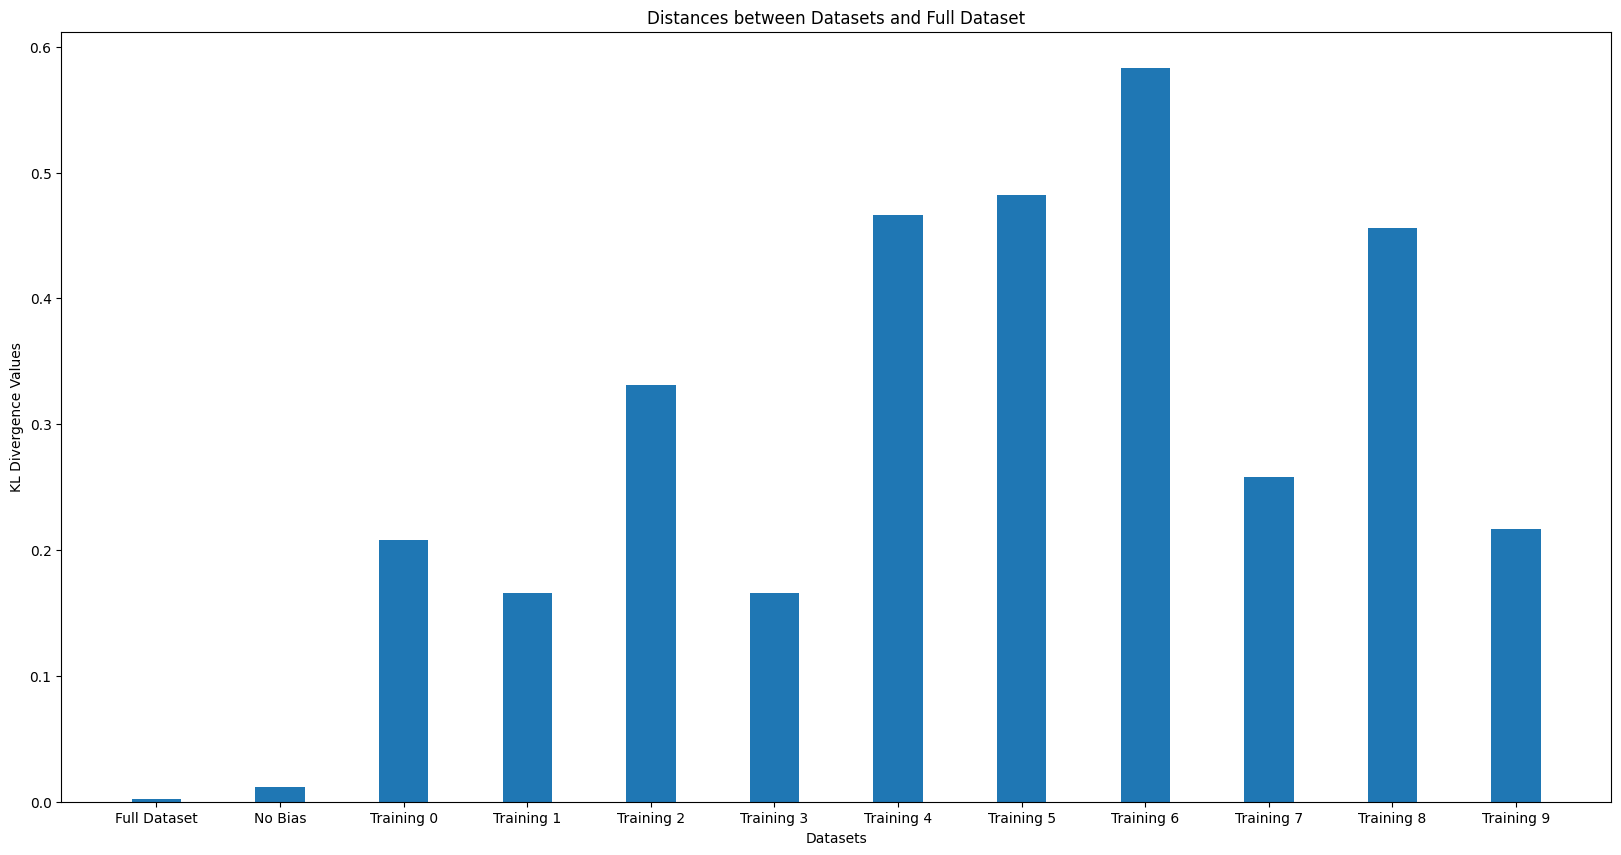

In [22]:
dist_distances = []
datasets = [f"Training {i}" for i in range(len(dfs_gen2))]
datasets.insert(0, "Full Dataset")
datasets.insert(1, "No Bias")

dist_full = KLDivergence(train_df, data_df)
dist_nb = KLDivergence(train_df_nb, data_df)
dist_distances.append(dist_full)
dist_distances.append(dist_nb)

for df in dfs_gen2:
    dist_distance = KLDivergence(df, data_df)
    dist_distances.append(dist_distance)
    
plt.figure(figsize = (20, 10))
plt.rcParams.update({"font.size":10})
plt.bar(datasets, dist_distances, width = 0.4)
plt.xlabel("Datasets")
plt.ylabel("KL Divergence Values")
plt.title("Distances between Datasets and Full Dataset")
plt.show()

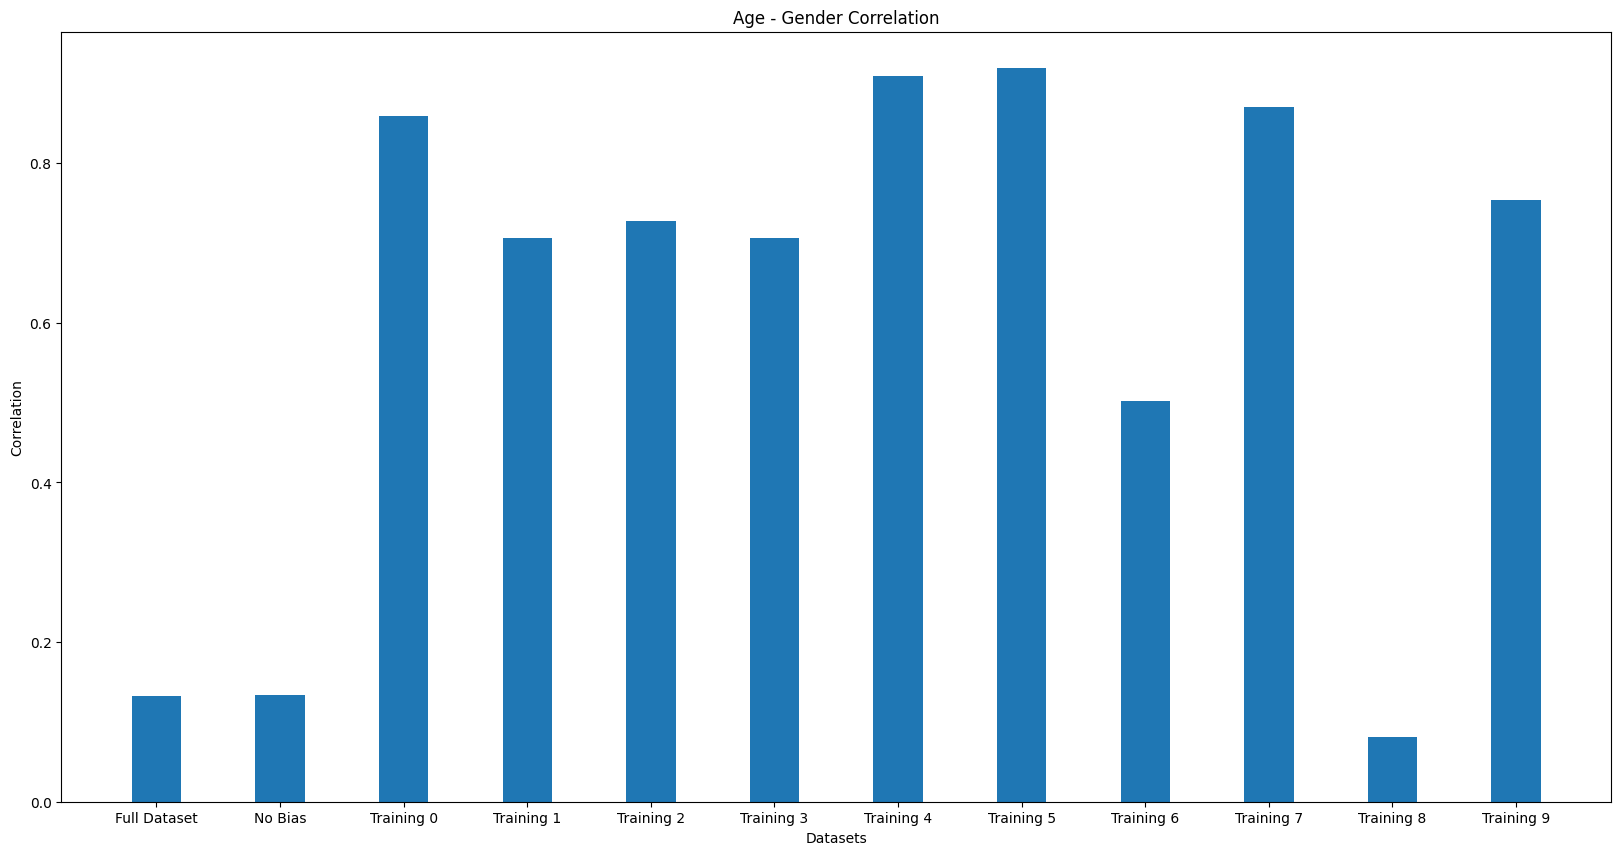

In [23]:
## plotting correlation values between age and gender
corr_values = []
corr_full = train_df.corr(numeric_only = True).loc['age', 'gender']
corr_values.append(corr_full)
corr_nb = train_df_nb.corr(numeric_only = True).loc['age', 'gender']
corr_values.append(corr_nb)

for df in dfs_gen2:
    corr = df.corr(numeric_only = True).loc['age', 'gender']
    corr_values.append(corr)

corr_values = np.array(corr_values)
corr_abs = np.abs(corr_values)
corr_sign = np.sign(corr_values)

plt.figure(figsize = (20, 10))
plt.rcParams.update({"font.size":10})
plt.bar(datasets, corr_abs, width = 0.4)
plt.xlabel("Datasets")
plt.ylabel('Correlation')
plt.title("Age - Gender Correlation")
plt.show()

### Correlation Analysis

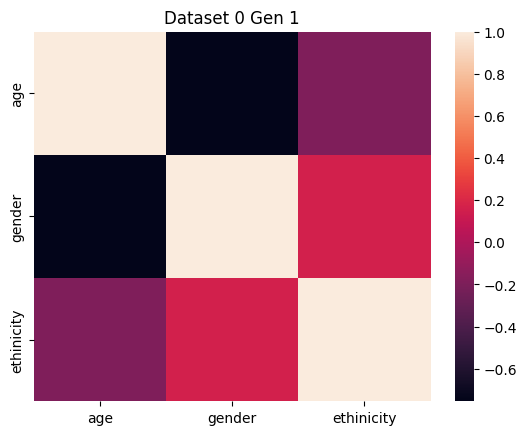

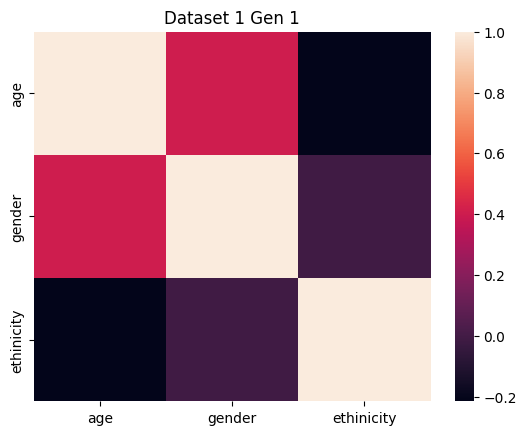

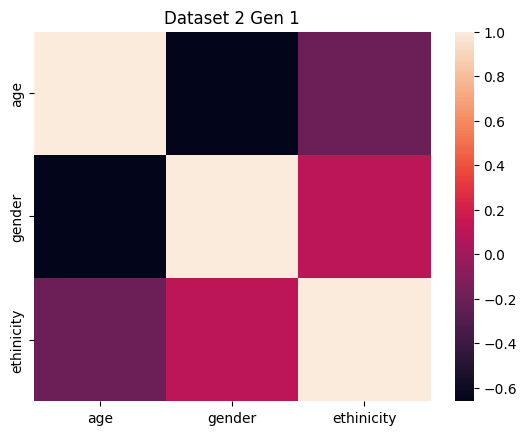

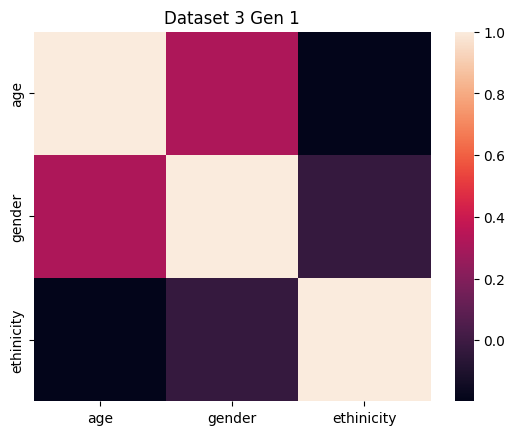

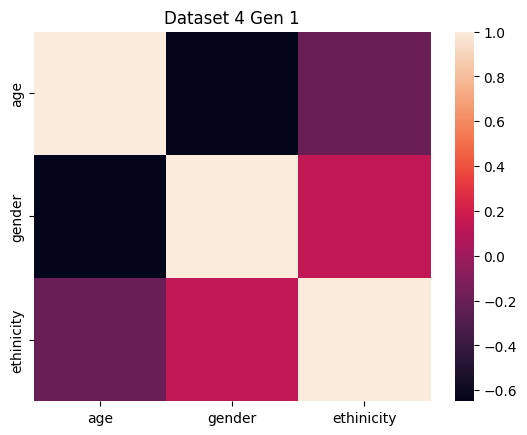

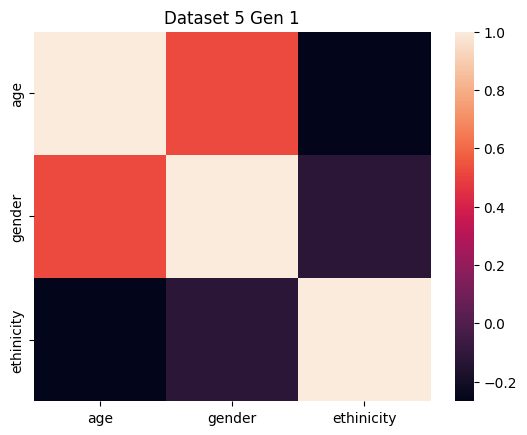

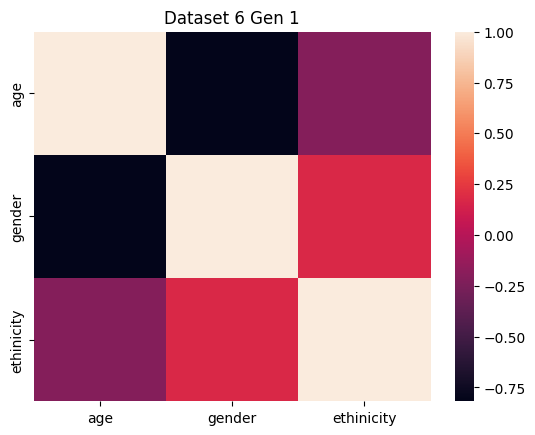

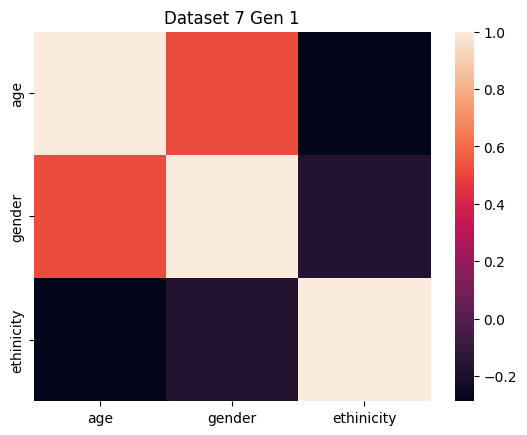

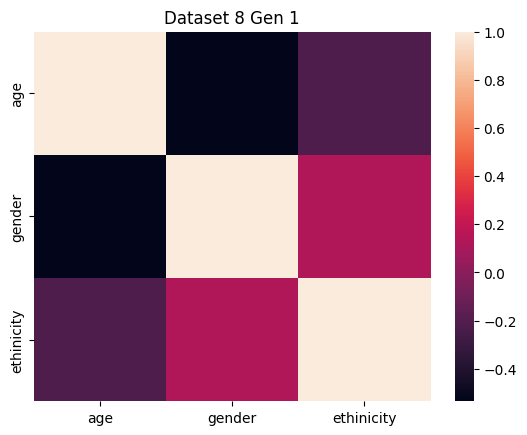

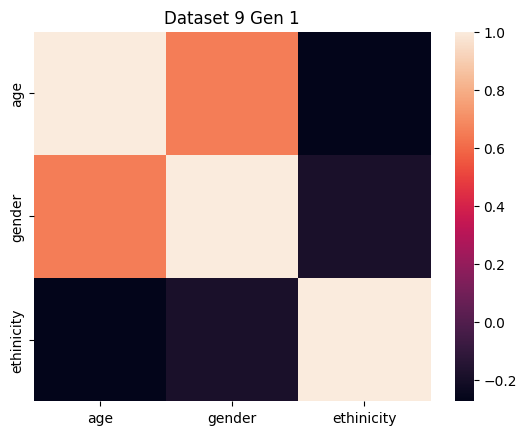

In [24]:
for i in range(len(dfs)):
    df = dfs[i]
    sns_plot = sns.heatmap(df.drop("image", axis = 1).corr()).set(title = f"Dataset {i} Gen 1")
    plt.savefig(f"./Datasets/Gen1/Correlations/Dataset{i}.png")
    plt.show()

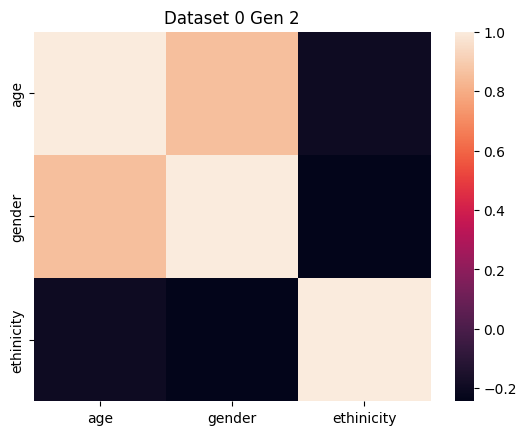

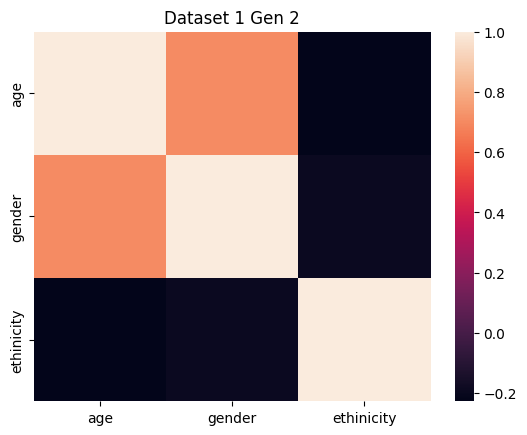

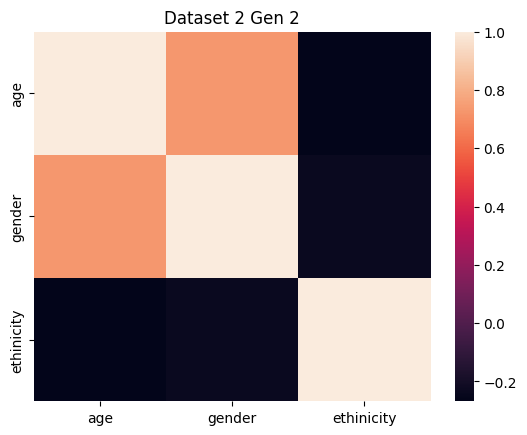

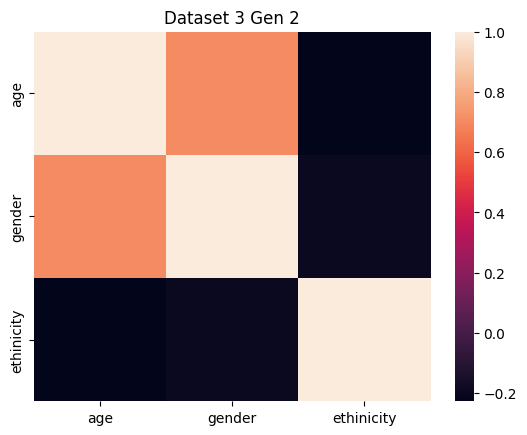

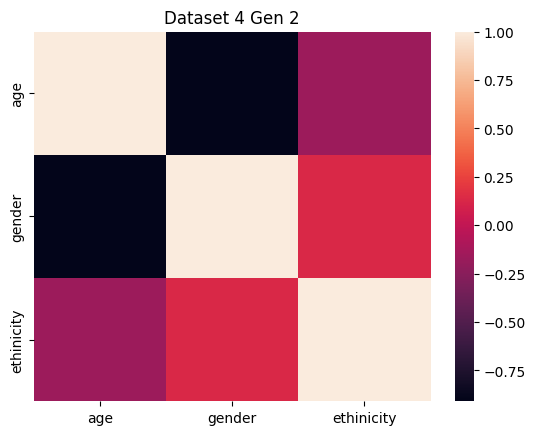

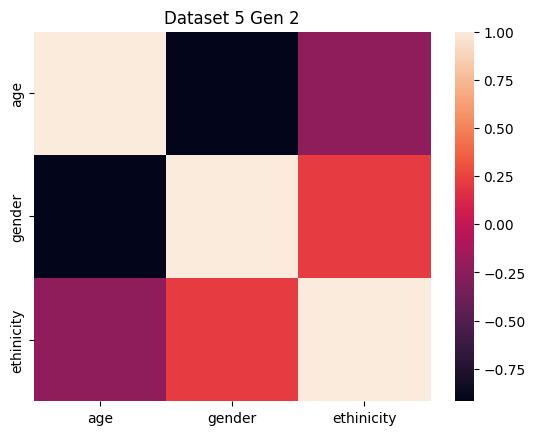

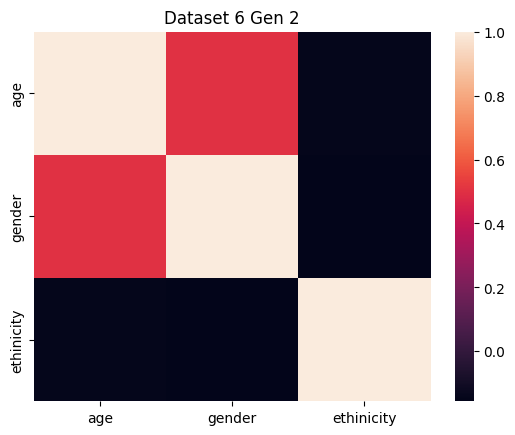

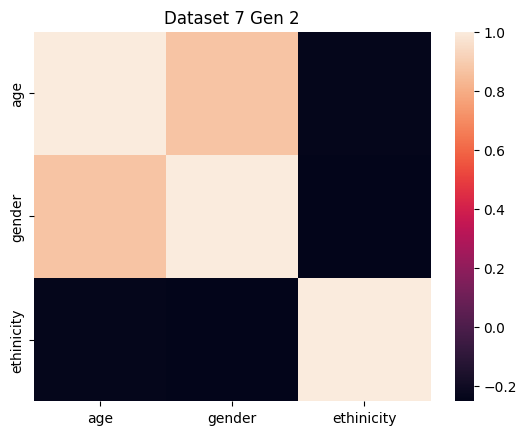

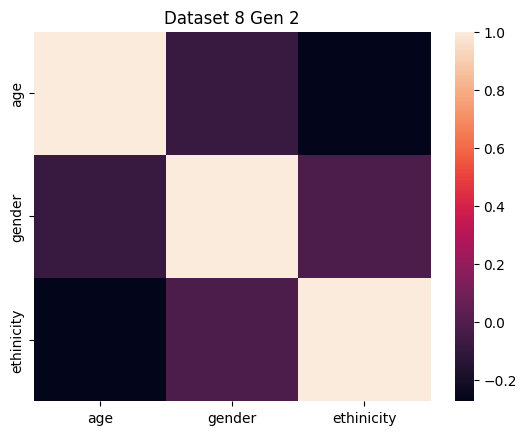

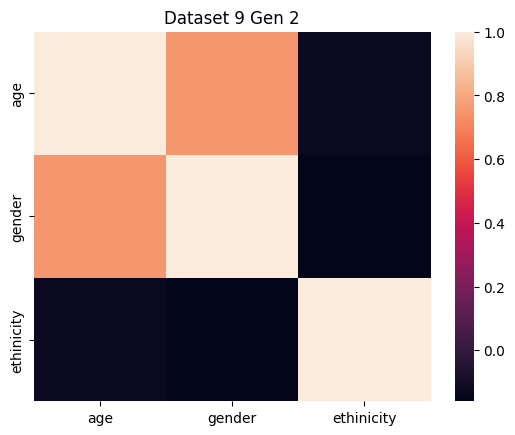

In [25]:
for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    sns_plot = sns.heatmap(df.drop("image", axis= 1).corr()).set(title = f"Dataset {i} Gen 2")
    plt.savefig(f"./Datasets/Gen2/Correlations/Dataset{i}.png")
    plt.show()

## Bayesian Loss Limit

Calculating the errors of a Bayesian Regression Model which just uses Gender make predictions

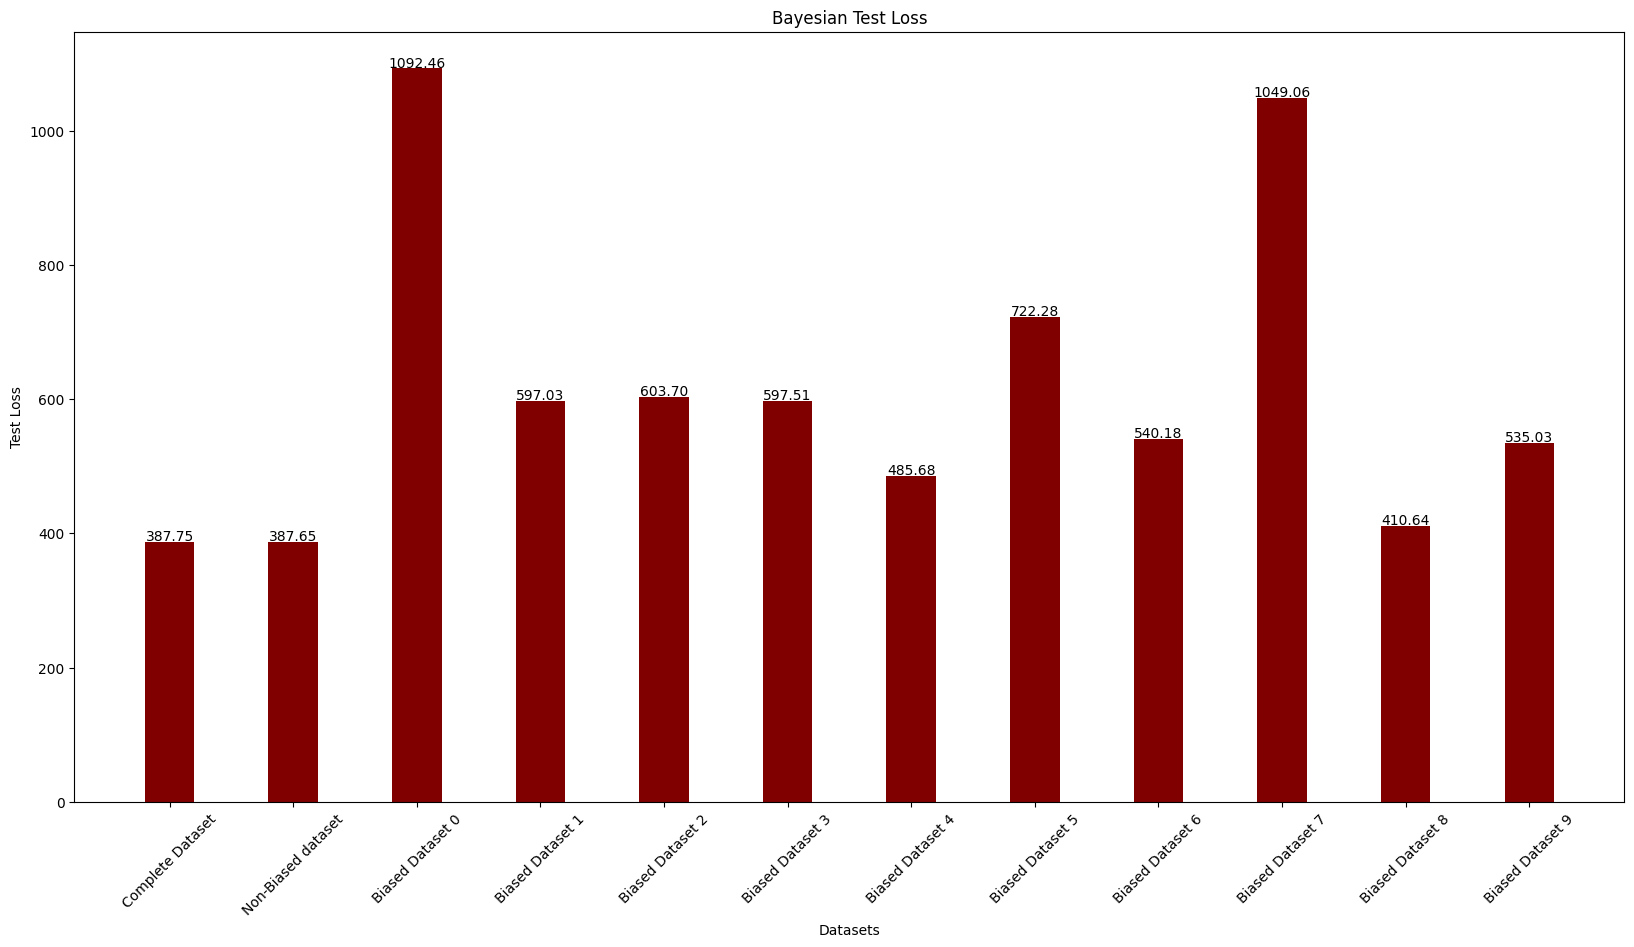

In [26]:
import sklearn
from sklearn import linear_model

df_bayesian = [train_df_nb] + dfs_gen2

test_losses_bayesian = []

for i in range(len(df_bayesian)):
    df = df_bayesian[i]
    
    x = df.gender.values
    x = x.reshape(-1,1)
    y = df.age.values

    #Bayesian Regression Model
    reg = linear_model.BayesianRidge()
    reg.fit(x, y)

    #Error Calculations
    x_test = test_df.gender.values
    x_test = x_test.reshape(-1,1)
    y_test = test_df.age.values

    y_pred = reg.predict(x_test)
    Loss = (np.square(y_test - y_pred)).mean()
    test_losses_bayesian.append(Loss)

    # print(f"Training Dataset{i}, Test Loss: {Loss}")

#Bayesian on full dataset
x,y = train_df.gender.values, train_df.age.values
x = x.reshape(-1,1)
reg = linear_model.BayesianRidge()
reg.fit(x, y)

y_pred=reg.predict(x_test)
full_loss = (np.square(y_test - y_pred)).mean()
# print("Full Trainig Dataset: {}".format(full_loss))
test_losses_bayesian.insert(0, full_loss)

#plotting the test loss of bayesian model in different datasets
x_values = ["Complete Dataset", 'Non-Biased dataset'] + [f"Biased Dataset {i}" for i in range(len(dfs_gen2))]

fig, ax = plt.subplots(figsize = (20, 10))

# Create the bar plot
ax.bar(x_values, test_losses_bayesian, color ='maroon', width = 0.4)
# Set the title and labels
ax.set_title("Bayesian Test Loss")
ax.set_xlabel('Datasets')
ax.set_ylabel('Test Loss')

# Display the values on top of the bars
for i, v in enumerate(test_losses_bayesian):
    ax.text(i, v + 2 if v> 0 else v-5, '{:.2f}'.format(v), color='black', ha='center')

plt.xticks(rotation = 45)
plt.savefig("./Outputs/Bayesian_losses.png")
plt.show()

## CNN Model - Resnet34 Architecture

In [27]:
# ResNet 34 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        super(ResNet, self).__init__()
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

## ResNet 34 model
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [28]:
## Model and Hyperparameters
model = resnet34(1, False).to(device) 

In [29]:
#Training the model
def train(model, train_dataloader, val_dataloader, lr = 0.0005, weight_decay = 0, epochs = 200, verbose = False):
  if verbose:
    print("Training the Model........")

  optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  losses = []
  val_losses = []
  model.train()

  for epoch in tqdm(range(epochs)):
    tloss = 0
    loss_num = 0

    for batch_idx, data in enumerate(train_dataloader):
      x, y, _ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      optimizer.zero_grad()
      out = model(x)
      loss = F.mse_loss(out, y)
      loss.backward()
      optimizer.step()

      tloss += loss.detach().cpu()
      loss_num += 1

    with torch.no_grad():
      vloss = 0
      vloss_num = 0

      for batch_idx, data in enumerate(val_dataloader):
        x,y,_ = data
        x = x.to(torch.float32).to(device)
        y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

        out = model(x)
        loss = F.mse_loss(out, y)

        vloss += loss.detach().cpu()
        vloss_num += 1

    if verbose:
      print(f"Epoch: {epoch}/{epochs} Training loss: {tloss / loss_num} Validation loss: {vloss / vloss_num}")

    losses.append(float(tloss / loss_num))
    val_losses.append(float(vloss / vloss_num))

  return model, losses, val_losses

# Evaluating the model
def eval_model(model, test_dataloader):
  test_loss = 0
  test_loss_num =0

  with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
      x,y,_ = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      out = model(x)
      loss = F.mse_loss(out, y, reduction = 'sum')
        
      test_loss_num += x.shape[0]
      test_loss += loss.detach().cpu()
        
  return float(test_loss / test_loss_num)

In [30]:
# Plotting the loss curves
epochs = 100
# Plotting function
def plot_loss_curves(train_losses, val_losses, test_loss, epochs, model_name = "resnet"):
    plt.plot(range(epochs), train_losses, color = 'blue', label = 'Training Loss')
    plt.plot(range(epochs), val_losses, color = 'red', label = 'Validation loss')
    plt.plot(range(epochs), [test_loss] * epochs, color = 'green', label = "Test Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} loss curves")
    plt.show()

In [ ]:
model, train_losses, val_losses = train(model, train_dataloader=train_dataloaders[0], val_dataloader=val_dataloader, verbose = False, epochs=100)
test_loss = eval_model(model, test_dataloader)

In [ ]:
#plotting
plot_loss_curves(train_losses, val_losses, test_loss, 100)

In [ ]:
pretrained_model, train_pretrained_loss, val_pretrained_loss = train(pretrained_model, train_dataloaders[0], val_dataloader, verbose = False, epochs = 100)
test_pretrained_loss = eval_model(model, test_dataloader)
plot_loss_curves(train_pretrained_loss, val_pretrained_loss, test_pretrained_loss, epochs = 100)

In [ ]:
full_model = Resnet34(1).to(device)
full_model, full_losses, full_vlosses = train(model, comp_train_dataloader, val_dataloader, epochs = 100, verbose = False)
full_test_loss = eval_model(model, test_dataloader)
torch.save(full_model.state_dict(), "./Models/full_model.pth")

In [ ]:
#plotting loss curves for the entire training dataset
plot_loss_curves(full_losses, full_vlosses, full_test_loss, epochs, model_name="Full Training Dataset")

In [ ]:
# Training models on different Training Datasets
tlosses = []
vlosses = []
tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = Resnet34(1).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100)
    test_loss = eval_model(model, test_dataloader)

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)

    # torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    # print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

In [ ]:
#plotting graphs:
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs, model_name=f"Training Dataset{i}")

## Feature Sieve Regression
### 1) Forgetting loss: Margin Loss

In [31]:
class Feature_Sieve_Margin(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Margin, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, 1)
        # self.aux_out = nn.Linear(128, 1)


        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([ self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        # aux = self.aux_out(aux)
        
        
        return logits, aux

def fs_margin(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Margin(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [32]:
fs_mar_model = fs_margin(1, False).to(device)

In [33]:
## Forget Loss: Margin Loss
def learn_main(model, optim_main, x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux(model, optim_main, optim_aux, x, y, alpha_aux = 1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * F.mse_loss(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux(model, optim_forget, x, y, margin):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    mse_loss = F.mse_loss(aux,y)
    thresh = torch.tensor(-margin).to(torch.float32).to(device)
    loss = torch.max(thresh, -mse_loss)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()
    return loss

In [34]:
def train_fs_mar(model, train_dataloader, val_dataloader, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training model...............")
        
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []

    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # training Part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                auxloss = learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux(model, optim_forget, x, y, margin)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                aux_losses.append(auxloss.detach().cpu())
                
                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch+1}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

def eval_FSModel(model, test_dataloader):
    tst_loss = 0
    test_nu = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_dataloader):
            x,y, _ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            out = model(x)[0]
            loss = F.mse_loss(out, y, reduction = 'sum')

            tst_loss += loss.detach().cpu()
            test_nu += x.shape[0]

    return float(tst_loss / test_nu)

In [ ]:
# Hyperparameter Tuning
margins = [2, 50, 100]
forget_lrs = [1e-5, 1e-4, 1e-3]
forget_iters = [2, 50, 100]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            model = fs_margin(1, False).to(device)
            model, train_loss, val_loss = train_fs_mar(model, train_dataloaders[0], val_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 10, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)

            test_losses[i,j,k] = test_loss

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmax(test_losses), test_losses.shape)
print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")

In [ ]:
# Training models on different Training Datasets
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = fs_margin(1, False).to(device)
    model, train_losses, val_losses, _ = train_fs_mar(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100, margin=best_margin, forget_iters=best_forget_iter, lrs=[5e-4, 5e-4, best_forget_lr])
    test_loss = eval_FSModel(model, test_dataloader)

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

### 2) Cross Entropy Forgetting Loss:

In [35]:
#Cross entropy model
class Feature_Sieve_CE(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_CE, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 128, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        x = self.layer1(sh)

        #forward of the main network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = F.softmax(self.aux_fc(aux), dim=-1)

        return logits, aux

def fs_ce(num_classes, num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_CE(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model
    

In [36]:
## Forgetting Loss: Cross Entropy
def learn_main_ce(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux_ce(FS, optim_main, optim_aux, x, y, bins, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    y = torch.bucketize(y,bins, right=True).reshape(-1) - 1
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()
    return loss

def forget_aux_ce(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()
    return loss

In [37]:
#Functions
def train_fs_ce(model, train_dataloader, val_dataloader, age, num_bins = 20, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=20, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training Model............")
        
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []

    bin_counts, bin_edges = np.histogram(age, bins = num_bins)
    bin_edges[-1] += 1
    bins = torch.tensor(bin_edges).to(torch.float32).to(device)
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        # Training part of the code
        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ce(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ce(model, optim_main, optim_aux, x, y, bins)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux_ce(model, optim_forget, x, num_bins)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        # Validation part of the code
        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

In [ ]:
#Training
epochs = 100
num_bins = 20
ages = data_df['age'].values

fs_ce_model = fs_ce(1, num_bins, False).to(device)
fs_ce_model, fs_ce_tloss, fs_ce_vloss ,_ = train_fs_ce(fs_ce_model, train_dataloaders[0], val_dataloader, ages, num_bins = num_bins, verbose = True)
fs_ce_test_loss = eval_FSModel(fs_ce_model, test_dataloader)

plot_loss_curves(fs_ce_tloss, fs_ce_vloss, fs_ce_test_loss, epochs = epochs, model_name = "Feature Sieve:Cross Entropy Forgetting Loss")

In [ ]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

num_bin = 20

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages,  num_bins=num_bin, forget_iters=forget_iters[i], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget Lr: {forget_lrs[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bin, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses=[]
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ce(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005, best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

In [ ]:
fs_ce_tloss = []
fs_ce_vloss = []
fs_ce_test_loss = []

best_num_bins = 3
best_forget_iters = 50 
best_forget_lr = 0.001

for i in range(len(train_dataloaders)):
    print(f"Training Dataset {i}")
    model = fs_ce(1, best_num_bins, False).to(device)
    model, fs_ce_loss, fs_ce_val_loss = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, num_bins = best_num_bins, forget_iters=best_forget_iters, lrs=[0.0005, 0.0005, best_forget_lr], verbose = False)
    fs_ce_tst_loss = eval_FSModel(model, test_dataloader)

    fs_ce_tloss.append(fs_ce_loss)
    fs_ce_vloss.append(fs_ce_val_loss)
    fs_ce_test_loss.append(fs_ce_tst_loss)

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Logged model into: ./Models/fs_ce_model{i}.pth")

### 3) Ordinal Forgetting Loss

In [38]:
# Ordinal Model
class Feature_Sieve_Ord(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Ord, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        
        return logits, aux

def fs_ord(num_classes,num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Ord(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model

In [78]:
# Multilabel Loss function
multi_label_loss = nn.BCEWithLogitsLoss()

def learn_main_ordinal(model, optim_main,x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord, alpha_aux=1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    # print(aux.shape, y_ord.shape, x.shape)
    loss = alpha_aux * multi_label_loss(aux, y_ord)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()
    return loss

def forget_aux_ordinal(model, optim_forget, x,y, num_bins):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    aux_preds = torch.sum(F.sigmoid(aux), dim =-1) * 116 / num_bins
    loss = F.mse_loss(aux_preds.reshape(-1,1), y)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()
    return loss

In [79]:
#Functions
def train_fs_ord(model, train_dataloader, val_dataloader, num_bins=20, epochs = 100, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    train_losses= []
    val_losses = []
    aux_losses = []
    forget_losses = []
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y,_ = data
            y_ord = y.reshape(-1).numpy()
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            #Ordinal label generation
            y_ord = np.greater_equal.outer(y_ord, np.arange(num_bins)*116/num_bins).astype(float)
            y_ord = torch.tensor(y_ord).reshape(y_ord.shape[0], -1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ordinal(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                aux_loss = learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord)
            if forget_iters and steps % forget_iters == 0:
                forget_loss = forget_aux_ordinal(model, optim_forget, x, y, num_bins)
                forget_losses.append(forget_loss.detach().cpu())

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

            aux_losses.append(aux_loss.detach().cpu())

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y, _ = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses, aux_losses, forget_losses

In [ ]:
fs_ord_model = fs_ord(1, 20, False).to(device)
fs_ord_model, fs_ord_tloss, fs_ord_vloss,_ = train_fs_ord(fs_ord_model, train_dataloaders[0], val_dataloader, num_bins = 20, verbose = False)
fs_ord_tst_loss = eval_FSModel(fs_ord_model, test_dataloader)


In [ ]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ord(1,20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=forget_iters[i], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses=[]
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_ord(1, 20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget LR: {best_forget_lr}")

test_losses = []
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ord(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=num_bins[i], forget_iters=best_forget_iter, epochs=5, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

In [ ]:
# On Different Datasets
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_test_losses = []

best_forget_iter = 90
best_forget_lr = 0.0001
best_num_bins = 100

for i in range(len(train_dataloaders)):
    print(f"Training Dataset :{i}")
    fs_ord_model = fs_ord(1, best_num_bins, False).to(device)
    fs_ord_model, fs_ord_tloss, fs_ord_vloss = train_fs_ord(fs_ord_model, train_dataloaders[i], val_dataloader, num_bins = best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr],epochs=100, verbose = False)
    fs_ord_test_loss = eval_FSModel(fs_ord_model, test_dataloader)

    fs_ord_tlosses.append(fs_ord_tloss)
    fs_ord_vlosses.append(fs_ord_vloss)
    fs_ord_test_losses.append(fs_ord_test_loss)
    
    torch.save(fs_ord_model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Logged Model to ./Models/fs_ord_model{i}.pth")

## Checking for forgetting losses in Feature Sieve Models

In [41]:
def plot_aux_losses(aux_losses, model_name, forget_iters = 50):
    aux_losses = torch.tensor(aux_losses)
    plt.plot(range(aux_losses.shape[0]), aux_losses, color = "blue")
    plt.vlines(np.arange(0, aux_losses.shape[0], forget_iters), ymin = 0, ymax = aux_losses[np.arange(0,aux_losses.shape[0], forget_iters)], color = "red")
    plt.xlabel("Epochs")
    plt.ylabel("Auxiliary loss")
    plt.title(model_name)
    plt.savefig(f"./{model_name}.png")
    plt.show()

## Groups
### Test groups

In [42]:
male_test_df = test_df[test_df['gender'] == 0].reset_index(drop = True)
female_test_df = test_df[test_df['gender'] == 1].reset_index(drop = True)

## Groups for male 
male_old_test_df = male_test_df[male_test_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop=True)
male_yng_test_df = male_test_df[male_test_df['age']< (min(ages)+ max(ages))//2].reset_index(drop = True)

## Groups for female
female_old_test_df = female_test_df[female_test_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop = True)
female_yng_test_df = female_test_df[female_test_df['age'] < (min(ages) + max(ages)) // 2].reset_index(drop=True)

print(f"Shape of group: male and old: {male_old_test_df.shape}")
print(f"Shape of group: male and young: {male_yng_test_df.shape}")
print(f"Shape of group: female and old: {female_old_test_df.shape}")
print(f"Shape of group: female and young: {female_yng_test_df.shape}")
print(f"Shape of entire Test set: {test_df.shape}")

Shape of group: male and old: (376, 4)
Shape of group: male and young: (2052, 4)
Shape of group: female and old: (263, 4)
Shape of group: female and young: (2050, 4)
Shape of entire Test set: (4741, 4)


In [43]:
#Datasets and DataLoaders
male_old_dataset = UTKFaceDataset(dataframe = male_old_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
male_yng_dataset = UTKFaceDataset(dataframe = male_yng_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_old_dataset = UTKFaceDataset(dataframe = female_old_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_yng_dataset = UTKFaceDataset(dataframe = female_yng_test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

male_old_dataloader = DataLoader(dataset = male_old_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)
male_yng_dataloader = DataLoader(dataset = male_yng_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_old_dataloader = DataLoader(dataset = female_old_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_yng_dataloader = DataLoader(dataset = female_yng_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)

### Validation Groups

In [44]:
male_val_df = val_df[val_df['gender'] == 0].reset_index(drop = True)
female_val_df = val_df[val_df['gender'] == 1].reset_index(drop = True)

## Groups for male 
male_old_val_df = male_val_df[male_val_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop=True)
male_yng_val_df = male_val_df[male_val_df['age']< (min(ages)+ max(ages))//2].reset_index(drop = True)

## Groups for female
female_old_val_df = female_val_df[female_val_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop = True)
female_yng_val_df = female_val_df[female_val_df['age'] < (min(ages) + max(ages)) // 2].reset_index(drop=True)

print(f"Shape of group: male and old: {male_old_val_df.shape}")
print(f"Shape of group: male and young: {male_yng_val_df.shape}")
print(f"Shape of group: female and old: {female_old_val_df.shape}")
print(f"Shape of group: female and young: {female_yng_val_df.shape}")
print(f"Shape of entire Test set: {val_df.shape}")

Shape of group: male and old: (357, 4)
Shape of group: male and young: (2158, 4)
Shape of group: female and old: (249, 4)
Shape of group: female and young: (1977, 4)
Shape of entire Test set: (4741, 4)


In [45]:
#Datasets and DataLoaders
male_old_val_dataset = UTKFaceDataset(dataframe = male_old_val_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
male_yng_val_dataset = UTKFaceDataset(dataframe = male_yng_val_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_old_val_dataset = UTKFaceDataset(dataframe = female_old_val_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)
female_yng_val_dataset = UTKFaceDataset(dataframe = female_yng_val_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

male_old_val_dataloader = DataLoader(dataset = male_old_val_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)
male_yng_val_dataloader = DataLoader(dataset = male_yng_val_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_old_val_dataloader = DataLoader(dataset = female_old_val_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)
female_yng_val_dataloader = DataLoader(dataset = female_yng_val_dataset,
                             shuffle = True,
                             batch_size =  BATCH_SIZE)

In [46]:
group_test_dataloaders = { "m yng": male_yng_dataloader, "m old": male_old_dataloader, "f yng": female_yng_dataloader, "f old": female_old_dataloader}
group_val_dataloaders = {"m yng": male_yng_val_dataloader, "m old": male_old_val_dataloader, "f yng": female_yng_val_dataloader, "f old": female_old_val_dataloader}

def group_eval_cnn(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_model(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
        
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ /count), groups

def group_eval_fs(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_FSModel(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
            
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ / count), groups

In [47]:
male_old_counts = []
male_yng_counts = []
female_yng_counts = []
female_old_counts = []
total_counts = []

training_dfs = [train_df, train_df_nb] + dfs_gen2
train_group_dataloaders = []

for df in training_dfs:
    m_df = df[df['gender'] == 0].reset_index(drop = True)
    f_df = df[df['gender'] == 1].reset_index(drop = True)
    
    ## Groups for male 
    m_old_df = m_df[m_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop=True)
    m_yng_df = m_df[m_df['age']< (min(ages)+ max(ages))//2].reset_index(drop = True)
    
    ## Groups for female
    f_old_df = f_df[f_df['age'] >= (min(ages) + max(ages))//2].reset_index(drop = True)
    f_yng_df = f_df[f_df['age'] < (min(ages) + max(ages)) // 2].reset_index(drop=True)

    if m_old_df.shape[0] > 0:
        m_old_dataset = UTKFaceDataset(dataframe = m_old_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)
    m_yng_dataset = UTKFaceDataset(dataframe = m_yng_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)
    if f_old_df.shape[0] > 0:
        f_old_dataset = UTKFaceDataset(dataframe = f_old_df,
                                      image_dir = DIR_PATH,
                                      transform = custom_transform)
    f_yng_dataset = UTKFaceDataset(dataframe = f_yng_df,
                                  image_dir = DIR_PATH,
                                  transform = custom_transform)

    if m_old_df.shape[0]> 0:
        m_old_dataloader = DataLoader(dataset = m_old_dataset,
                                     shuffle = True,
                                     batch_size = BATCH_SIZE)
    else:
        m_old_dataloader = None
    m_yng_dataloader = DataLoader(dataset = m_yng_dataset,
                                 shuffle = True,
                                 batch_size =  BATCH_SIZE)
    if f_old_df.shape[0]:
        f_old_dataloader = DataLoader(dataset = f_old_dataset,
                                     shuffle = True,
                                     batch_size =  BATCH_SIZE)
    else:
        f_old_dataloader = None
    f_yng_dataloader = DataLoader(dataset = f_yng_dataset,
                                 shuffle = True,
                                 batch_size =  BATCH_SIZE)

    train_group_dataloaders.append({"m yng": m_yng_dataloader, 'm old': m_old_dataloader, 'f yng': f_yng_dataloader, 'f old': f_old_dataloader})

    male_yng_counts.append(m_yng_df.shape[0])
    male_old_counts.append(m_old_df.shape[0])
    female_yng_counts.append(f_yng_df.shape[0])
    female_old_counts.append(f_old_df.shape[0])
    total_counts.append(df.shape[0])

In [48]:
names = ['Complete Dataset', "No Bias Dataset"] + [f"Training Dataset {i}" for i in range(len(dfs_gen2))]
data = np.array([male_yng_counts, male_old_counts, female_yng_counts, female_old_counts, total_counts]).T
meta_df = pd.DataFrame(data, columns = ['Male Young Counts', "Male Old Counts", "Female Young Counts", "Female Old Counts", "Total Counts"])
meta_df = pd.concat([pd.DataFrame(names, columns = ['Dataset']), meta_df], axis = 1).set_index("Dataset")
meta_df.loc['Validation Dataset'] = [male_yng_val_df.shape[0], male_old_val_df.shape[0], female_yng_val_df.shape[0], female_old_val_df.shape[0], val_df.shape[0]]
meta_df.loc["Test Dataset"] = [male_yng_test_df.shape[0], male_old_test_df.shape[0], female_yng_test_df.shape[0], female_old_test_df.shape[0], test_df.shape[0]]
meta_df.to_csv("./Outputs/meta_df.csv")
meta_df

Male Young Counts  Male Old Counts  Female Young Counts  \
Dataset                                                                       
Complete Dataset                 6349             1099                 6078   
No Bias Dataset                  2191              419                 2138   
Training Dataset 0               4000                0                  306   
Training Dataset 1               2500                0                 1868   
Training Dataset 2               3000                0                 1403   
Training Dataset 3               2500                0                 1866   
Training Dataset 4               1752              248                 3000   
Training Dataset 5               1162              838                 3000   
Training Dataset 6               4000                0                  869   
Training Dataset 7               4000                0                  306   
Training Dataset 8               1000                0                 3591   
Training Dataset 9               3000                0                 1714   
Validation Dataset               2158              357                 1977   
Test Dataset                     2052              376                 2050   

                    Female Old Counts  Total Counts  
Dataset                                              
Complete Dataset                  697         14223  
No Bias Dataset                   252          5000  
Training Dataset 0                693          4999  
Training Dataset 1                632          5000  
Training Dataset 2                597          5000  
Training Dataset 3                634          5000  
Training Dataset 4                  0          5000  
Training Dataset 5                  0          5000  
Training Dataset 6                130          4999  
Training Dataset 7                693          4999  
Training Dataset 8                409          5000  
Training Dataset 9                286          5000  
Validation Dataset                249          4741  
Test Dataset                      263          4741

In [49]:
def bar_plot(names, dict_values, xlabel, ylabel, title):
  x = np.arange(len(names))
  width = 0.1
  multiplier = 0
  plt.rcParams["figure.figsize"] = (20,10)
  fig, ax = plt.subplots(layout="constrained")

  for model_type, test_loss in dict_values.items():
      offset = width*multiplier
      rects = ax.bar(x + offset, test_loss, width, label=model_type)
      # ax.bar_label(rects, padding=3)
      multiplier += 1

  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.set_xticks(x+ width, names)
  ax.legend(loc="upper left")
  plt.title(title)
  plt.show()

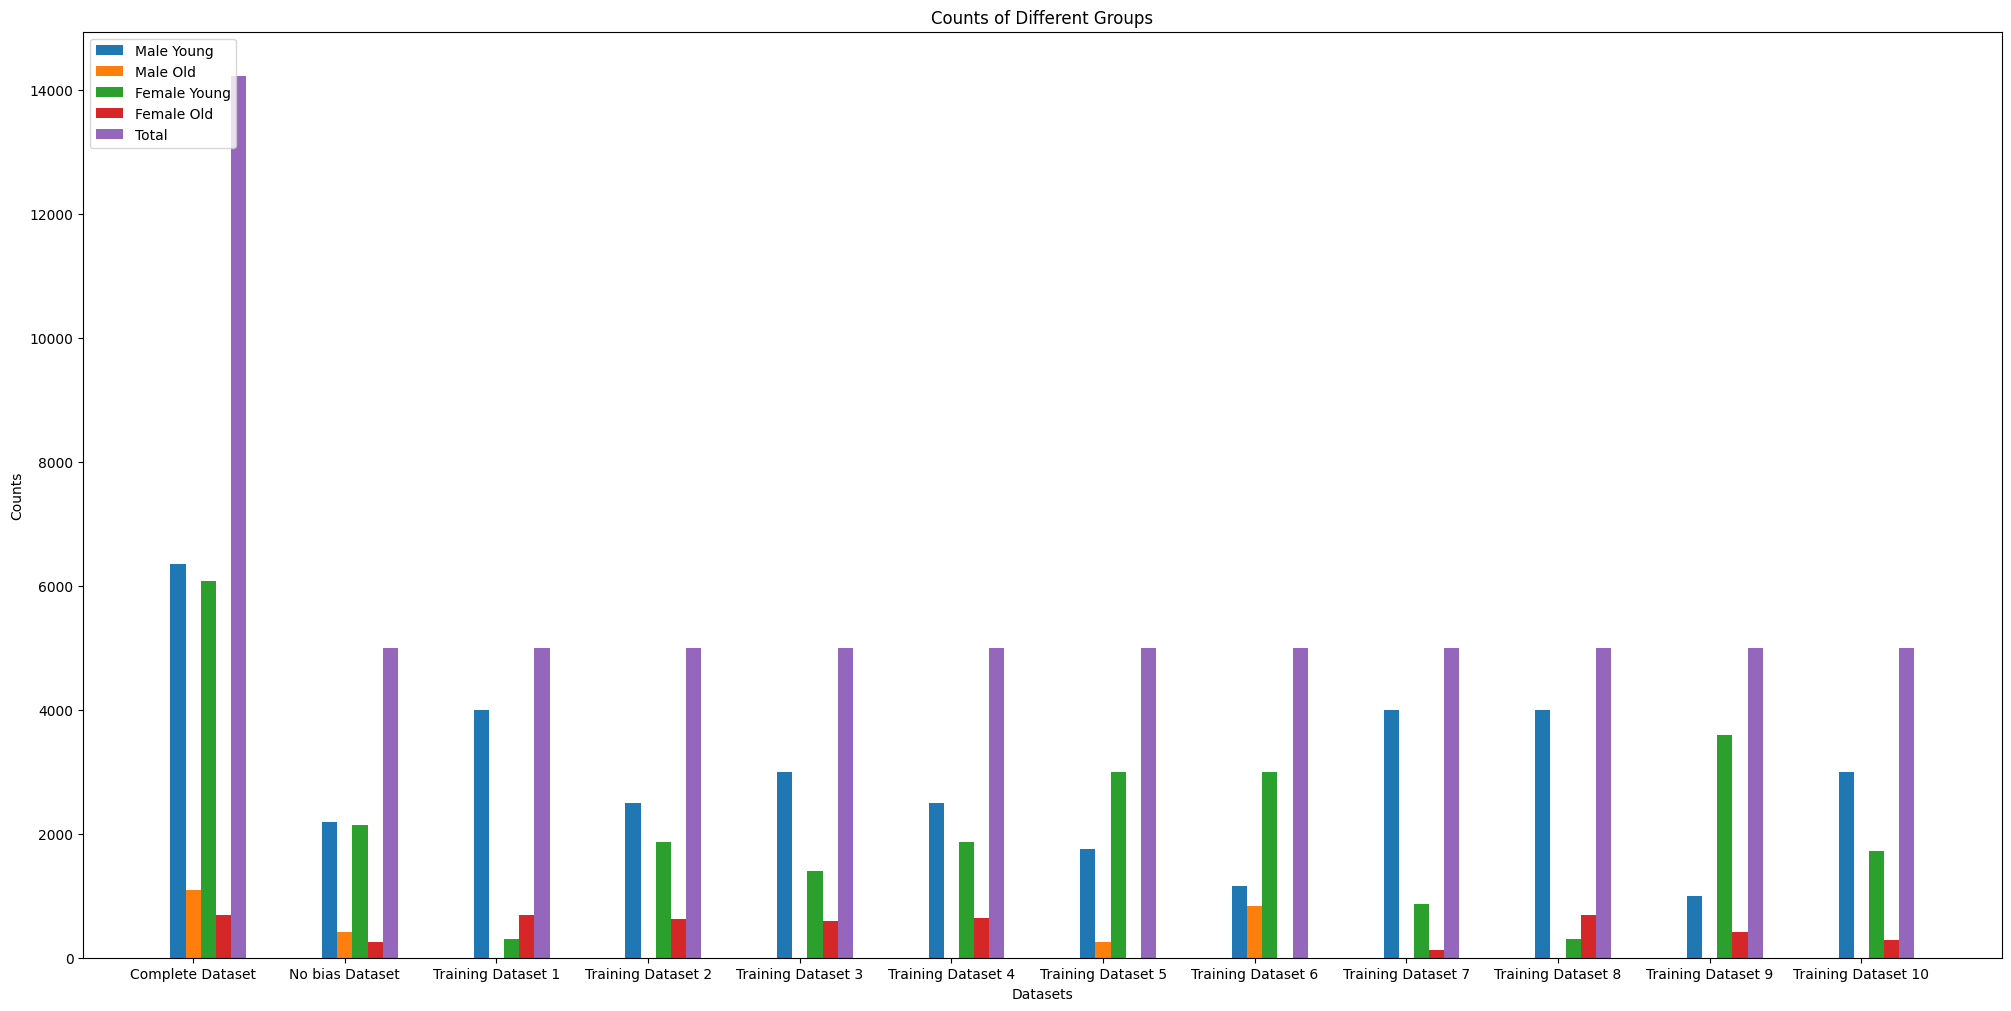

In [50]:
names = ["Complete Dataset" , "No bias Dataset"] + [f'Training Dataset {i + 1}' for i in range(len(dfs_gen2))]
dict_ = {"Male Young": male_yng_counts, 
        "Male Old": male_old_counts,
        "Female Young": female_yng_counts,
        "Female Old": female_old_counts,
        "Total": total_counts}
bar_plot(names, dict_, "Datasets", "Counts", "Counts of Different Groups")

In [51]:
train_dataloaders = [comp_train_dataloader, no_bias_dataloader] + train_dataloaders
print(len(train_dataloaders))

12


## Using Pretrained Models
#### 1) Resnet34

In [52]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__()
        resnet = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in resnet.parameters():
            param.requires_grad = True
            
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [53]:
model = Resnet34(1).to(device)
model, train_loss, val_loss = train(model, train_dataloaders[2], val_dataloader, epochs = 5, verbose = False)
test_loss = eval_model(model, test_dataloader)
print(f"Test Loss: {test_loss}")
group_tst_loss = group_eval_cnn(model, group_test_dataloaders)

  0%|                                                                                                                                                   | 0/5 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██

Test Loss: 136.91741943359375
Group test Loss: 855.7321701049805


In [54]:
lrs = [25e-4, 225e-5, 2e-3, 175e-5, 15e-4, 125e-5, 1e-3, 75e-5,  5e-4, 25e-5]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

test_losses = np.zeros((len(lrs), len(wds)))
grp_test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"[{i *len(wds) + j +1}/{len(lrs) * len(wds)}] Lr: {lrs[i]} WD:{wds[j]}")
        model = Resnet34(1).to(device)
        model, train_loss, val_loss = train(model, train_dataloaders[2], val_dataloader, epochs = 5, verbose = False, lr = lrs[i], weight_decay = wds[j])
        test_loss = eval_model(model, val_dataloader)
        print(f"Test Loss: {test_loss}")
        group_tst_loss = group_eval_cnn(model, group_val_dataloaders)

        test_losses[i,j] = test_loss
        grp_test_losses[i,j] = group_tst_loss[0]

best_lr, best_wd = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_lr, best_grp_wd = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")
print(f"Group wise hyperparameters: \n Best LR: {lrs[best_grp_lr]} Best WD: {wds[best_grp_wd]}")

[1/60] Lr: 0.0025 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.41s/it]


Test Loss: 144.76651000976562
Group test Loss: 880.5031776428223
[2/60] Lr: 0.0025 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.68s/it]


Test Loss: 181.19345092773438
Group test Loss: 892.300853729248
[3/60] Lr: 0.0025 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.83s/it]


Test Loss: 189.03480529785156
Group test Loss: 901.8968200683594
[4/60] Lr: 0.0025 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.78s/it]


Test Loss: 173.4907684326172
Group test Loss: 876.4658851623535
[5/60] Lr: 0.0025 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.80s/it]


Test Loss: 142.8610382080078
Group test Loss: 861.8661155700684
[6/60] Lr: 0.0025 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.74s/it]


Test Loss: 165.86680603027344
Group test Loss: 882.1927642822266
[7/60] Lr: 0.00225 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.78s/it]


Test Loss: 138.70254516601562
Group test Loss: 907.7179946899414
[8/60] Lr: 0.00225 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.84s/it]


Test Loss: 160.4412078857422
Group test Loss: 923.5870399475098
[9/60] Lr: 0.00225 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.77s/it]


Test Loss: 147.35354614257812
Group test Loss: 837.5235557556152
[10/60] Lr: 0.00225 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.86s/it]


Test Loss: 167.1429901123047
Group test Loss: 877.6848449707031
[11/60] Lr: 0.00225 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.86s/it]


Test Loss: 161.10177612304688
Group test Loss: 898.6584739685059
[12/60] Lr: 0.00225 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.75s/it]


Test Loss: 162.29254150390625
Group test Loss: 897.8089599609375
[13/60] Lr: 0.002 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 131.16558837890625
Group test Loss: 860.6785659790039
[14/60] Lr: 0.002 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.78s/it]


Test Loss: 143.22499084472656
Group test Loss: 889.2271919250488
[15/60] Lr: 0.002 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.84s/it]


Test Loss: 162.12026977539062
Group test Loss: 913.6108741760254
[16/60] Lr: 0.002 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.76s/it]


Test Loss: 168.2757110595703
Group test Loss: 894.9751014709473
[17/60] Lr: 0.002 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.87s/it]


Test Loss: 147.8204803466797
Group test Loss: 906.3388710021973
[18/60] Lr: 0.002 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.86s/it]


Test Loss: 154.13682556152344
Group test Loss: 930.5623016357422
[19/60] Lr: 0.00175 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 153.60653686523438
Group test Loss: 883.0551605224609
[20/60] Lr: 0.00175 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.82s/it]


Test Loss: 196.0298309326172
Group test Loss: 869.3769721984863
[21/60] Lr: 0.00175 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 149.89295959472656
Group test Loss: 924.6843757629395
[22/60] Lr: 0.00175 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.03s/it]


Test Loss: 161.5206298828125
Group test Loss: 893.3920059204102
[23/60] Lr: 0.00175 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.56s/it]


Test Loss: 141.1183624267578
Group test Loss: 935.2373008728027
[24/60] Lr: 0.00175 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.20s/it]


Test Loss: 141.76800537109375
Group test Loss: 880.0332183837891
[25/60] Lr: 0.0015 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.93s/it]


Test Loss: 144.17898559570312
Group test Loss: 911.0602130889893
[26/60] Lr: 0.0015 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.99s/it]


Test Loss: 140.2490997314453
Group test Loss: 874.8843116760254
[27/60] Lr: 0.0015 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.80s/it]


Test Loss: 188.61569213867188
Group test Loss: 959.5112648010254
[28/60] Lr: 0.0015 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.99s/it]


Test Loss: 169.59132385253906
Group test Loss: 874.4980239868164
[29/60] Lr: 0.0015 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.98s/it]


Test Loss: 148.821533203125
Group test Loss: 945.1693382263184
[30/60] Lr: 0.0015 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.96s/it]


Test Loss: 146.18141174316406
Group test Loss: 945.4409942626953
[31/60] Lr: 0.00125 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.88s/it]


Test Loss: 166.7987060546875
Group test Loss: 890.5467643737793
[32/60] Lr: 0.00125 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.92s/it]


Test Loss: 152.24168395996094
Group test Loss: 898.5924949645996
[33/60] Lr: 0.00125 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.94s/it]


Test Loss: 134.3763885498047
Group test Loss: 880.1127891540527
[34/60] Lr: 0.00125 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.92s/it]


Test Loss: 204.45079040527344
Group test Loss: 941.2757034301758
[35/60] Lr: 0.00125 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.89s/it]


Test Loss: 151.6694793701172
Group test Loss: 905.8010520935059
[36/60] Lr: 0.00125 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.86s/it]


Test Loss: 144.62811279296875
Group test Loss: 930.2964859008789
[37/60] Lr: 0.001 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.84s/it]


Test Loss: 138.92564392089844
Group test Loss: 898.8127155303955
[38/60] Lr: 0.001 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.82s/it]


Test Loss: 141.709716796875
Group test Loss: 884.5715713500977
[39/60] Lr: 0.001 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.91s/it]


Test Loss: 139.825927734375
Group test Loss: 938.7952156066895
[40/60] Lr: 0.001 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.04s/it]


Test Loss: 133.18019104003906
Group test Loss: 897.3318939208984
[41/60] Lr: 0.001 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.94s/it]


Test Loss: 146.56243896484375
Group test Loss: 928.6902122497559
[42/60] Lr: 0.001 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.88s/it]


Test Loss: 212.5978240966797
Group test Loss: 970.0138931274414
[43/60] Lr: 0.00075 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.95s/it]


Test Loss: 158.43687438964844
Group test Loss: 939.982738494873
[44/60] Lr: 0.00075 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 19.00s/it]


Test Loss: 126.26988220214844
Group test Loss: 894.0849800109863
[45/60] Lr: 0.00075 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.86s/it]


Test Loss: 155.93795776367188
Group test Loss: 932.9898376464844
[46/60] Lr: 0.00075 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.82s/it]


Test Loss: 169.46917724609375
Group test Loss: 914.733512878418
[47/60] Lr: 0.00075 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.97s/it]


Test Loss: 123.51995849609375
Group test Loss: 907.463062286377
[48/60] Lr: 0.00075 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.82s/it]


Test Loss: 144.77908325195312
Group test Loss: 884.0659294128418
[49/60] Lr: 0.0005 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.88s/it]


Test Loss: 125.78173065185547
Group test Loss: 887.4118328094482
[50/60] Lr: 0.0005 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 145.9599609375
Group test Loss: 929.9678230285645
[51/60] Lr: 0.0005 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.97s/it]


Test Loss: 164.25460815429688
Group test Loss: 925.0360679626465
[52/60] Lr: 0.0005 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.96s/it]


Test Loss: 119.5530776977539
Group test Loss: 899.6579933166504
[53/60] Lr: 0.0005 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.92s/it]


Test Loss: 143.0541229248047
Group test Loss: 912.2290649414062
[54/60] Lr: 0.0005 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.92s/it]


Test Loss: 128.3986358642578
Group test Loss: 911.9102725982666
[55/60] Lr: 0.00025 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.90s/it]


Test Loss: 157.8142852783203
Group test Loss: 1093.3196029663086
[56/60] Lr: 0.00025 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.85s/it]


Test Loss: 231.41256713867188
Group test Loss: 1152.933692932129
[57/60] Lr: 0.00025 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.85s/it]


Test Loss: 193.97274780273438
Group test Loss: 1128.1672477722168
[58/60] Lr: 0.00025 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.03s/it]


Test Loss: 160.0751953125
Group test Loss: 1117.0651779174805
[59/60] Lr: 0.00025 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.98s/it]


Test Loss: 156.7706298828125
Group test Loss: 1108.1027297973633
[60/60] Lr: 0.00025 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Test Loss: 148.119384765625
Group test Loss: 1085.341438293457
Best LR: 0.0005 Best WD: 0.005
Group wise hyperparameters: 
 Best LR: 0.00225 Best WD: 0.0001


In [55]:
# Training models on different Training Datasets
tlosses = []
vlosses = []
tst_losses = []
grp_tst_losses = []
grp_tst_losses_t = []
grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
##### 
# Setting hyperparameters for reproducing results
lrs = [25e-4, 225e-5, 2e-3, 175e-5, 15e-4, 125e-5, 1e-3, 75e-5,  5e-4, 25e-5]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

best_lr = lrs.index(0.00225)
best_wd = wds.index(0.0001)
#####
for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = Resnet34(1).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 10, lr = lrs[best_lr], weight_decay = wds[best_wd])
    test_loss = eval_model(model, test_dataloader)
    print(f"Test dataset loss: {test_loss}")
    group_loss, groups = group_eval_cnn(model, group_test_dataloaders)
    group_loss_t, groups_train = group_eval_cnn(model, train_group_dataloaders[i])
    

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)
    grp_tst_losses.append(group_loss)
    grp_tst_losses_t.append(group_loss_t)

    grp_wise_losses['m yng'].append(groups['m yng'])
    grp_wise_losses['m old'].append(groups['m old'])
    grp_wise_losses['f yng'].append(groups['f yng'])
    grp_wise_losses['f old'].append(groups['f old'])

    grp_wise_losses_t['m yng'].append(groups_train['m yng'])
    grp_wise_losses_t['m old'].append(groups_train['m old'])
    grp_wise_losses_t['f yng'].append(groups_train['f yng'])
    grp_wise_losses_t['f old'].append(groups_train['f old'])

    torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

[1/12] Complete Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:45<00:00, 40.51s/it]


Test dataset loss: 62.399696350097656
Group test Loss: 755.8267707824707
Group test Loss: 747.784631729126
Model saved to ./Models/Gen2_models/model0.pth
[2/12] No Bias Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.90s/it]


Test dataset loss: 81.64839172363281
Group test Loss: 925.8920860290527
Group test Loss: 913.1579246520996
Model saved to ./Models/Gen2_models/model1.pth
[3/12] Training dataset 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.83s/it]


Test dataset loss: 158.27586364746094
Group test Loss: 829.8448295593262
Group test Loss: 793.5034535725912
Model saved to ./Models/Gen2_models/model2.pth
[4/12] Training dataset 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.89s/it]


Test dataset loss: 180.3577880859375
Group test Loss: 785.4989318847656
Group test Loss: 572.9566599527994
Model saved to ./Models/Gen2_models/model3.pth
[5/12] Training dataset 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.83s/it]


Test dataset loss: 319.6398620605469
Group test Loss: 740.0748748779297
Group test Loss: 423.3187739054362
Model saved to ./Models/Gen2_models/model4.pth
[6/12] Training dataset 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.82s/it]


Test dataset loss: 151.53997802734375
Group test Loss: 794.2414169311523
Group test Loss: 572.7049433390299
Model saved to ./Models/Gen2_models/model5.pth
[7/12] Training dataset 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:07<00:00, 18.78s/it]


Test dataset loss: 269.28887939453125
Group test Loss: 679.4316940307617
Group test Loss: 228.5266367594401
Model saved to ./Models/Gen2_models/model6.pth
[8/12] Training dataset 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.82s/it]


Test dataset loss: 204.67373657226562
Group test Loss: 966.8576774597168
Group test Loss: 695.8361612955729
Model saved to ./Models/Gen2_models/model7.pth
[9/12] Training dataset 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.80s/it]


Test dataset loss: 309.239990234375
Group test Loss: 663.4747848510742
Group test Loss: 162.0155029296875
Model saved to ./Models/Gen2_models/model8.pth
[10/12] Training dataset 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.80s/it]


Test dataset loss: 252.9310760498047
Group test Loss: 794.2225112915039
Group test Loss: 643.638437906901
Model saved to ./Models/Gen2_models/model9.pth
[11/12] Training dataset 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.86s/it]


Test dataset loss: 257.0464782714844
Group test Loss: 736.2954483032227
Group test Loss: 302.4603322347005
Model saved to ./Models/Gen2_models/model10.pth
[12/12] Training dataset 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.82s/it]


Test dataset loss: 172.05564880371094
Group test Loss: 809.7691593170166
Group test Loss: 357.51224009195965
Model saved to ./Models/Gen2_models/model11.pth


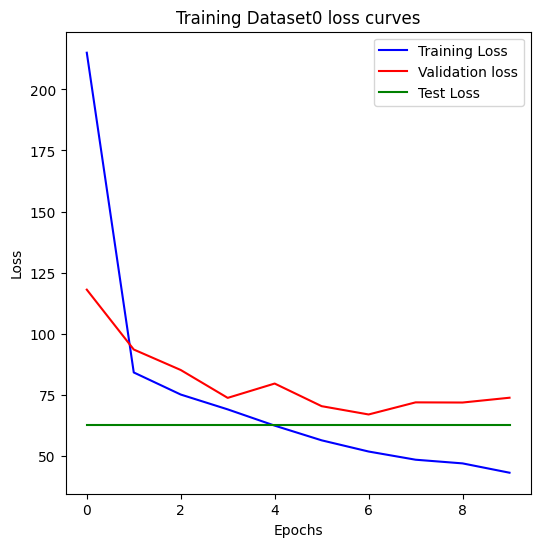

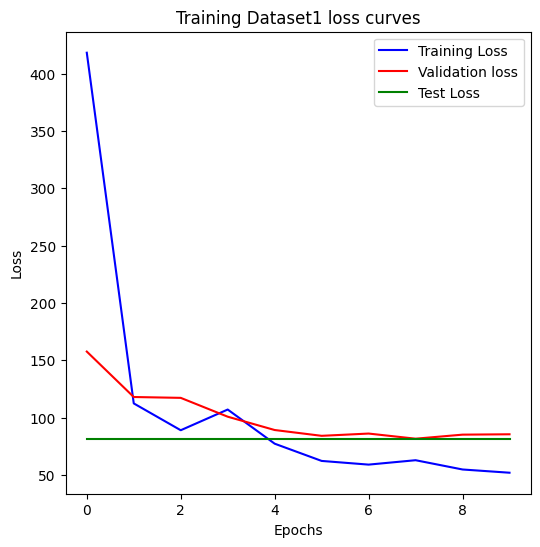

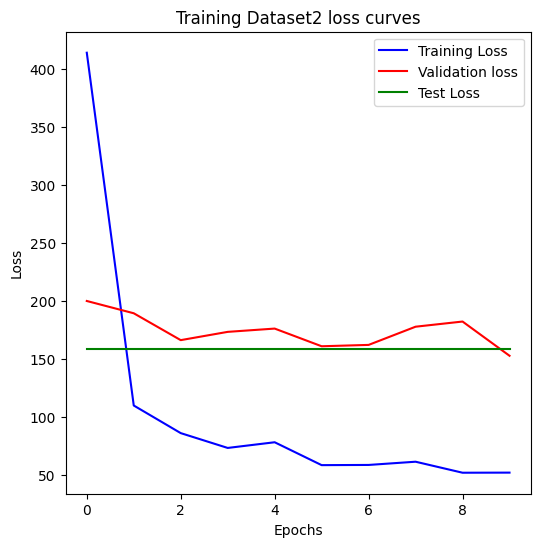

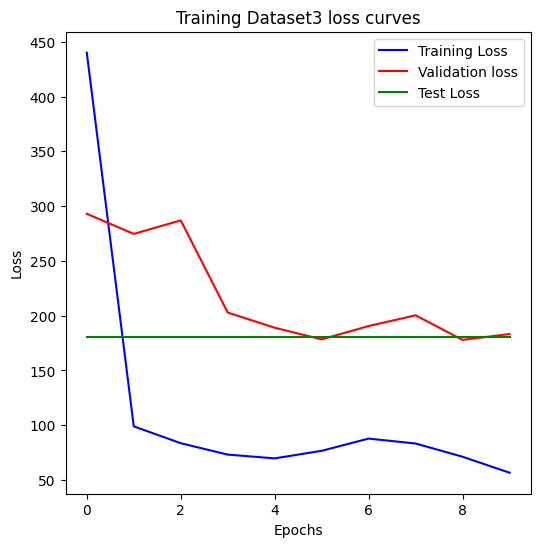

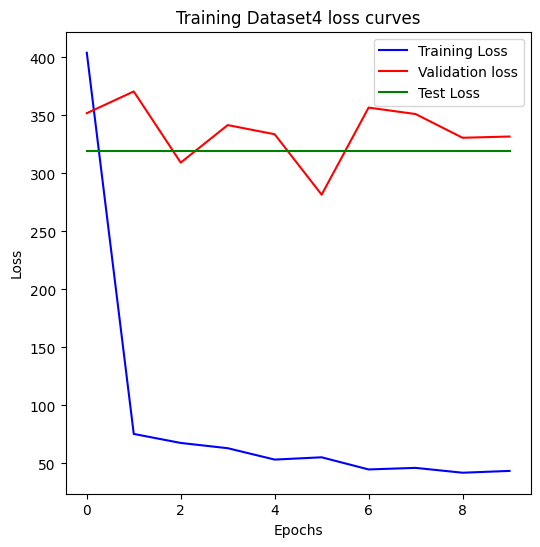

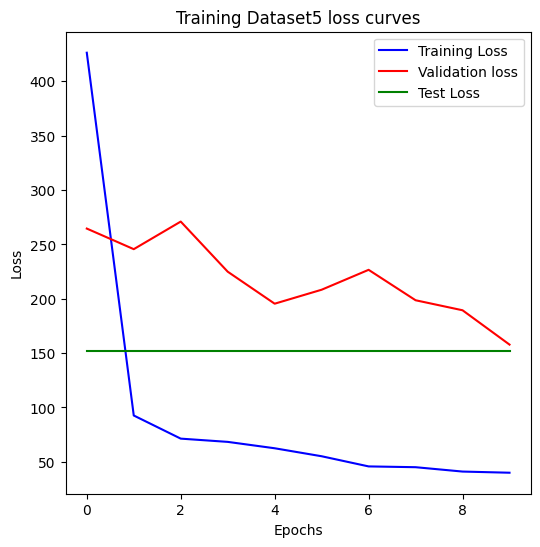

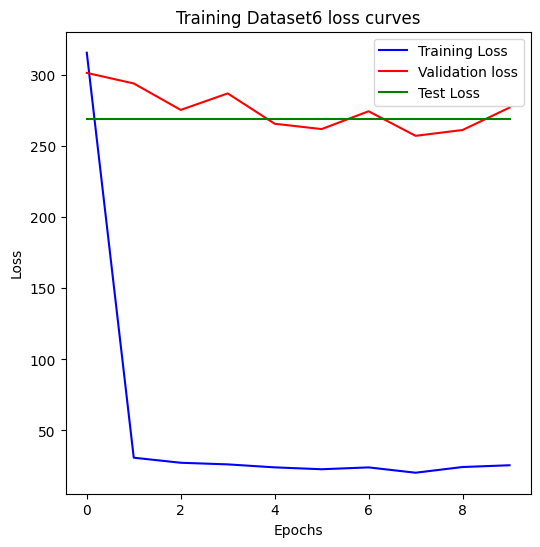

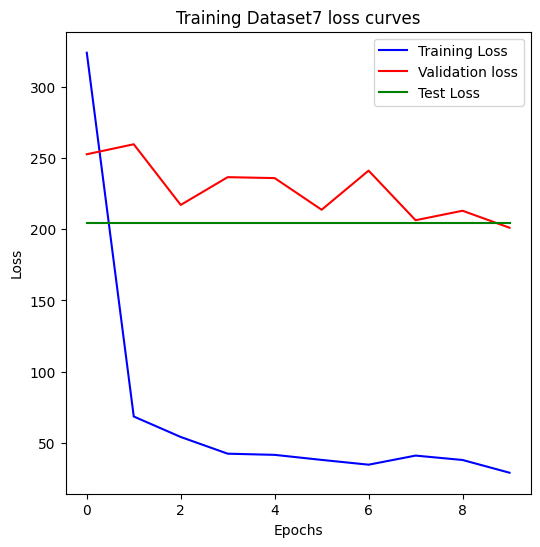

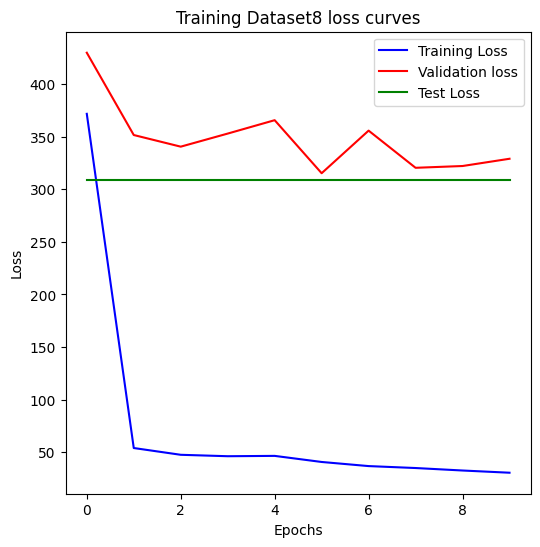

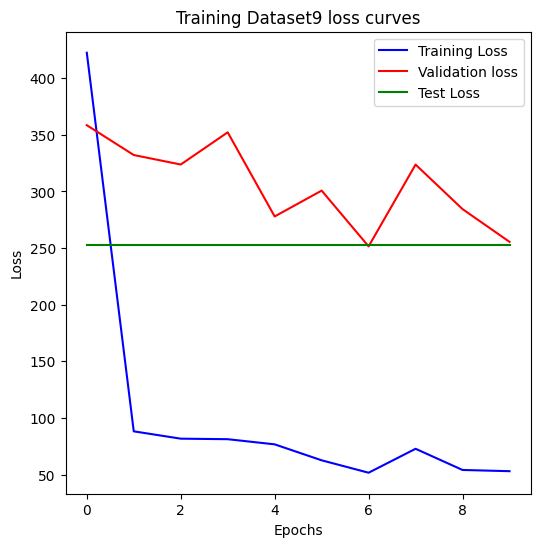

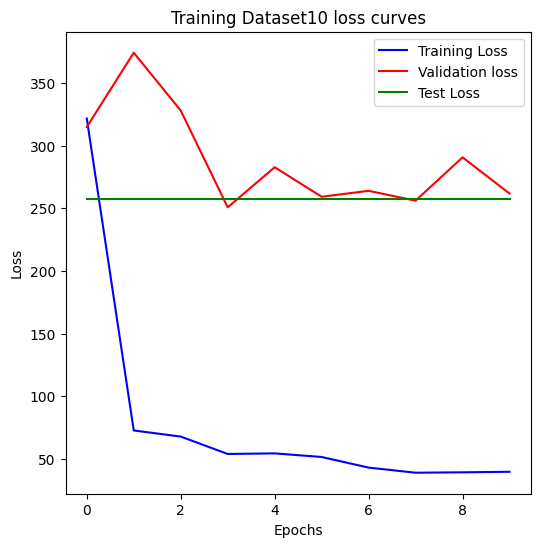

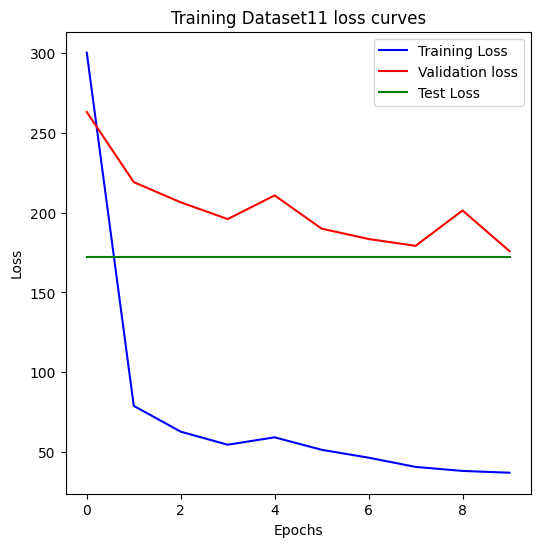

In [56]:
#plotting graphs:
plt.rcParams['figure.figsize'] = (6, 6)
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs=10, model_name=f"Training Dataset{i}")

#### 2) Margin Forgetting Loss model

In [57]:
class SiFer_margin(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4]):
        super(SiFer_margin, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
        
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_classes))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:10<00:00, 25.01s/it]


Test Loss: 141.82675170898438
Group test Loss: 169.89050102233887


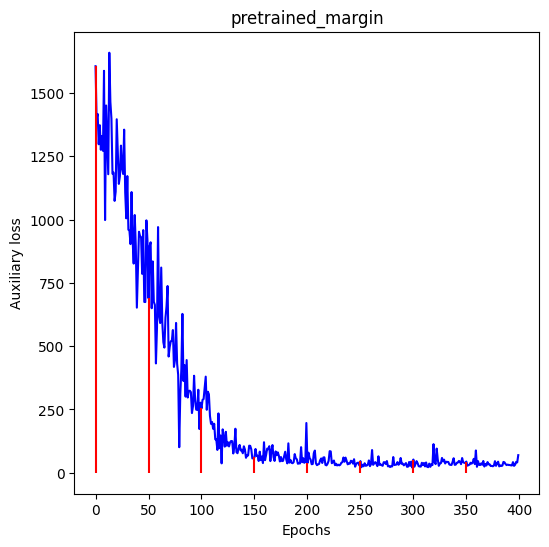

In [58]:
sifer_margin = SiFer_margin(BasicBlock, 1, aux_kernels = [64, 128], layers = [5, 4]).to(device)
sifer_margin, train_losses, val_losses, aux_losses, forget_losses = train_fs_mar(sifer_margin, train_dataloaders[2], val_dataloader, epochs = 10, verbose = False, forget_iters = 50)
test_loss = eval_FSModel(sifer_margin, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_margin, group_test_dataloaders)

plt.rcParams['figure.figsize'] = (6,6)
plot_aux_losses(aux_losses, model_name = "pretrained_margin", forget_iters = 50)
# plt.plot(range(len(forget_losses)), forget_losses)
plt.show()

In [59]:
# Hyperparameter Tuning
margins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1} / {len(margins) * len(forget_lrs)* len(forget_iters)}] Margin {margins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_margin(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_mar(model, train_dataloaders[2], val_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, val_dataloader)
            print(f"Test Loss: {test_loss}")
            grp_loss = group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = grp_loss[0]

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")
print(f"Group hyperparameters: \n Best margin: {margins[best_grp_margin]} Best Forget Lr: {forget_lrs[best_grp_forget_lr]} Best Forget Iter: {forget_iters[best_grp_forget_iter]}")

[1 / 96] Margin 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 139.48561096191406
Group test Loss: 190.58447456359863
[2 / 96] Margin 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.83s/it]


Test Loss: 228.86895751953125
Group test Loss: 219.60998153686523
[3 / 96] Margin 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.20s/it]


Test Loss: 148.72592163085938
Group test Loss: 203.54312896728516
[4 / 96] Margin 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]


Test Loss: 126.63835144042969
Group test Loss: 201.5441551208496
[5 / 96] Margin 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 209.58010864257812
Group test Loss: 408.81494522094727
[6 / 96] Margin 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.66s/it]


Test Loss: 114.8139877319336
Group test Loss: 175.78374862670898
[7 / 96] Margin 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 126.16752624511719
Group test Loss: 184.54302978515625
[8 / 96] Margin 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.63s/it]


Test Loss: 126.05585479736328
Group test Loss: 185.18577575683594
[9 / 96] Margin 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 125.21524047851562
Group test Loss: 251.99423217773438
[10 / 96] Margin 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.60s/it]


Test Loss: 127.8590087890625
Group test Loss: 188.2275047302246
[11 / 96] Margin 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 136.6168212890625
Group test Loss: 197.59219360351562
[12 / 96] Margin 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 126.80473327636719
Group test Loss: 196.59252548217773
[13 / 96] Margin 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.27s/it]


Test Loss: 230.26283264160156
Group test Loss: 283.78503608703613
[14 / 96] Margin 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.76s/it]


Test Loss: 161.6387939453125
Group test Loss: 327.14022064208984
[15 / 96] Margin 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.24s/it]


Test Loss: 142.86463928222656
Group test Loss: 173.0789089202881
[16 / 96] Margin 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 124.95407104492188
Group test Loss: 174.53741645812988
[17 / 96] Margin 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.23s/it]


Test Loss: 150.63829040527344
Group test Loss: 267.61453437805176
[18 / 96] Margin 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]


Test Loss: 146.59933471679688
Group test Loss: 177.24359321594238
[19 / 96] Margin 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.27s/it]


Test Loss: 116.50228118896484
Group test Loss: 183.5594940185547
[20 / 96] Margin 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.83s/it]


Test Loss: 199.41651916503906
Group test Loss: 259.9745178222656
[21 / 96] Margin 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.26s/it]


Test Loss: 122.0755386352539
Group test Loss: 172.77406120300293
[22 / 96] Margin 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 121.60132598876953
Group test Loss: 198.6252784729004
[23 / 96] Margin 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.20s/it]


Test Loss: 118.56521606445312
Group test Loss: 186.21098518371582
[24 / 96] Margin 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.84s/it]


Test Loss: 142.70358276367188
Group test Loss: 241.05575561523438
[25 / 96] Margin 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.30s/it]


Test Loss: 152.66470336914062
Group test Loss: 206.4365520477295
[26 / 96] Margin 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]


Test Loss: 130.16592407226562
Group test Loss: 213.22570991516113
[27 / 96] Margin 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 150.90342712402344
Group test Loss: 332.42333221435547
[28 / 96] Margin 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 157.4989776611328
Group test Loss: 178.4250946044922
[29 / 96] Margin 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 132.0531768798828
Group test Loss: 205.7127685546875
[30 / 96] Margin 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 116.0506591796875
Group test Loss: 204.66386795043945
[31 / 96] Margin 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


Test Loss: 196.3594207763672
Group test Loss: 188.35597610473633
[32 / 96] Margin 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 143.84713745117188
Group test Loss: 229.97064590454102
[33 / 96] Margin 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 186.46511840820312
Group test Loss: 241.79776573181152
[34 / 96] Margin 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 139.00338745117188
Group test Loss: 315.4256954193115
[35 / 96] Margin 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 137.23251342773438
Group test Loss: 206.24789237976074
[36 / 96] Margin 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 146.5606689453125
Group test Loss: 208.3797836303711
[37 / 96] Margin 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


Test Loss: 141.7039337158203
Group test Loss: 220.36798095703125
[38 / 96] Margin 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.64s/it]


Test Loss: 153.9343719482422
Group test Loss: 178.9877414703369
[39 / 96] Margin 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 159.9310302734375
Group test Loss: 212.32141304016113
[40 / 96] Margin 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 140.62353515625
Group test Loss: 227.6433925628662
[41 / 96] Margin 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 352.9287109375
Group test Loss: 878.7961654663086
[42 / 96] Margin 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.63s/it]


Test Loss: 203.8970489501953
Group test Loss: 280.8016052246094
[43 / 96] Margin 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


Test Loss: 216.61582946777344
Group test Loss: 279.15405082702637
[44 / 96] Margin 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.72s/it]


Test Loss: 152.314208984375
Group test Loss: 251.51809310913086
[45 / 96] Margin 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 524.7822875976562
Group test Loss: 1394.582431793213
[46 / 96] Margin 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.74s/it]


Test Loss: 171.91610717773438
Group test Loss: 211.69982528686523
[47 / 96] Margin 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


Test Loss: 941.4052124023438
Group test Loss: 2203.4251708984375
[48 / 96] Margin 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 473.0830078125
Group test Loss: 928.2948303222656
[49 / 96] Margin 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.25s/it]


Test Loss: 361.69732666015625
Group test Loss: 689.9466171264648
[50 / 96] Margin 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 141.56825256347656
Group test Loss: 316.50608825683594
[51 / 96] Margin 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.23s/it]


Test Loss: 160.99937438964844
Group test Loss: 167.02069282531738
[52 / 96] Margin 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.73s/it]


Test Loss: 172.52297973632812
Group test Loss: 191.14258575439453
[53 / 96] Margin 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 185.7878875732422
Group test Loss: 344.0374126434326
[54 / 96] Margin 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 234.42298889160156
Group test Loss: 304.4403190612793
[55 / 96] Margin 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 168.905517578125
Group test Loss: 335.9938278198242
[56 / 96] Margin 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 136.9352569580078
Group test Loss: 183.69768142700195
[57 / 96] Margin 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 295.4774169921875
Group test Loss: 650.5997276306152
[58 / 96] Margin 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 370.58770751953125
Group test Loss: 931.3254585266113
[59 / 96] Margin 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.25s/it]


Test Loss: 256.75616455078125
Group test Loss: 539.6485710144043
[60 / 96] Margin 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 179.49745178222656
Group test Loss: 355.57054901123047
[61 / 96] Margin 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.21s/it]


Test Loss: 274.78582763671875
Group test Loss: 252.17620849609375
[62 / 96] Margin 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 215.21405029296875
Group test Loss: 264.617374420166
[63 / 96] Margin 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


Test Loss: 150.9352569580078
Group test Loss: 191.28671646118164
[64 / 96] Margin 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 124.54212188720703
Group test Loss: 170.15860557556152
[65 / 96] Margin 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.33s/it]


Test Loss: 303.1318664550781
Group test Loss: 777.0755653381348
[66 / 96] Margin 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 205.75059509277344
Group test Loss: 369.8168067932129
[67 / 96] Margin 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.20s/it]


Test Loss: 177.64971923828125
Group test Loss: 240.39637756347656
[68 / 96] Margin 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 148.5850372314453
Group test Loss: 283.61793327331543
[69 / 96] Margin 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.15s/it]


Test Loss: 284.19189453125
Group test Loss: 551.5260238647461
[70 / 96] Margin 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.63s/it]


Test Loss: 291.6134338378906
Group test Loss: 582.1190376281738
[71 / 96] Margin 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.08s/it]


Test Loss: 255.39735412597656
Group test Loss: 414.50109481811523
[72 / 96] Margin 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.71s/it]


Test Loss: 260.5631408691406
Group test Loss: 452.0850524902344
[73 / 96] Margin 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


Test Loss: 165.69004821777344
Group test Loss: 285.08207511901855
[74 / 96] Margin 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.71s/it]


Test Loss: 166.8373565673828
Group test Loss: 314.7512950897217
[75 / 96] Margin 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.04s/it]


Test Loss: 153.63504028320312
Group test Loss: 249.01798820495605
[76 / 96] Margin 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 172.98670959472656
Group test Loss: 232.67481803894043
[77 / 96] Margin 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.06s/it]


Test Loss: 282.7605285644531
Group test Loss: 614.9511566162109
[78 / 96] Margin 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.60s/it]


Test Loss: 288.5735168457031
Group test Loss: 358.8178253173828
[79 / 96] Margin 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]


Test Loss: 211.88760375976562
Group test Loss: 260.32187271118164
[80 / 96] Margin 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 165.724365234375
Group test Loss: 302.8984832763672
[81 / 96] Margin 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 377.712646484375
Group test Loss: 611.7874984741211
[82 / 96] Margin 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 332.0541076660156
Group test Loss: 710.510383605957
[83 / 96] Margin 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


Test Loss: 328.8577575683594
Group test Loss: 787.0664672851562
[84 / 96] Margin 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 264.9395446777344
Group test Loss: 622.5976524353027
[85 / 96] Margin 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


Test Loss: 327.0568542480469
Group test Loss: 694.3393898010254
[86 / 96] Margin 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 119.22169494628906
Group test Loss: 203.9964771270752
[87 / 96] Margin 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


Test Loss: 133.5904541015625
Group test Loss: 189.34916877746582
[88 / 96] Margin 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 130.31906127929688
Group test Loss: 218.59429359436035
[89 / 96] Margin 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 266.8349609375
Group test Loss: 533.8418273925781
[90 / 96] Margin 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 296.745361328125
Group test Loss: 520.1916618347168
[91 / 96] Margin 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 185.83349609375
Group test Loss: 295.5390930175781
[92 / 96] Margin 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 122.66368103027344
Group test Loss: 202.45090866088867
[93 / 96] Margin 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 356.7660217285156
Group test Loss: 496.45726776123047
[94 / 96] Margin 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 259.6000061035156
Group test Loss: 455.8302421569824
[95 / 96] Margin 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 578.700927734375
Group test Loss: 1298.0044174194336
[96 / 96] Margin 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 255.63246154785156
Group test Loss: 635.2308197021484
Best Margin : 2 Best Forget LR: 0.005 Best Forget Iter: 5
Group hyperparameters: 
 Best margin: 50 Best Forget Lr: 0.0001 Best Forget Iter: 2


In [60]:
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []
fs_grp_tst_losses = []
fs_grp_tst_losses_t = []
fs_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

fs_grp_wise_losses_t =  {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
#####
margins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_margin = margins.index(2)
best_forget_iter = forget_iters.index(5)
best_forget_lr = forget_lrs.index(0.0005)
#####

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_margin(BasicBlock, 1,aux_kernels = [128, 128], layers = [3, 4]).to(device)
    model, train_losses, val_losses,_, _ = train_fs_mar(model, train_dataloaders[i], val_dataloader, margin = margins[best_margin], forget_iters = forget_iters[best_forget_iter], lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr]], epochs = 10, verbose = False)
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    group_loss, groups = group_eval_fs(model, group_test_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)
    fs_grp_tst_losses.append(group_loss)
    fs_grp_tst_losses_t.append(group_loss_t)

    fs_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_grp_wise_losses['m old'].append(groups['m old'])
    fs_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_grp_wise_losses['f old'].append(groups['f old'])

    
    fs_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_grp_wise_losses_t['f old'].append(groups_t['f old'])
    
    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

[1/12] Complete Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:56<00:00, 59.67s/it]


Test Loss: 55.732513427734375
Group test Loss: 89.38609600067139
Group test Loss: 24.9928777217865
Model saved to ./Models/fs_mar_model0.pth
[2/12] No Bias Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.32s/it]


Test Loss: 70.05477142333984
Group test Loss: 107.66907691955566
Group test Loss: 29.74925136566162
Model saved to ./Models/fs_mar_model1.pth
[3/12] Training dataset 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.75s/it]


Test Loss: 112.24266815185547
Group test Loss: 163.10928344726562
Group test Loss: 14.412343343098959
Model saved to ./Models/fs_mar_model2.pth
[4/12] Training dataset 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:15<00:00, 25.59s/it]


Test Loss: 133.59994506835938
Group test Loss: 215.2570571899414
Group test Loss: 25.702434539794922
Model saved to ./Models/fs_mar_model3.pth
[5/12] Training dataset 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.34s/it]


Test Loss: 359.98876953125
Group test Loss: 336.8688278198242
Group test Loss: 44.3098570505778
Model saved to ./Models/fs_mar_model4.pth
[6/12] Training dataset 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.46s/it]


Test Loss: 152.0775909423828
Group test Loss: 184.66167831420898
Group test Loss: 27.514540036519367
Model saved to ./Models/fs_mar_model5.pth
[7/12] Training dataset 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:15<00:00, 25.56s/it]


Test Loss: 222.41302490234375
Group test Loss: 447.92172622680664
Group test Loss: 29.359639485677082
Model saved to ./Models/fs_mar_model6.pth
[8/12] Training dataset 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.34s/it]


Test Loss: 200.34800720214844
Group test Loss: 504.24202728271484
Group test Loss: 39.043624560038246
Model saved to ./Models/fs_mar_model7.pth
[9/12] Training dataset 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.30s/it]


Test Loss: 284.2642822265625
Group test Loss: 371.1515884399414
Group test Loss: 19.103179613749187
Model saved to ./Models/fs_mar_model8.pth
[10/12] Training dataset 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.29s/it]


Test Loss: 169.63177490234375
Group test Loss: 213.6606559753418
Group test Loss: 38.85620625813802
Model saved to ./Models/fs_mar_model9.pth
[11/12] Training dataset 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.36s/it]


Test Loss: 219.0985870361328
Group test Loss: 248.49895477294922
Group test Loss: 13.539167404174805
Model saved to ./Models/fs_mar_model10.pth
[12/12] Training dataset 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.34s/it]


Test Loss: 152.7039794921875
Group test Loss: 304.2158603668213
Group test Loss: 11.188859939575195
Model saved to ./Models/fs_mar_model11.pth


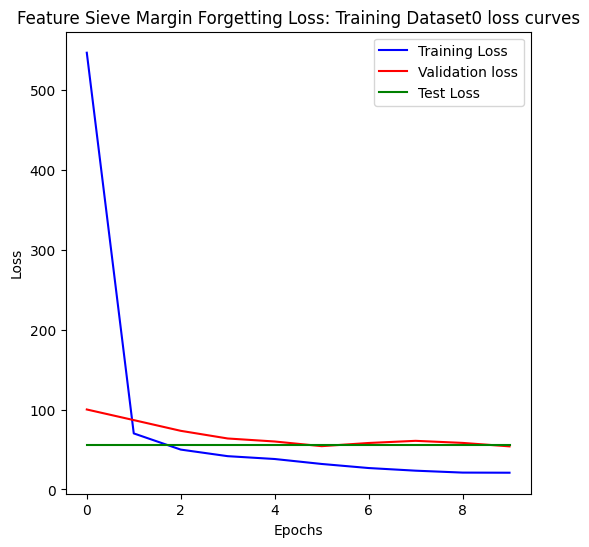

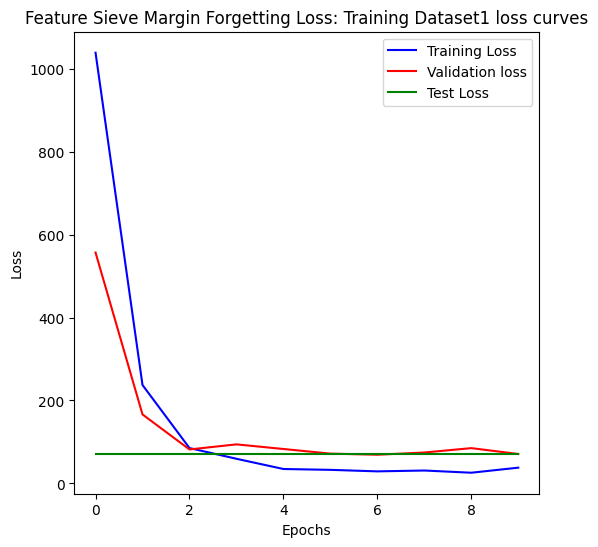

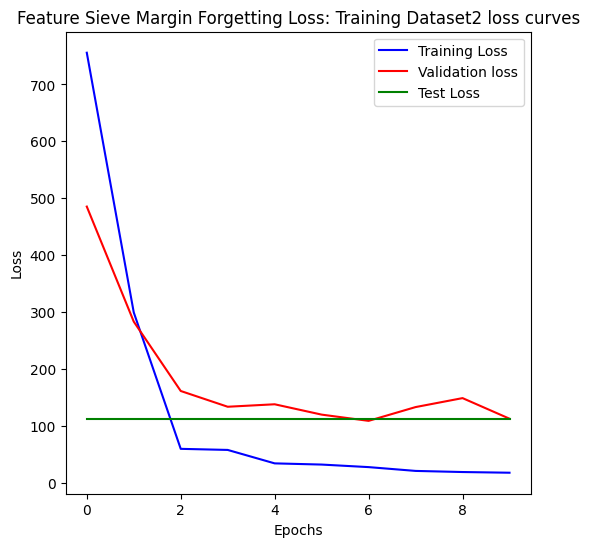

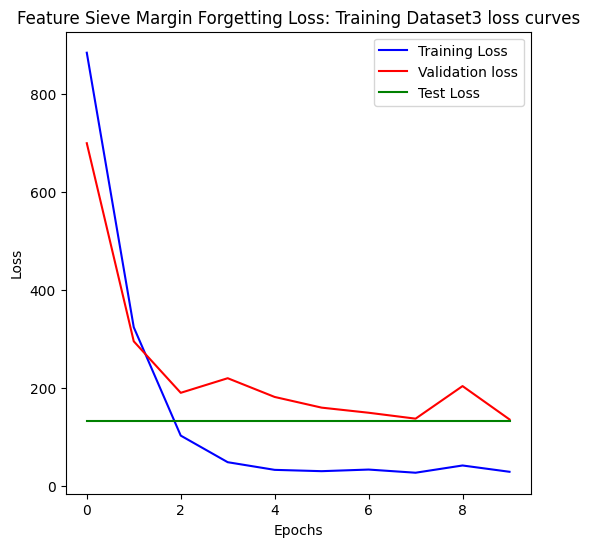

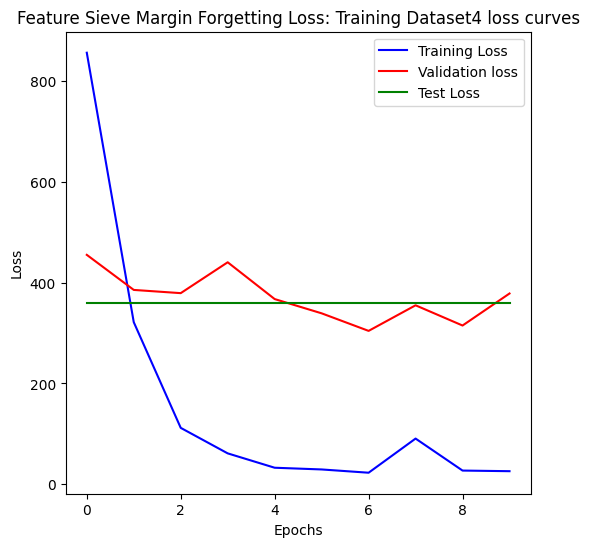

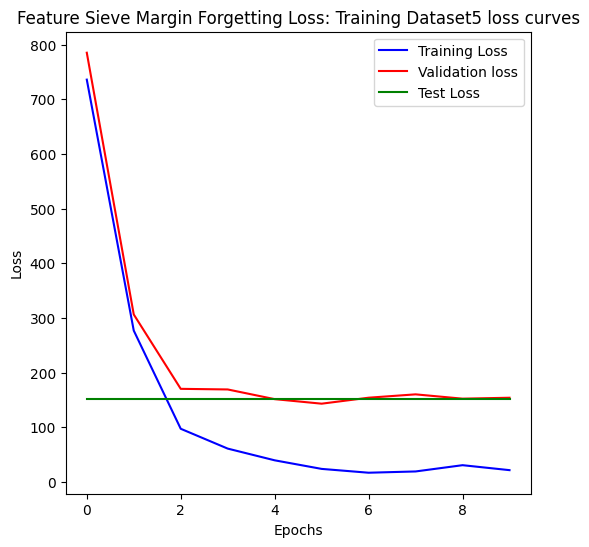

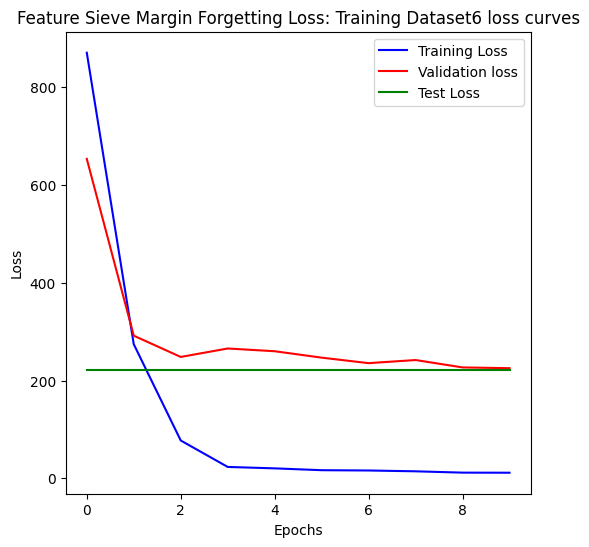

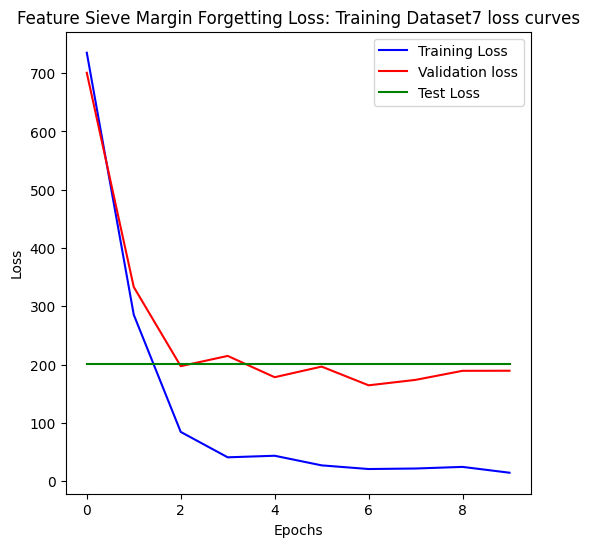

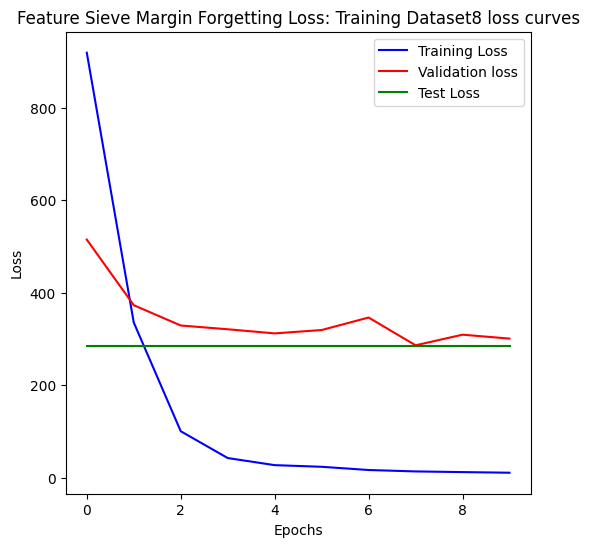

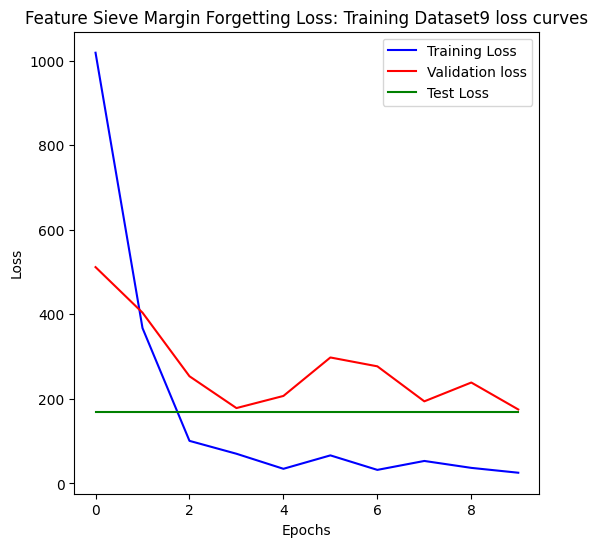

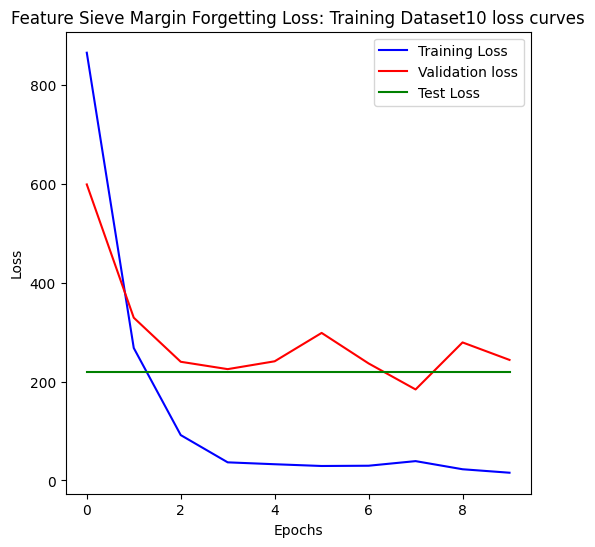

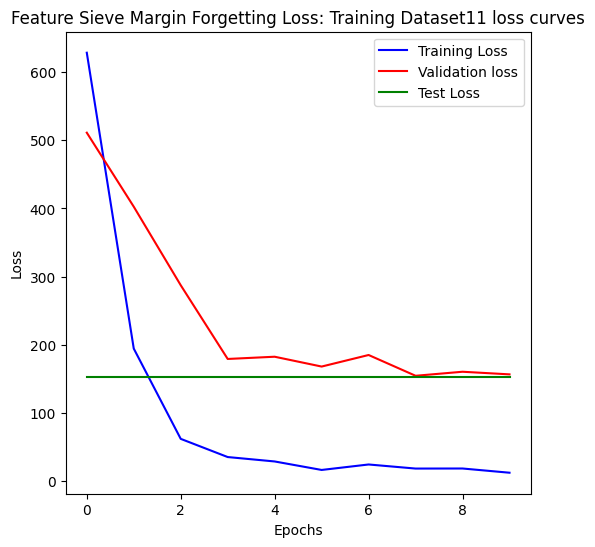

In [61]:
# plotting loss curves
plt.rcParams['figure.figsize'] = (6,6)
for i in range(len(fs_tlosses)):
    plot_loss_curves(fs_tlosses[i], fs_vlosses[i], fs_tst_losses[i], epochs = 10, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

#### 3) Cross Entropy Forgetting loss

In [62]:
class SiFer_ce(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4], num_bins = 20):
        super(SiFer_ce, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
            
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_bins))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.20s/it]


Test Loss: 217.7467498779297
Group test Loss: 417.37568283081055


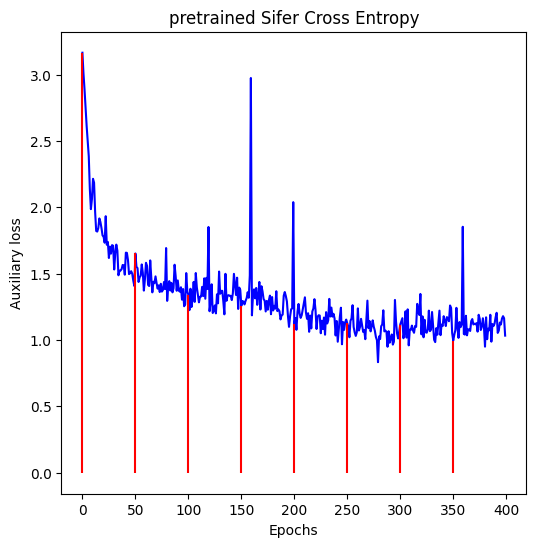

In [63]:
sifer_ce = SiFer_ce(BasicBlock, 1, aux_kernels=[128, 128], layers = [5,4]).to(device)
sifer_ce, train_losses, val_losses, aux_losses, forget_losses = train_fs_ce(sifer_ce, train_dataloaders[2], val_dataloader, ages, verbose = False, epochs = 10, forget_iters = 50)
test_loss = eval_FSModel(sifer_ce, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_ce, group_test_dataloaders)

plt.rcParams['figure.figsize'] = (6,6)
plot_aux_losses(aux_losses, model_name = "pretrained Sifer Cross Entropy", forget_iters = 50)

In [64]:
#Hyperparameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ce(BasicBlock, 1, num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ce(model, train_dataloaders[2], val_dataloader, ages, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, val_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ = group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins, best_forget_lr_ce, best_forget_iter_ce = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins]} Best Forget LR: {forget_lrs[best_forget_lr_ce]} Best Forget Iter: {forget_iters[best_forget_iter_ce]}")
print("Group Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ce_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ce_grp]}")

1/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


Test Loss: 144.4075469970703
Group test Loss: 261.62088203430176
2/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 173.23118591308594
Group test Loss: 237.36402702331543
3/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 164.2158660888672
Group test Loss: 319.15714836120605
4/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


Test Loss: 146.62408447265625
Group test Loss: 264.95922088623047
5/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 325.11029052734375
Group test Loss: 568.4606819152832
6/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.41s/it]


Test Loss: 225.61642456054688
Group test Loss: 474.94819831848145
7/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 217.9741668701172
Group test Loss: 313.44481658935547
8/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.40s/it]


Test Loss: 127.8255615234375
Group test Loss: 207.8542766571045
9/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 405.9188537597656
Group test Loss: 826.1947402954102
10/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.32s/it]


Test Loss: 302.7625732421875
Group test Loss: 563.0084648132324
11/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 322.4440002441406
Group test Loss: 695.2860374450684
12/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.56s/it]


Test Loss: 262.43719482421875
Group test Loss: 614.9952659606934
13/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.67s/it]


Test Loss: 158.01925659179688
Group test Loss: 220.92599487304688
14/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 111.13566589355469
Group test Loss: 210.40892028808594
15/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.82s/it]


Test Loss: 126.98989868164062
Group test Loss: 160.41176414489746
16/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.45s/it]


Test Loss: 219.9169158935547
Group test Loss: 221.28626251220703
17/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.72s/it]


Test Loss: 350.00665283203125
Group test Loss: 734.6347427368164
18/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.43s/it]


Test Loss: 224.09022521972656
Group test Loss: 398.69486236572266
19/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.79s/it]


Test Loss: 175.01229858398438
Group test Loss: 393.84475326538086
20/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.36s/it]


Test Loss: 130.12014770507812
Group test Loss: 176.9692039489746
21/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.78s/it]


Test Loss: 396.6359558105469
Group test Loss: 809.404411315918
22/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.37s/it]


Test Loss: 371.462646484375
Group test Loss: 661.1552391052246
23/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 417.932373046875
Group test Loss: 1059.41015625
24/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.47s/it]


Test Loss: 318.3409118652344
Group test Loss: 469.8113822937012
25/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.88s/it]


Test Loss: 329.4461364746094
Group test Loss: 269.4647560119629
26/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.60s/it]


Test Loss: 162.0060577392578
Group test Loss: 311.15291595458984
27/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.05s/it]


Test Loss: 186.6237335205078
Group test Loss: 189.52771759033203
28/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.47s/it]


Test Loss: 274.5203552246094
Group test Loss: 261.3364944458008
29/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.96s/it]


Test Loss: 323.4604797363281
Group test Loss: 604.6874961853027
30/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 479.4473876953125
Group test Loss: 438.13145446777344
31/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.96s/it]


Test Loss: 238.7750701904297
Group test Loss: 339.6609230041504
32/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 168.3104248046875
Group test Loss: 333.2084732055664
33/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


Test Loss: 395.4935607910156
Group test Loss: 854.8297805786133
34/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


Test Loss: 319.82220458984375
Group test Loss: 661.0894889831543
35/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.87s/it]


Test Loss: 423.2047424316406
Group test Loss: 782.0084533691406
36/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


Test Loss: 268.4126892089844
Group test Loss: 573.5730361938477
37/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.94s/it]


Test Loss: 207.142822265625
Group test Loss: 281.0490188598633
38/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.56s/it]


Test Loss: 127.80572509765625
Group test Loss: 197.94649505615234
39/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


Test Loss: 180.52578735351562
Group test Loss: 317.496789932251
40/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.38s/it]


Test Loss: 135.81997680664062
Group test Loss: 208.56628036499023
41/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 360.58160400390625
Group test Loss: 685.3134841918945
42/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 238.61456298828125
Group test Loss: 408.6014175415039
43/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.91s/it]


Test Loss: 218.08802795410156
Group test Loss: 471.800048828125
44/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 133.61231994628906
Group test Loss: 179.59350776672363
45/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


Test Loss: 407.3201599121094
Group test Loss: 1023.9442977905273
46/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 443.09381103515625
Group test Loss: 751.9001083374023
47/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 350.08953857421875
Group test Loss: 618.8333282470703
48/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 288.9211730957031
Group test Loss: 516.4204216003418
49/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 146.95457458496094
Group test Loss: 279.46766471862793
50/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 120.33857727050781
Group test Loss: 211.50051879882812
51/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.98s/it]


Test Loss: 152.66143798828125
Group test Loss: 321.8613090515137
52/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.55s/it]


Test Loss: 150.5337371826172
Group test Loss: 260.6453113555908
53/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.93s/it]


Test Loss: 383.9916687011719
Group test Loss: 805.259407043457
54/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 282.018310546875
Group test Loss: 582.4244079589844
55/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]


Test Loss: 273.97314453125
Group test Loss: 271.45238876342773
56/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 182.5162353515625
Group test Loss: 374.2309322357178
57/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


Test Loss: 528.060791015625
Group test Loss: 602.395133972168
58/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.51s/it]


Test Loss: 341.9929504394531
Group test Loss: 659.8380126953125
59/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]


Test Loss: 357.626220703125
Group test Loss: 725.9537963867188
60/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 384.8852844238281
Group test Loss: 617.2095947265625
61/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 201.94129943847656
Group test Loss: 341.658239364624
62/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.56s/it]


Test Loss: 169.83889770507812
Group test Loss: 370.8249225616455
63/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.92s/it]


Test Loss: 138.58261108398438
Group test Loss: 269.2389163970947
64/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 188.69215393066406
Group test Loss: 275.5594062805176
65/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.96s/it]


Test Loss: 381.88446044921875
Group test Loss: 960.0865287780762
66/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 225.8997802734375
Group test Loss: 478.43726348876953
67/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.97s/it]


Test Loss: 207.05877685546875
Group test Loss: 383.3461151123047
68/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


Test Loss: 205.1509552001953
Group test Loss: 235.79582595825195
69/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.91s/it]


Test Loss: 358.8520202636719
Group test Loss: 720.9240493774414
70/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.54s/it]


Test Loss: 368.6506042480469
Group test Loss: 766.7562408447266
71/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it]


Test Loss: 418.79388427734375
Group test Loss: 941.9433822631836
72/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.51s/it]


Test Loss: 295.5472106933594
Group test Loss: 624.5379295349121
73/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.86s/it]


Test Loss: 150.85293579101562
Group test Loss: 267.6957206726074
74/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.57s/it]


Test Loss: 234.94769287109375
Group test Loss: 236.22292709350586
75/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.85s/it]


Test Loss: 147.06666564941406
Group test Loss: 173.99611854553223
76/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.66s/it]


Test Loss: 115.88851165771484
Group test Loss: 210.4423942565918
77/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.23s/it]


Test Loss: 361.1919860839844
Group test Loss: 616.7088241577148
78/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 285.516357421875
Group test Loss: 494.7255554199219
79/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.82s/it]


Test Loss: 199.63394165039062
Group test Loss: 366.01690673828125
80/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.51s/it]


Test Loss: 168.5854949951172
Group test Loss: 373.4702091217041
81/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.84s/it]


Test Loss: 322.1979675292969
Group test Loss: 704.618522644043
82/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 351.6347961425781
Group test Loss: 762.6345405578613
83/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.83s/it]


Test Loss: 394.0103454589844
Group test Loss: 969.9756507873535
84/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.52s/it]


Test Loss: 326.0609130859375
Group test Loss: 665.9323768615723
85/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.87s/it]


Test Loss: 198.98544311523438
Group test Loss: 236.15135192871094
86/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.53s/it]


Test Loss: 200.07846069335938
Group test Loss: 227.4968547821045
87/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.94s/it]


Test Loss: 154.09132385253906
Group test Loss: 202.86450386047363
88/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.54s/it]


Test Loss: 156.89599609375
Group test Loss: 223.78731727600098
89/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.94s/it]


Test Loss: 346.8299865722656
Group test Loss: 750.286548614502
90/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.46s/it]


Test Loss: 229.2911376953125
Group test Loss: 460.8430061340332
91/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 238.9845733642578
Group test Loss: 412.38587188720703
92/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.49s/it]


Test Loss: 173.94387817382812
Group test Loss: 291.25507736206055
93/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.81s/it]


Test Loss: 410.5909729003906
Group test Loss: 1014.1408195495605
94/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.61s/it]


Test Loss: 368.5114440917969
Group test Loss: 856.7256240844727
95/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.89s/it]


Test Loss: 374.82586669921875
Group test Loss: 782.7474670410156
96/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.52s/it]


Test Loss: 303.7980651855469
Group test Loss: 520.8015327453613
Test Loss Hyperparameters
Best num_bins : 10 Best Forget LR: 0.0005 Best Forget Iter: 5
Group Loss Hyperparameters
Best num_bins : 10 Best Forget LR: 0.0001 Best Forget Iter: 2


In [65]:
fs_ce_tlosses = []
fs_ce_vlosses = []
fs_ce_tst_losses = []
fs_ce_grp_tst_losses = []
fs_ce_grp_tst_losses_t = []

fs_ce_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

fs_ce_grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}

####
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_num_bins_grp = num_bins.index(10)
best_forget_iter_ce_grp = forget_iters.index(2)
best_forget_lr_ce_grp = forget_lrs.index(0.0001)
####

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_ce(BasicBlock, 1, num_bins = num_bins[best_num_bins], aux_kernels = [128, 128], layers = [4, 5]).to(device)
    model, train_losses, val_losses, _, _ = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, verbose = False, epochs = 10, num_bins=num_bins[best_num_bins], forget_iters=forget_iters[best_forget_iter_ce], lrs=[5e-4, 5e-4, forget_lrs[best_forget_lr_ce]])
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    
    group_loss, groups = group_eval_fs(model, group_test_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_ce_tlosses.append(train_losses)
    fs_ce_vlosses.append(val_losses)
    fs_ce_tst_losses.append(test_loss)
    fs_ce_grp_tst_losses.append(group_loss)
    fs_ce_grp_tst_losses_t.append(group_loss_t)

    fs_ce_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_ce_grp_wise_losses['m old'].append(groups['m old'])
    fs_ce_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_ce_grp_wise_losses['f old'].append(groups['f old'])
    
    fs_ce_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_ce_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_ce_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_ce_grp_wise_losses_t['f old'].append(groups_t['f old'])

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Model saved to ./Models/fs_ce_model{i}.pth")

[1/12] Complete Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:05<00:00, 60.59s/it]


Test Loss: 62.111778259277344
Group test Loss: 95.80092906951904
Group test Loss: 38.6626615524292
Model saved to ./Models/fs_ce_model0.pth
[2/12] No Bias Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.63s/it]


Test Loss: 74.1438217163086
Group test Loss: 129.17712497711182
Group test Loss: 36.88740062713623
Model saved to ./Models/fs_ce_model1.pth
[3/12] Training dataset 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.66s/it]


Test Loss: 124.20230102539062
Group test Loss: 212.00735473632812
Group test Loss: 45.36271858215332
Model saved to ./Models/fs_ce_model2.pth
[4/12] Training dataset 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.68s/it]


Test Loss: 157.3981170654297
Group test Loss: 231.1061840057373
Group test Loss: 49.14380963643392
Model saved to ./Models/fs_ce_model3.pth
[5/12] Training dataset 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.66s/it]


Test Loss: 333.0421142578125
Group test Loss: 319.1377410888672
Group test Loss: 40.1214173634847
Model saved to ./Models/fs_ce_model4.pth
[6/12] Training dataset 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.71s/it]


Test Loss: 145.56431579589844
Group test Loss: 176.8553695678711
Group test Loss: 17.70083204905192
Model saved to ./Models/fs_ce_model5.pth
[7/12] Training dataset 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:15<00:00, 25.56s/it]


Test Loss: 233.7549591064453
Group test Loss: 429.7660102844238
Group test Loss: 18.734532674153645
Model saved to ./Models/fs_ce_model6.pth
[8/12] Training dataset 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:17<00:00, 25.74s/it]


Test Loss: 166.69871520996094
Group test Loss: 380.52720832824707
Group test Loss: 57.126242319742836
Model saved to ./Models/fs_ce_model7.pth
[9/12] Training dataset 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.69s/it]


Test Loss: 332.8748474121094
Group test Loss: 354.0910110473633
Group test Loss: 12.75657844543457
Model saved to ./Models/fs_ce_model8.pth
[10/12] Training dataset 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.66s/it]


Test Loss: 240.95826721191406
Group test Loss: 255.5080909729004
Group test Loss: 53.865760803222656
Model saved to ./Models/fs_ce_model9.pth
[11/12] Training dataset 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.61s/it]


Test Loss: 255.88897705078125
Group test Loss: 330.9028663635254
Group test Loss: 32.86818710962931
Model saved to ./Models/fs_ce_model10.pth
[12/12] Training dataset 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.67s/it]


Test Loss: 206.0298309326172
Group test Loss: 372.74842071533203
Group test Loss: 22.596342086791992
Model saved to ./Models/fs_ce_model11.pth


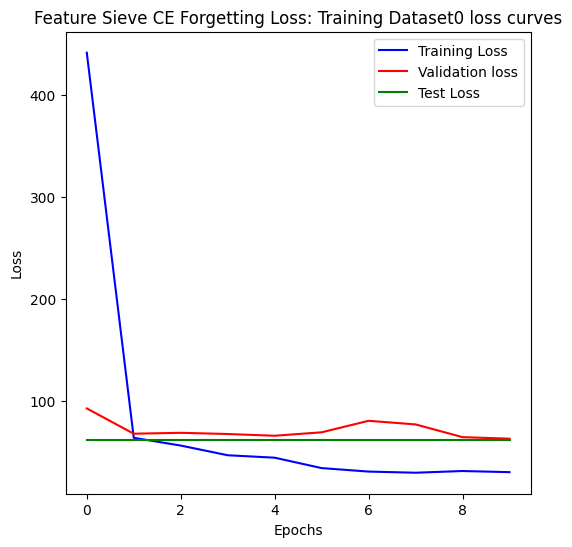

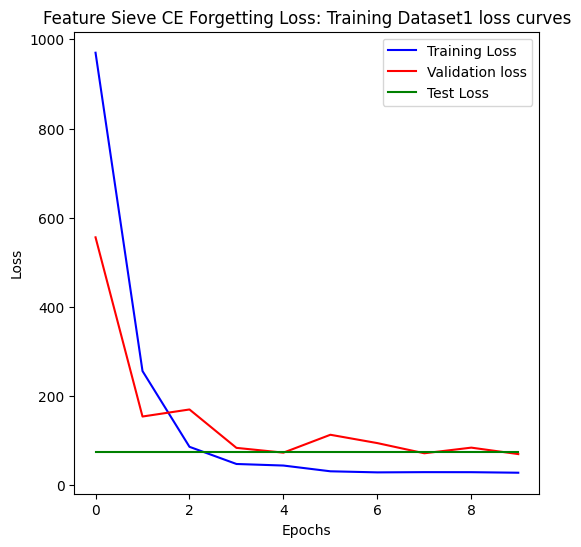

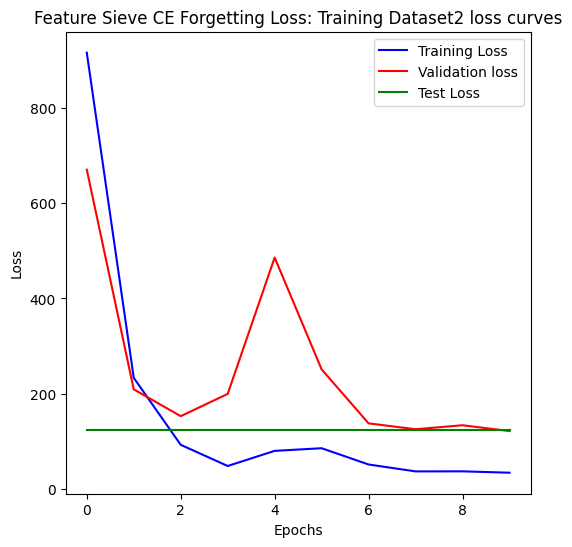

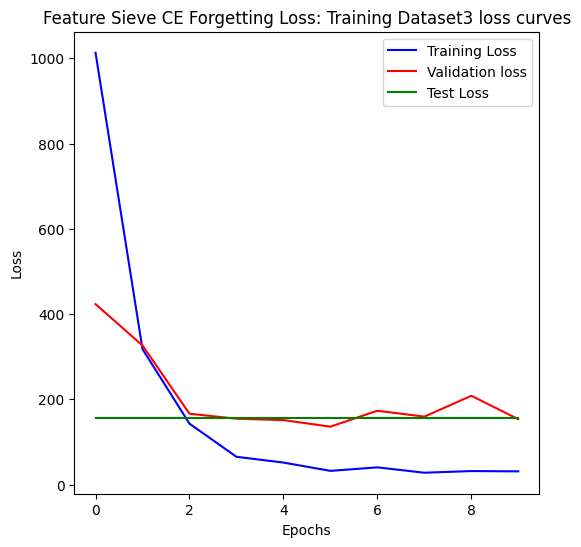

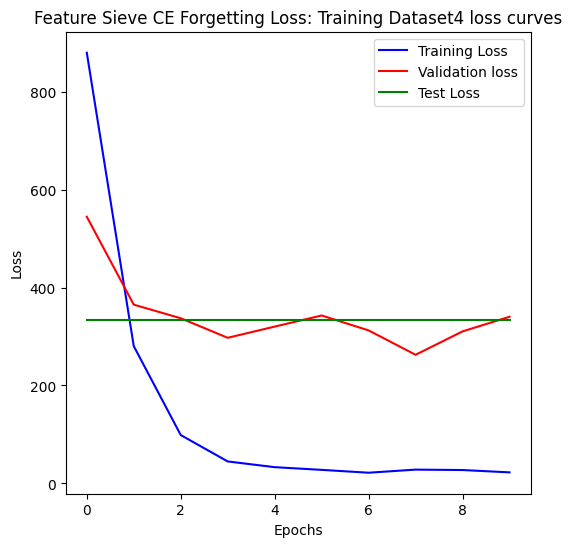

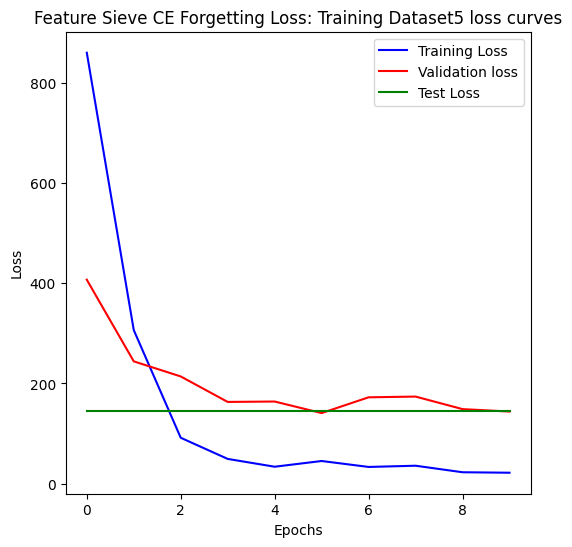

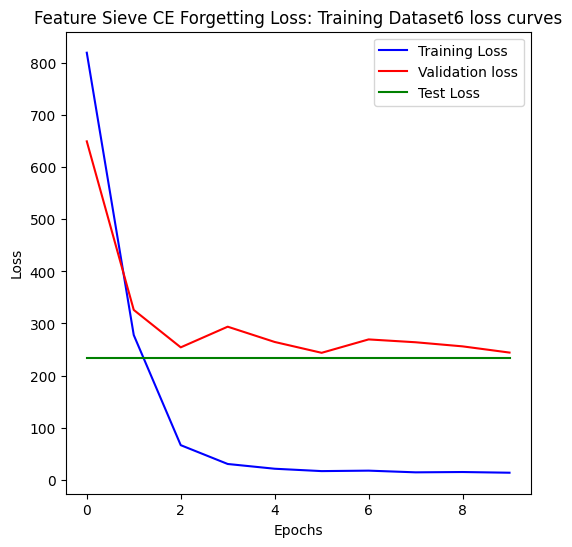

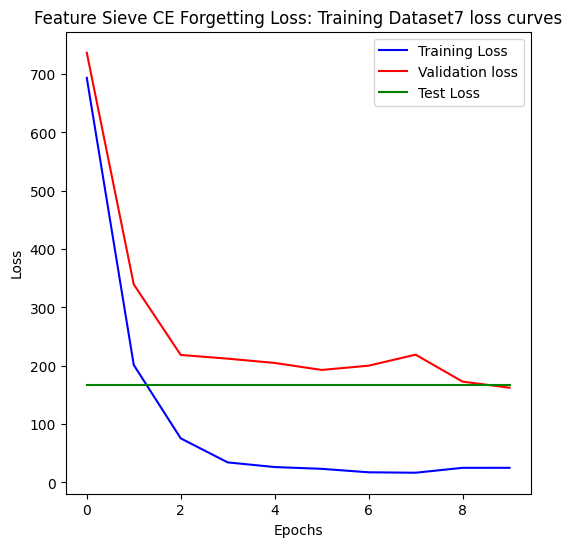

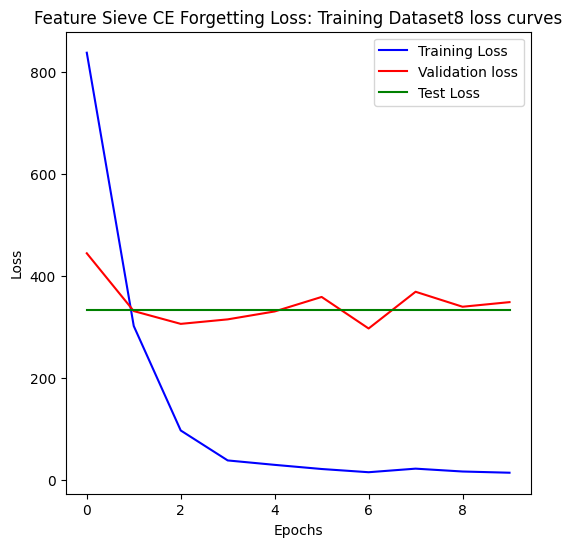

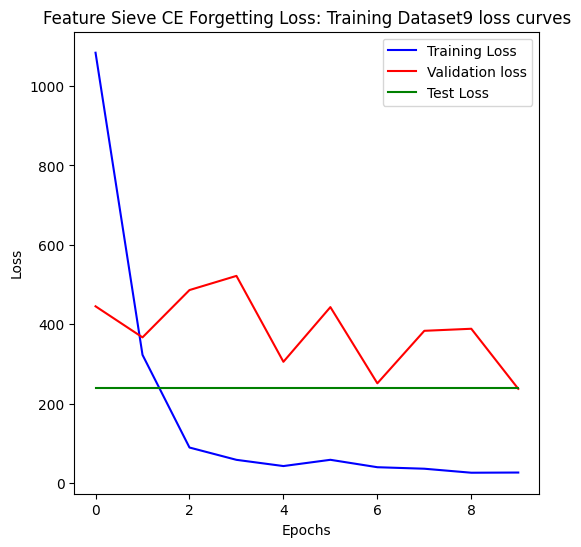

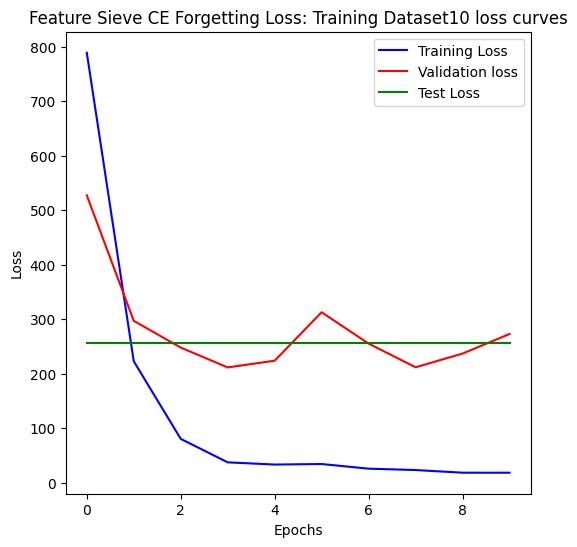

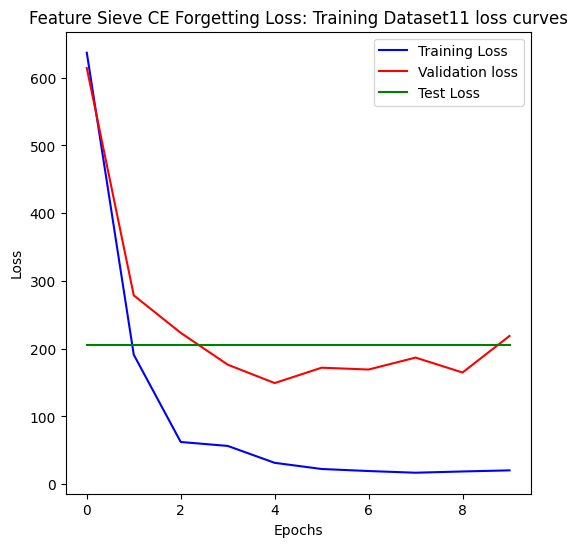

In [66]:
# plotting loss curves
for i in range(len(fs_ce_tlosses)):
    plot_loss_curves(fs_ce_tlosses[i], fs_ce_vlosses[i], fs_ce_tst_losses[i], epochs = 10, model_name=f"Feature Sieve CE Forgetting Loss: Training Dataset{i}")

#### 4) Ordinal Forgetting loss

In [67]:
class SiFer_ord(nn.Module):
    def __init__(self, block, num_classes, aux_pos = 1, aux_kernels = [128, 128], layers = [3, 4], num_bins = 20):
        super(SiFer_ord, self).__init__()
        self.num_classes = num_classes
        self.aux_pos = aux_pos + 4
        # main network
        network = models.resnet34(weights = 'IMAGENET1K_V1')
        for param in network.parameters():
            param.requires_grad = True
            
        self.layers = nn.ModuleList(list(network.children())[:-1])
        self.layers.append(nn.Linear(512, num_classes))

        # Auxiliary Network
        self.aux_layers = nn.ModuleList([])
        
        self.inplanes = 128
        for kernel_id in range(len(aux_kernels)):
            self.aux_layers.append(self.__make_layer(block, aux_kernels[kernel_id], layers[kernel_id], stride = 2))
            
        self.aux_layers.append(nn.AvgPool2d(7, stride=1, padding=2))
        self.aux_layers.append(nn.Linear(512, num_bins))

        # parameters dict
        self.params = nn.ModuleDict({
            "main" : self.layers,
            "aux"  : self.aux_layers,
            'forget': self.layers[:self.aux_pos]
        })
        
    def forward(self, x):
        # forward for the main network
        outputs_main = []
        
        for layer in self.layers[:-1]:
            x = layer(x)
            outputs_main.append(x)

        x = x.view(x.shape[0], -1)
        x = self.layers[-1](x)
        outputs_main.append(x)

        # forward for the aux network
        aux = outputs_main[self.aux_pos]
        for aux_layer in self.aux_layers[:-1]:
            aux = aux_layer(aux)

        aux = aux.view(aux.shape[0], -1)
        aux = self.aux_layers[-1](aux)
        return x, aux

    def __make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:08<00:00, 24.83s/it]


Test Loss: 139.73419189453125
Group test Loss: 271.35751724243164


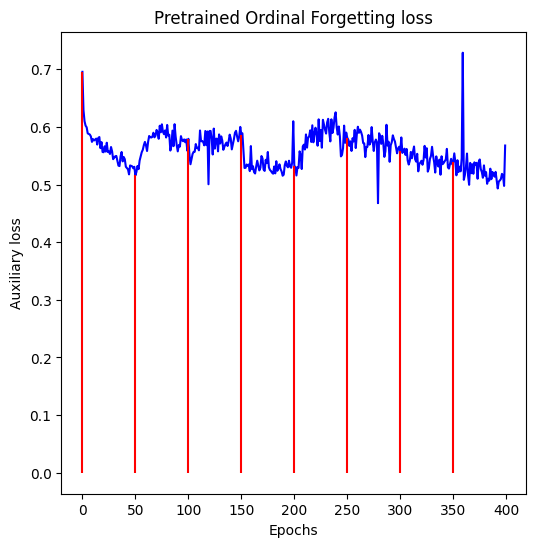

In [68]:
sifer_ord = SiFer_ord(BasicBlock, 1, num_bins = 10, aux_kernels = [128, 128], layers = [5,4]).to(device)
sifer_ord, train_losses, val_losses, aux_losses, forget_losses = train_fs_ord(sifer_ord, train_dataloaders[2], val_dataloader, verbose = False, epochs = 10, forget_iters = 50,num_bins = 10)
test_loss = eval_FSModel(sifer_ord, test_dataloader)
print(f"Test Loss: {test_loss}")
group_eval_fs(sifer_ord, group_test_dataloaders)

plot_aux_losses(aux_losses, model_name = "Pretrained Ordinal Forgetting loss", forget_iters = 50)

In [69]:
# Hyper parameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}] Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ord(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ord(model, train_dataloaders[2], val_dataloader, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 5, verbose = False)
            test_loss = eval_FSModel(model, val_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ =group_eval_fs(model, group_val_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins_ord, best_forget_lr_ord, best_forget_iter_ord = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters:")
print(f"Best num_bins : {num_bins[best_num_bins_ord]} Best Forget LR: {forget_lrs[best_forget_lr_ord]} Best Forget Iter: {forget_iters[best_forget_iter_ord]}")
print("Group Loss Hyperparameters: ")
print(f"Best num_bins : {num_bins[best_num_bins_ord_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ord_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ord_grp]}")

[1/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


Test Loss: 208.2866973876953
Group test Loss: 203.24664497375488
[2/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.66s/it]


Test Loss: 159.52601623535156
Group test Loss: 215.05586051940918
[3/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 123.14997100830078
Group test Loss: 220.39383697509766
[4/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.64s/it]


Test Loss: 145.49575805664062
Group test Loss: 201.67431640625
[5/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 393.37548828125
Group test Loss: 337.0445671081543
[6/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.63s/it]


Test Loss: 262.4633483886719
Group test Loss: 258.1832504272461
[7/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 139.13145446777344
Group test Loss: 225.4686985015869
[8/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.71s/it]


Test Loss: 129.24703979492188
Group test Loss: 198.38570022583008
[9/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 330.9016418457031
Group test Loss: 855.2982368469238
[10/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.64s/it]


Test Loss: 312.62713623046875
Group test Loss: 319.2177276611328
[11/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.20s/it]


Test Loss: 153.69024658203125
Group test Loss: 292.48937606811523
[12/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 214.100830078125
Group test Loss: 406.2905044555664
[13/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.04s/it]


Test Loss: 145.5357208251953
Group test Loss: 228.62219619750977
[14/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 182.39520263671875
Group test Loss: 182.6428108215332
[15/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


Test Loss: 133.05807495117188
Group test Loss: 245.66883277893066
[16/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.81s/it]


Test Loss: 130.984130859375
Group test Loss: 194.9007453918457
[17/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 148.90151977539062
Group test Loss: 276.0785732269287
[18/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 184.24510192871094
Group test Loss: 228.70117950439453
[19/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 119.42105865478516
Group test Loss: 236.33890914916992
[20/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.60s/it]


Test Loss: 142.13787841796875
Group test Loss: 207.40128707885742
[21/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 243.91981506347656
Group test Loss: 311.78271865844727
[22/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.75s/it]


Test Loss: 236.942626953125
Group test Loss: 386.2094306945801
[23/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.09s/it]


Test Loss: 192.49668884277344
Group test Loss: 225.33419609069824
[24/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.72s/it]


Test Loss: 419.84857177734375
Group test Loss: 336.62513732910156
[25/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 136.416748046875
Group test Loss: 194.70832633972168
[26/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.74s/it]


Test Loss: 171.56996154785156
Group test Loss: 334.3140506744385
[27/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.22s/it]


Test Loss: 131.86843872070312
Group test Loss: 194.32488441467285
[28/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.84s/it]


Test Loss: 134.18234252929688
Group test Loss: 256.3147678375244
[29/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.22s/it]


Test Loss: 139.44879150390625
Group test Loss: 232.81992530822754
[30/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 160.65611267089844
Group test Loss: 276.7740840911865
[31/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.11s/it]


Test Loss: 141.7925262451172
Group test Loss: 217.54363822937012
[32/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.70s/it]


Test Loss: 138.36636352539062
Group test Loss: 169.30085372924805
[33/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 246.6762237548828
Group test Loss: 275.78318786621094
[34/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.62s/it]


Test Loss: 241.38735961914062
Group test Loss: 362.7579116821289
[35/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.17s/it]


Test Loss: 263.3401794433594
Group test Loss: 288.8796272277832
[36/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.67s/it]


Test Loss: 178.6442108154297
Group test Loss: 271.4538116455078
[37/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 120.98641204833984
Group test Loss: 176.47463989257812
[38/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.76s/it]


Test Loss: 154.17367553710938
Group test Loss: 216.7150173187256
[39/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.20s/it]


Test Loss: 136.1897735595703
Group test Loss: 187.31716537475586
[40/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.82s/it]


Test Loss: 143.20974731445312
Group test Loss: 208.85589790344238
[41/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.18s/it]


Test Loss: 235.4270782470703
Group test Loss: 407.8345260620117
[42/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.81s/it]


Test Loss: 164.2864227294922
Group test Loss: 263.57378005981445
[43/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 150.52096557617188
Group test Loss: 210.23192405700684
[44/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.73s/it]


Test Loss: 198.59764099121094
Group test Loss: 460.76451110839844
[45/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 292.7398681640625
Group test Loss: 683.6147956848145
[46/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.01s/it]


Test Loss: 241.60470581054688
Group test Loss: 470.83997344970703
[47/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.21s/it]


Test Loss: 194.574951171875
Group test Loss: 221.23329544067383
[48/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.68s/it]


Test Loss: 217.52330017089844
Group test Loss: 310.547794342041
[49/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.24s/it]


Test Loss: 159.6380615234375
Group test Loss: 274.2490520477295
[50/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.64s/it]


Test Loss: 168.5287628173828
Group test Loss: 254.1641330718994
[51/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.12s/it]


Test Loss: 159.979736328125
Group test Loss: 173.9206886291504
[52/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]


Test Loss: 123.06110382080078
Group test Loss: 171.80377006530762
[53/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.24s/it]


Test Loss: 170.17886352539062
Group test Loss: 201.53799057006836
[54/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.94s/it]


Test Loss: 150.02528381347656
Group test Loss: 240.8327293395996
[55/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.38s/it]


Test Loss: 133.5050811767578
Group test Loss: 209.42987442016602
[56/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.95s/it]


Test Loss: 176.54551696777344
Group test Loss: 206.35494804382324
[57/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.36s/it]


Test Loss: 247.93142700195312
Group test Loss: 314.63612365722656
[58/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.85s/it]


Test Loss: 217.2327880859375
Group test Loss: 418.8129005432129
[59/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.26s/it]


Test Loss: 175.95166015625
Group test Loss: 301.09996795654297
[60/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.86s/it]


Test Loss: 212.8190460205078
Group test Loss: 369.0014533996582
[61/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]


Test Loss: 151.87159729003906
Group test Loss: 301.83700942993164
[62/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.81s/it]


Test Loss: 114.1812515258789
Group test Loss: 139.70770835876465
[63/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.25s/it]


Test Loss: 153.20779418945312
Group test Loss: 244.06498527526855
[64/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.89s/it]


Test Loss: 130.103271484375
Group test Loss: 233.90771675109863
[65/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.34s/it]


Test Loss: 140.2132568359375
Group test Loss: 243.00343704223633
[66/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.98s/it]


Test Loss: 145.49867248535156
Group test Loss: 253.6779079437256
[67/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.25s/it]


Test Loss: 133.0803985595703
Group test Loss: 259.9093017578125
[68/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.75s/it]


Test Loss: 134.36648559570312
Group test Loss: 272.3062858581543
[69/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.16s/it]


Test Loss: 226.84754943847656
Group test Loss: 248.13698196411133
[70/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.59s/it]


Test Loss: 228.5416259765625
Group test Loss: 522.7605113983154
[71/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.21s/it]


Test Loss: 184.61448669433594
Group test Loss: 244.5463809967041
[72/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.65s/it]


Test Loss: 197.17054748535156
Group test Loss: 346.2513084411621
[73/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


Test Loss: 151.59933471679688
Group test Loss: 289.6311378479004
[74/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.78s/it]


Test Loss: 133.4616241455078
Group test Loss: 197.4195785522461
[75/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.13s/it]


Test Loss: 146.55198669433594
Group test Loss: 271.457950592041
[76/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.75s/it]


Test Loss: 141.76730346679688
Group test Loss: 226.07926750183105
[77/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.15s/it]


Test Loss: 184.5406494140625
Group test Loss: 414.727445602417
[78/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.69s/it]


Test Loss: 171.84640502929688
Group test Loss: 213.70719528198242
[79/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.06s/it]


Test Loss: 197.46566772460938
Group test Loss: 232.46658897399902
[80/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.73s/it]


Test Loss: 166.83187866210938
Group test Loss: 236.090576171875
[81/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.19s/it]


Test Loss: 383.36077880859375
Group test Loss: 397.8200912475586
[82/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.58s/it]


Test Loss: 235.8465576171875
Group test Loss: 361.54082107543945
[83/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.24s/it]


Test Loss: 184.509033203125
Group test Loss: 301.05543518066406
[84/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.27s/it]


Test Loss: 188.6797332763672
Group test Loss: 459.5004577636719
[85/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.56s/it]


Test Loss: 160.3726348876953
Group test Loss: 298.97518730163574
[86/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.23s/it]


Test Loss: 151.4473876953125
Group test Loss: 224.51981353759766
[87/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.47s/it]


Test Loss: 170.88760375976562
Group test Loss: 249.22949981689453
[88/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.02s/it]


Test Loss: 132.9310760498047
Group test Loss: 274.8113441467285
[89/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.28s/it]


Test Loss: 143.68740844726562
Group test Loss: 302.08807373046875
[90/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.76s/it]


Test Loss: 166.18435668945312
Group test Loss: 292.7531280517578
[91/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.23s/it]


Test Loss: 127.70470428466797
Group test Loss: 187.03133010864258
[92/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.01s/it]


Test Loss: 118.95963287353516
Group test Loss: 172.53922271728516
[93/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.45s/it]


Test Loss: 244.9756317138672
Group test Loss: 415.3066940307617
[94/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.20s/it]


Test Loss: 244.4291229248047
Group test Loss: 275.57830810546875
[95/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.55s/it]


Test Loss: 219.0908966064453
Group test Loss: 511.22127532958984
[96/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:10<00:00, 26.07s/it]


Test Loss: 152.5395050048828
Group test Loss: 262.11465644836426
Test Loss Hyperparameters:
Best num_bins : 75 Best Forget LR: 0.0005 Best Forget Iter: 5
Group Loss Hyperparameters: 
Best num_bins : 75 Best Forget LR: 0.0005 Best Forget Iter: 5


In [80]:
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_tst_losses = []
fs_ord_grp_tst_losses = []
fs_ord_grp_tst_losses_t = []
fs_ord_grp_wise_losses = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
fs_ord_grp_wise_losses_t = {'m yng': [],
                  'm old': [],
                  'f yng': [],
                  'f old': []}
#####
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_num_bins_ord_grp = num_bins.index(30)
best_forget_iter_ord_grp = forget_iters.index(2)
best_forget_lr_ord_grp = forget_lrs.index(0.0005)
#####

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(train_dataloaders)):
    if i > 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] Training dataset {i - 1}")
    elif i == 1:
        print(f"[{i + 1}/{len(train_dataloaders)}] No Bias Dataloader")
    else:
        print(f"[{i + 1}/{len(train_dataloaders)}] Complete Dataloader")
        
    model = SiFer_ord(BasicBlock, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[best_num_bins_ord]).to(device)
    model, train_losses, val_losses, _,_ = train_fs_ord(model, train_dataloaders[i], val_dataloader, num_bins = num_bins[best_num_bins_ord], forget_iters = best_forget_iter_ord, lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ord]], verbose = False, epochs = 10)
    test_loss = eval_FSModel(model, test_dataloader)
    print(f"Test Loss: {test_loss}")
    
    group_loss, groups = group_eval_fs(model, group_test_dataloaders)
    group_loss_t, groups_t = group_eval_fs(model, train_group_dataloaders[i])

    fs_ord_tlosses.append(train_losses)
    fs_ord_vlosses.append(val_losses)
    fs_ord_tst_losses.append(test_loss)
    fs_ord_grp_tst_losses.append(group_loss)
    fs_ord_grp_tst_losses_t.append(group_loss_t)

    fs_ord_grp_wise_losses['m yng'].append(groups['m yng'])
    fs_ord_grp_wise_losses['m old'].append(groups['m old'])
    fs_ord_grp_wise_losses['f yng'].append(groups['f yng'])
    fs_ord_grp_wise_losses['f old'].append(groups['f old'])

    fs_ord_grp_wise_losses_t['m yng'].append(groups_t['m yng'])
    fs_ord_grp_wise_losses_t['m old'].append(groups_t['m old'])
    fs_ord_grp_wise_losses_t['f yng'].append(groups_t['f yng'])
    fs_ord_grp_wise_losses_t['f old'].append(groups_t['f old'])

    torch.save(model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Model saved to ./Models/fs_ord_model{i}.pth")

[1/12] Complete Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:35<00:00, 69.59s/it]


Test Loss: 54.796897888183594
Group test Loss: 79.8861141204834
Group test Loss: 19.469815254211426
Model saved to ./Models/fs_ord_model0.pth
[2/12] No Bias Dataloader


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.11s/it]


Test Loss: 84.70575714111328
Group test Loss: 146.12118339538574
Group test Loss: 33.4496693611145
Model saved to ./Models/fs_ord_model1.pth
[3/12] Training dataset 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.22s/it]


Test Loss: 141.15792846679688
Group test Loss: 171.63922691345215
Group test Loss: 29.983381907145183
Model saved to ./Models/fs_ord_model2.pth
[4/12] Training dataset 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:54<00:00, 29.46s/it]


Test Loss: 158.70310974121094
Group test Loss: 242.19245529174805
Group test Loss: 40.912535667419434
Model saved to ./Models/fs_ord_model3.pth
[5/12] Training dataset 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.24s/it]


Test Loss: 284.3282470703125
Group test Loss: 259.21949768066406
Group test Loss: 14.083045959472656
Model saved to ./Models/fs_ord_model4.pth
[6/12] Training dataset 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.19s/it]


Test Loss: 147.64889526367188
Group test Loss: 181.13835906982422
Group test Loss: 24.655920664469402
Model saved to ./Models/fs_ord_model5.pth
[7/12] Training dataset 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.29s/it]


Test Loss: 237.05621337890625
Group test Loss: 392.00775146484375
Group test Loss: 9.230424880981445
Model saved to ./Models/fs_ord_model6.pth
[8/12] Training dataset 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.10s/it]


Test Loss: 160.931396484375
Group test Loss: 287.57358741760254
Group test Loss: 14.920888106028238
Model saved to ./Models/fs_ord_model7.pth
[9/12] Training dataset 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.05s/it]


Test Loss: 313.7450256347656
Group test Loss: 394.61280059814453
Group test Loss: 21.169421831766766
Model saved to ./Models/fs_ord_model8.pth
[10/12] Training dataset 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.05s/it]


Test Loss: 365.87078857421875
Group test Loss: 307.9831237792969
Group test Loss: 57.50937525431315
Model saved to ./Models/fs_ord_model9.pth
[11/12] Training dataset 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:51<00:00, 29.11s/it]


Test Loss: 222.90078735351562
Group test Loss: 285.9107666015625
Group test Loss: 17.656015078226726
Model saved to ./Models/fs_ord_model10.pth
[12/12] Training dataset 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:53<00:00, 29.33s/it]


Test Loss: 153.1453857421875
Group test Loss: 305.64573669433594
Group test Loss: 14.880486806233725
Model saved to ./Models/fs_ord_model11.pth


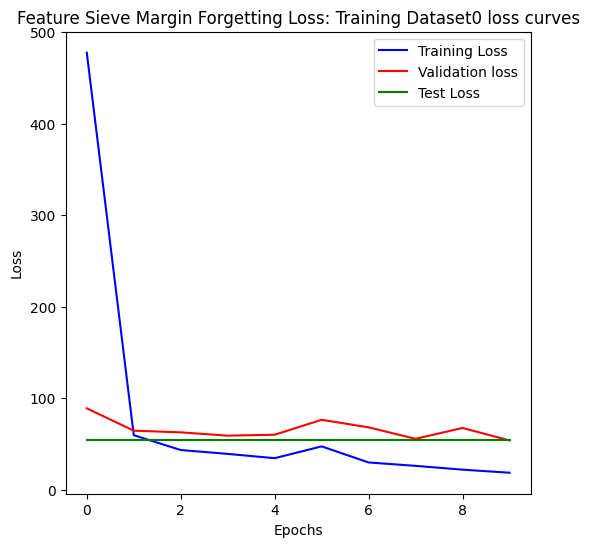

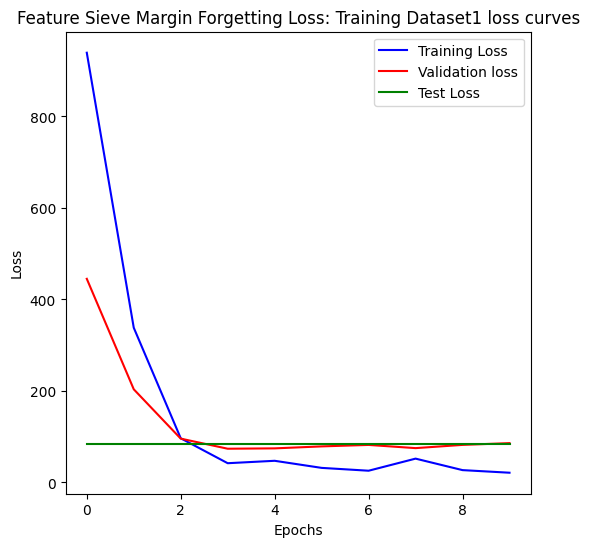

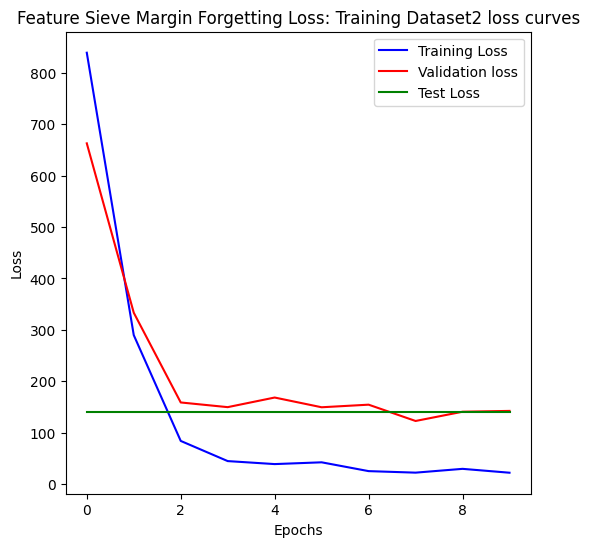

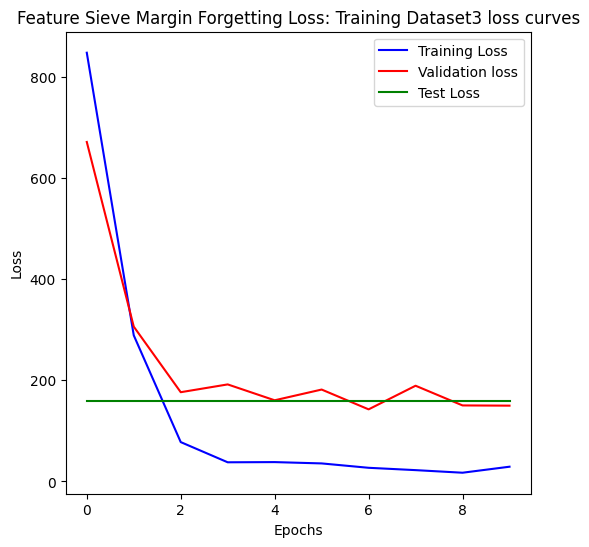

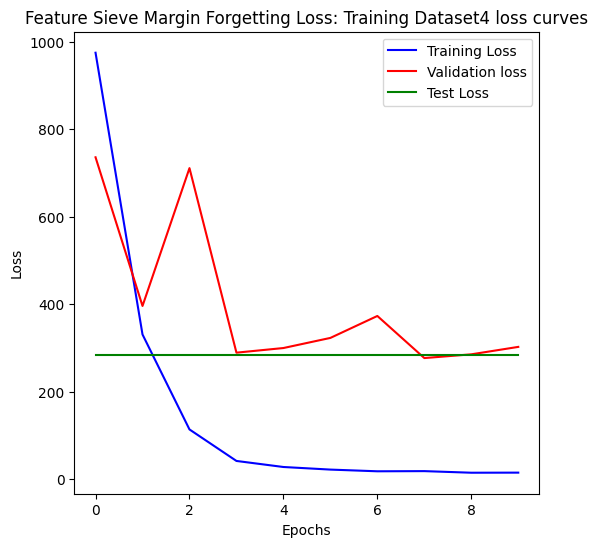

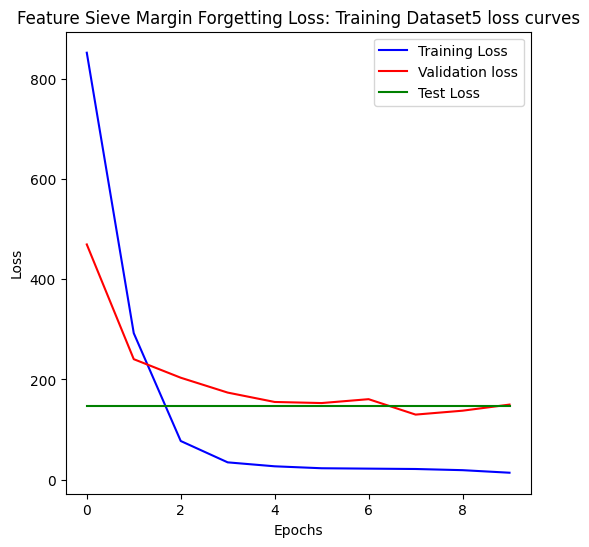

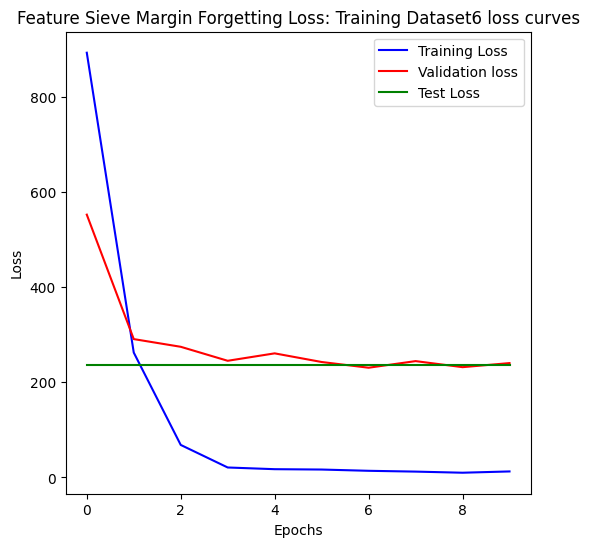

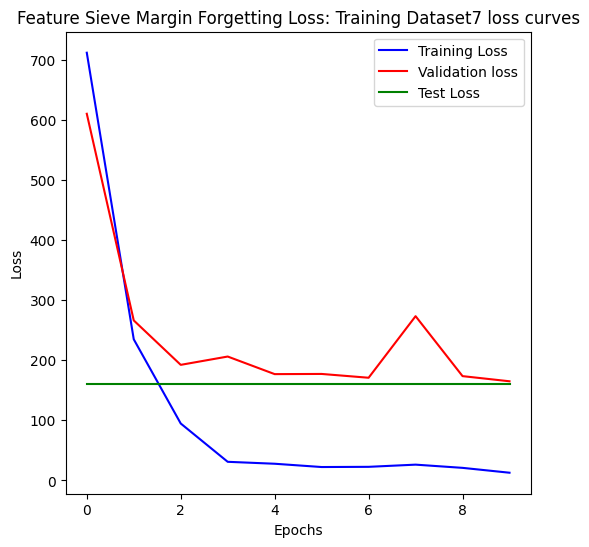

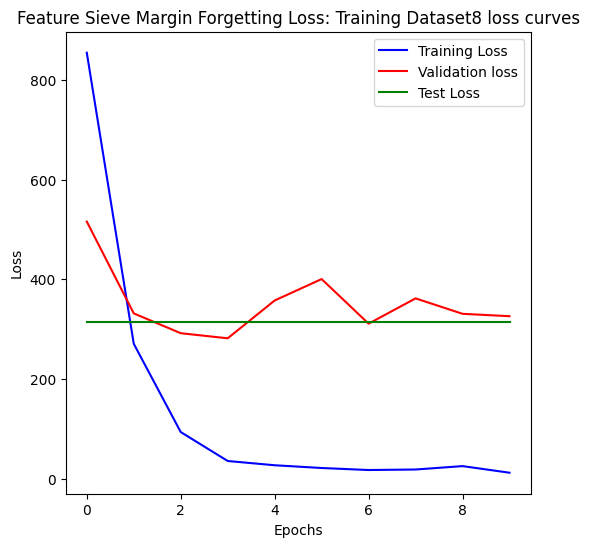

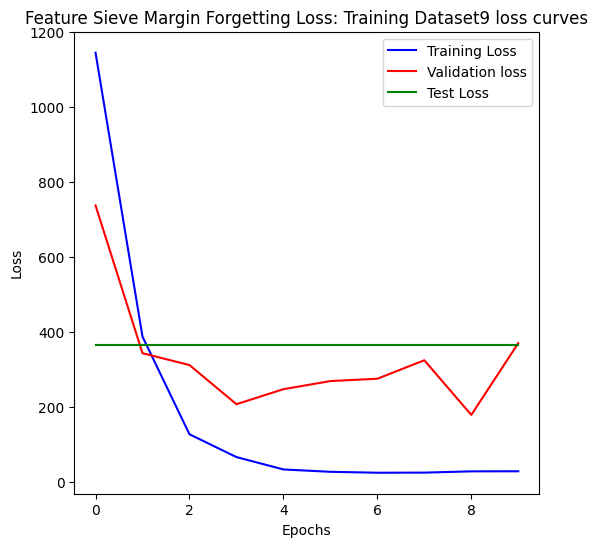

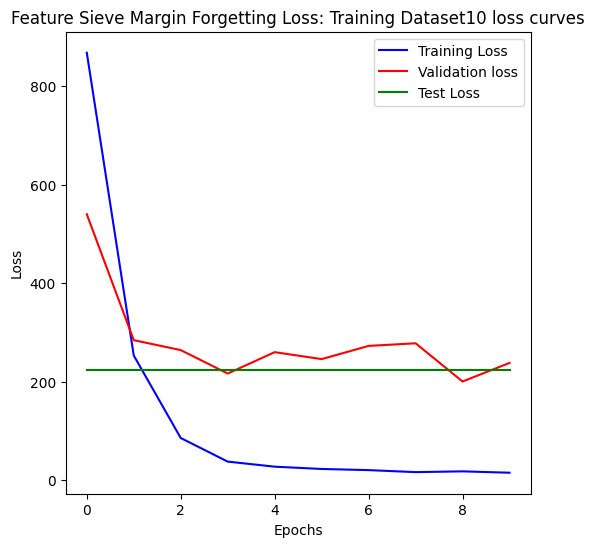

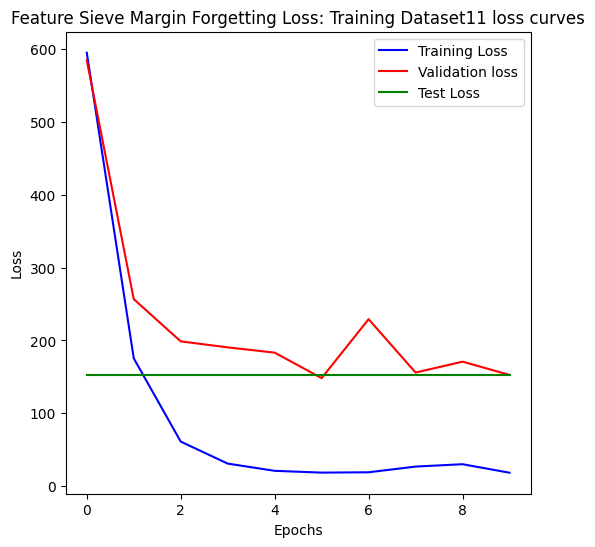

In [81]:
# plotting loss curves
plt.rcParams['figure.figsize'] = (6,6)
for i in range(len(fs_ord_tlosses)):
    plot_loss_curves(fs_ord_tlosses[i], fs_ord_vlosses[i], fs_ord_tst_print(aux.shape, y_ord.shape, x.shape)losses[i], epochs = 10, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

### Visualization of the results

In [82]:
def bar_plot(names, dict_values, xlabel, ylabel, title, name):
    x = np.arange(len(names))
    width = 0.2
    multiplier = 0
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({"font.size": 10})
    fig, ax = plt.subplots(layout="constrained")
    
    for model_type, test_loss in dict_values.items():
        offset = width*multiplier
        rects = ax.bar(x + offset, test_loss, width, label=model_type)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks(x+ width, names)
    ax.legend(loc="upper left")
    plt.title(title)
    # plt.savefig(f"./Outputs/{name}.png")
    plt.show()

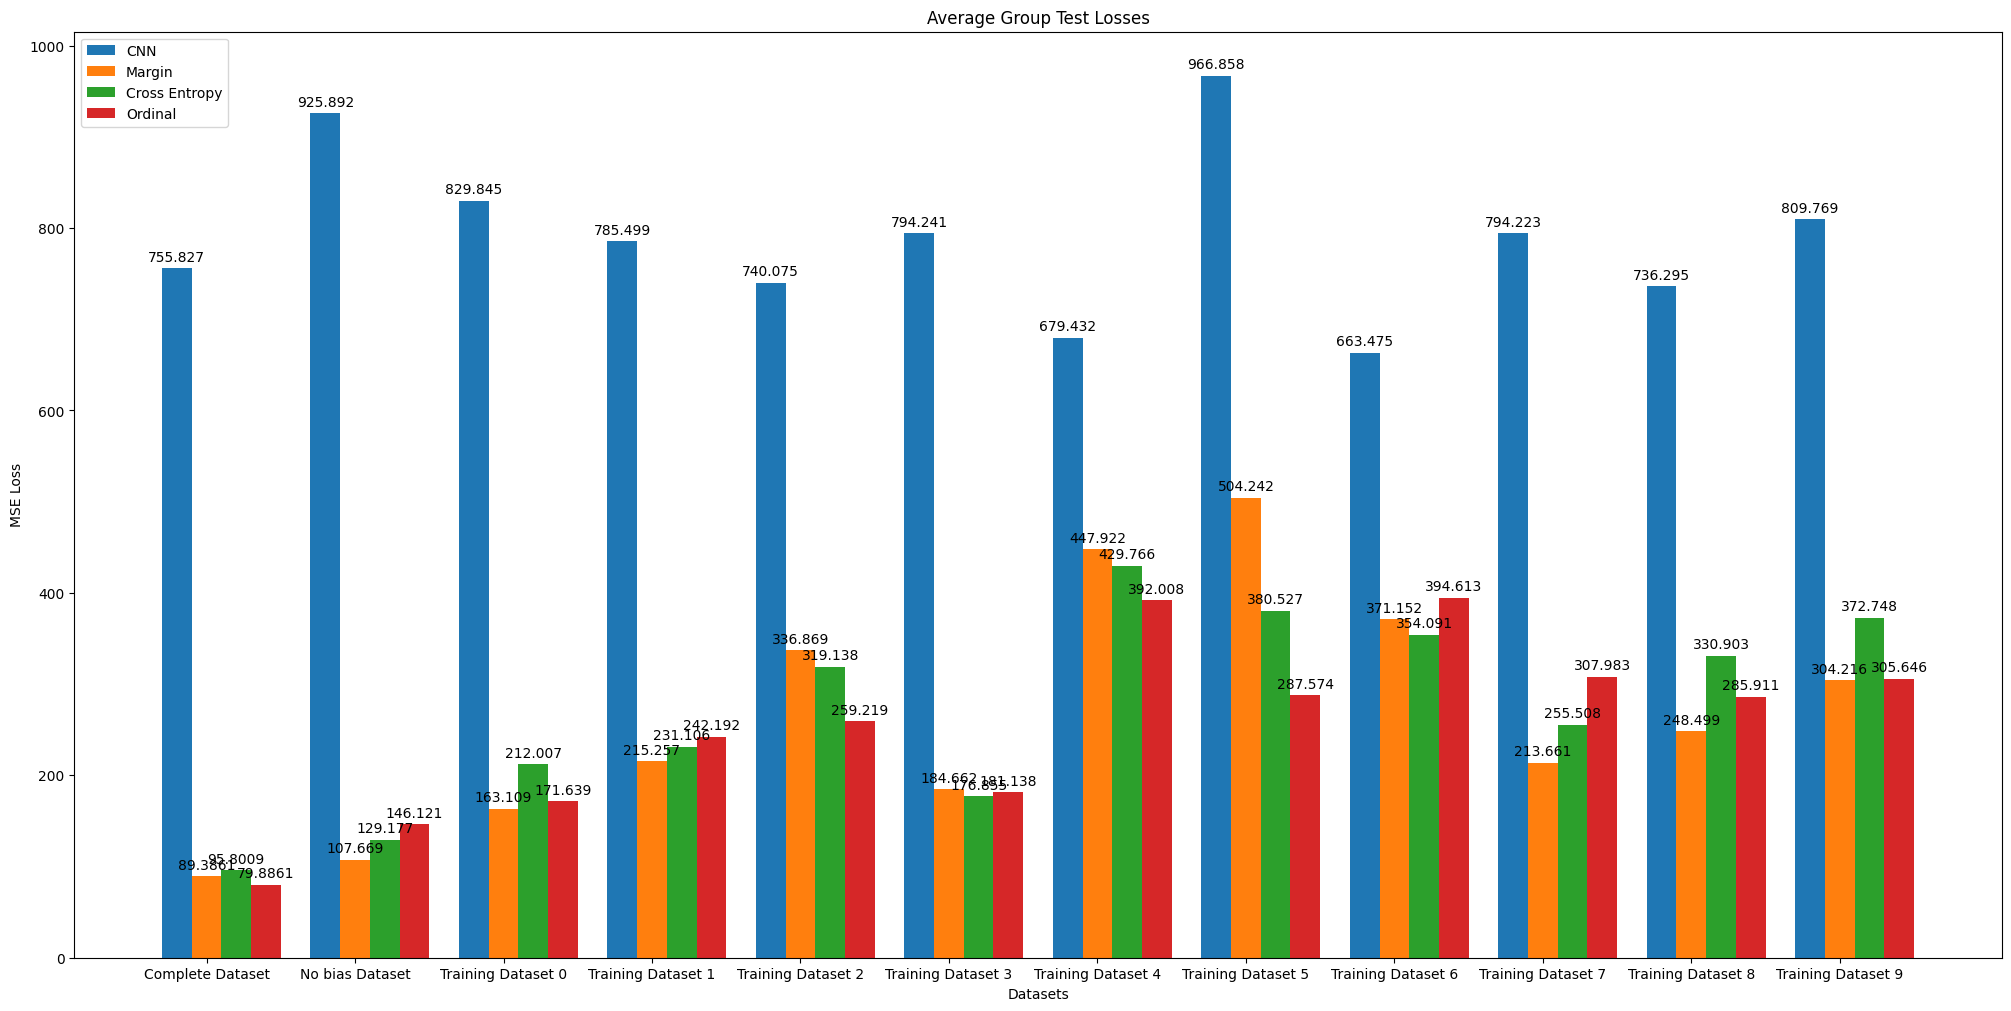

In [83]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": grp_tst_losses,
    "Margin": fs_grp_tst_losses,
    "Cross Entropy": fs_ce_grp_tst_losses,
    "Ordinal": fs_ord_grp_tst_losses
}

bar_plot(datasets, test_losses, 'Datasets', "MSE Loss", "Average Group Test Losses", "Group_test_losses")

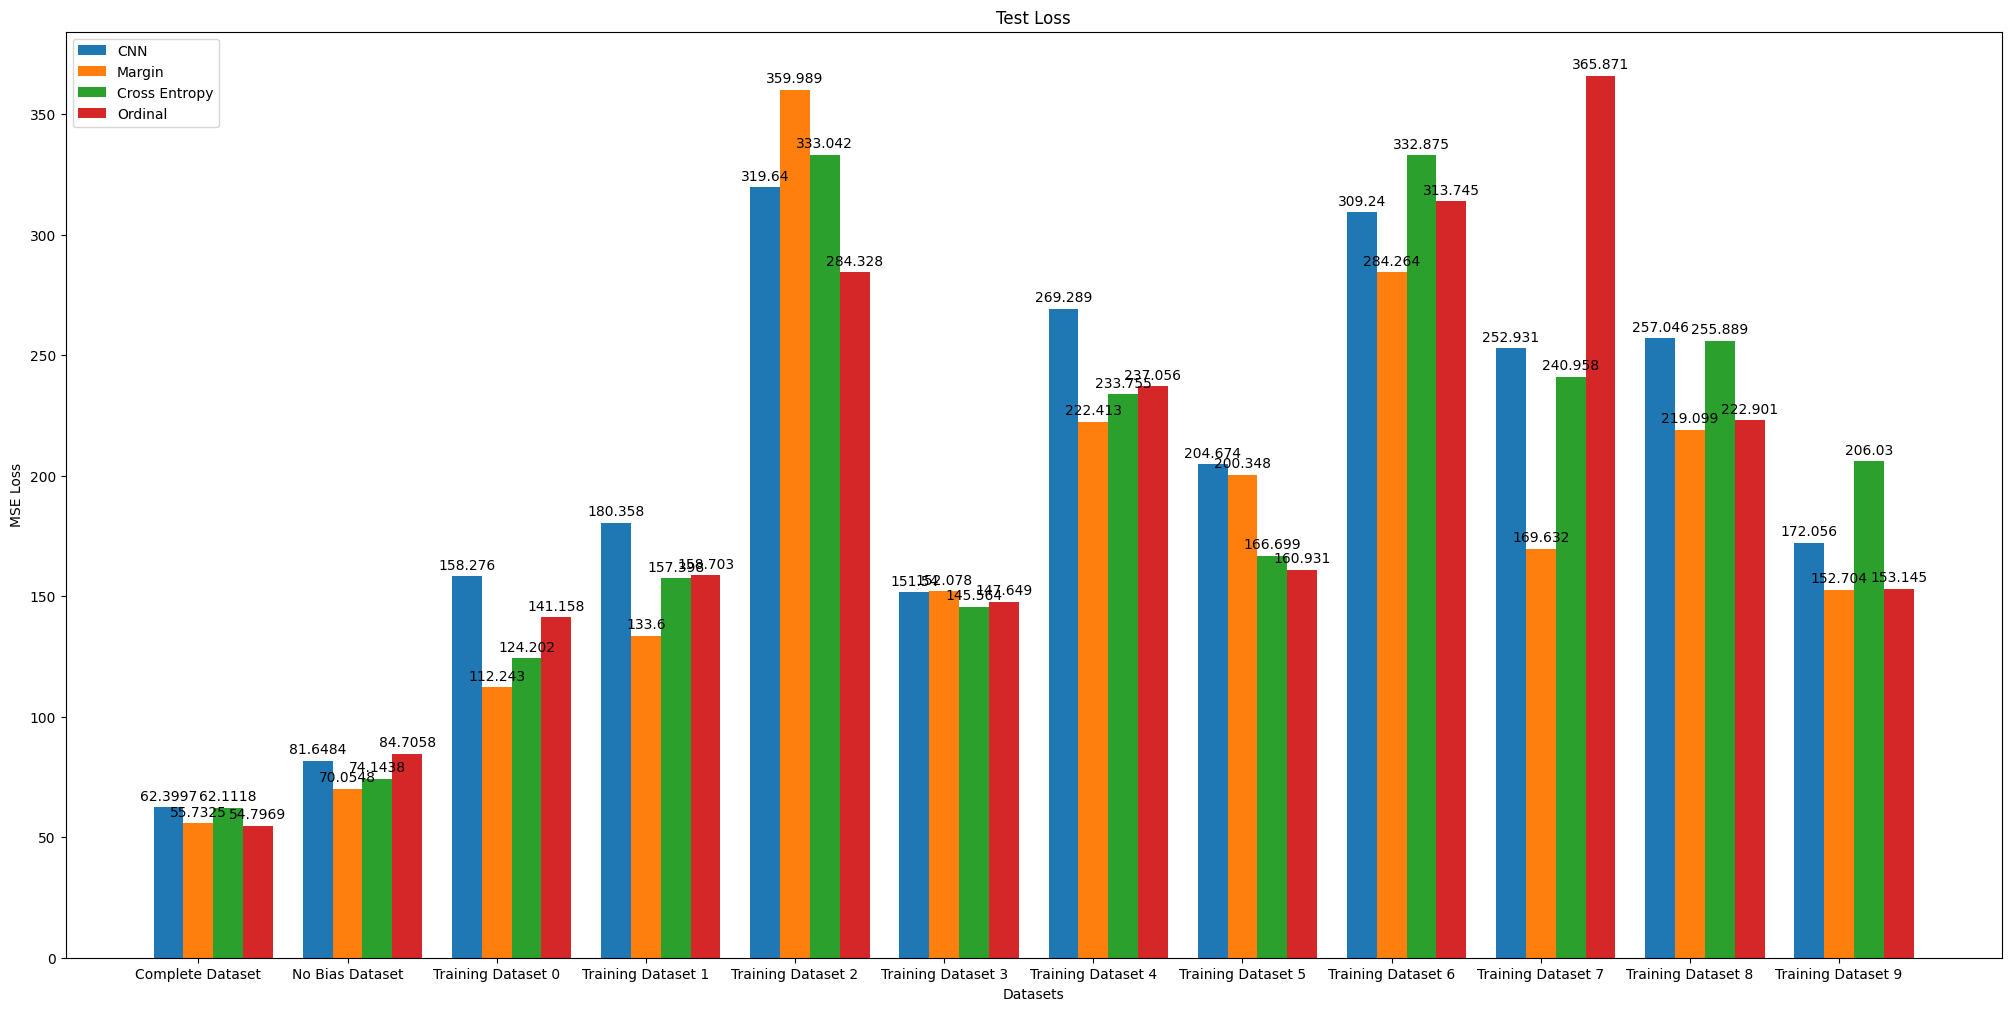

In [84]:
datasets = ["Complete Dataset", "No Bias Dataset"]  + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": tst_losses,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_tst_losses,
    "Ordinal": fs_ord_tst_losses
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Test Loss", "Test_losses")

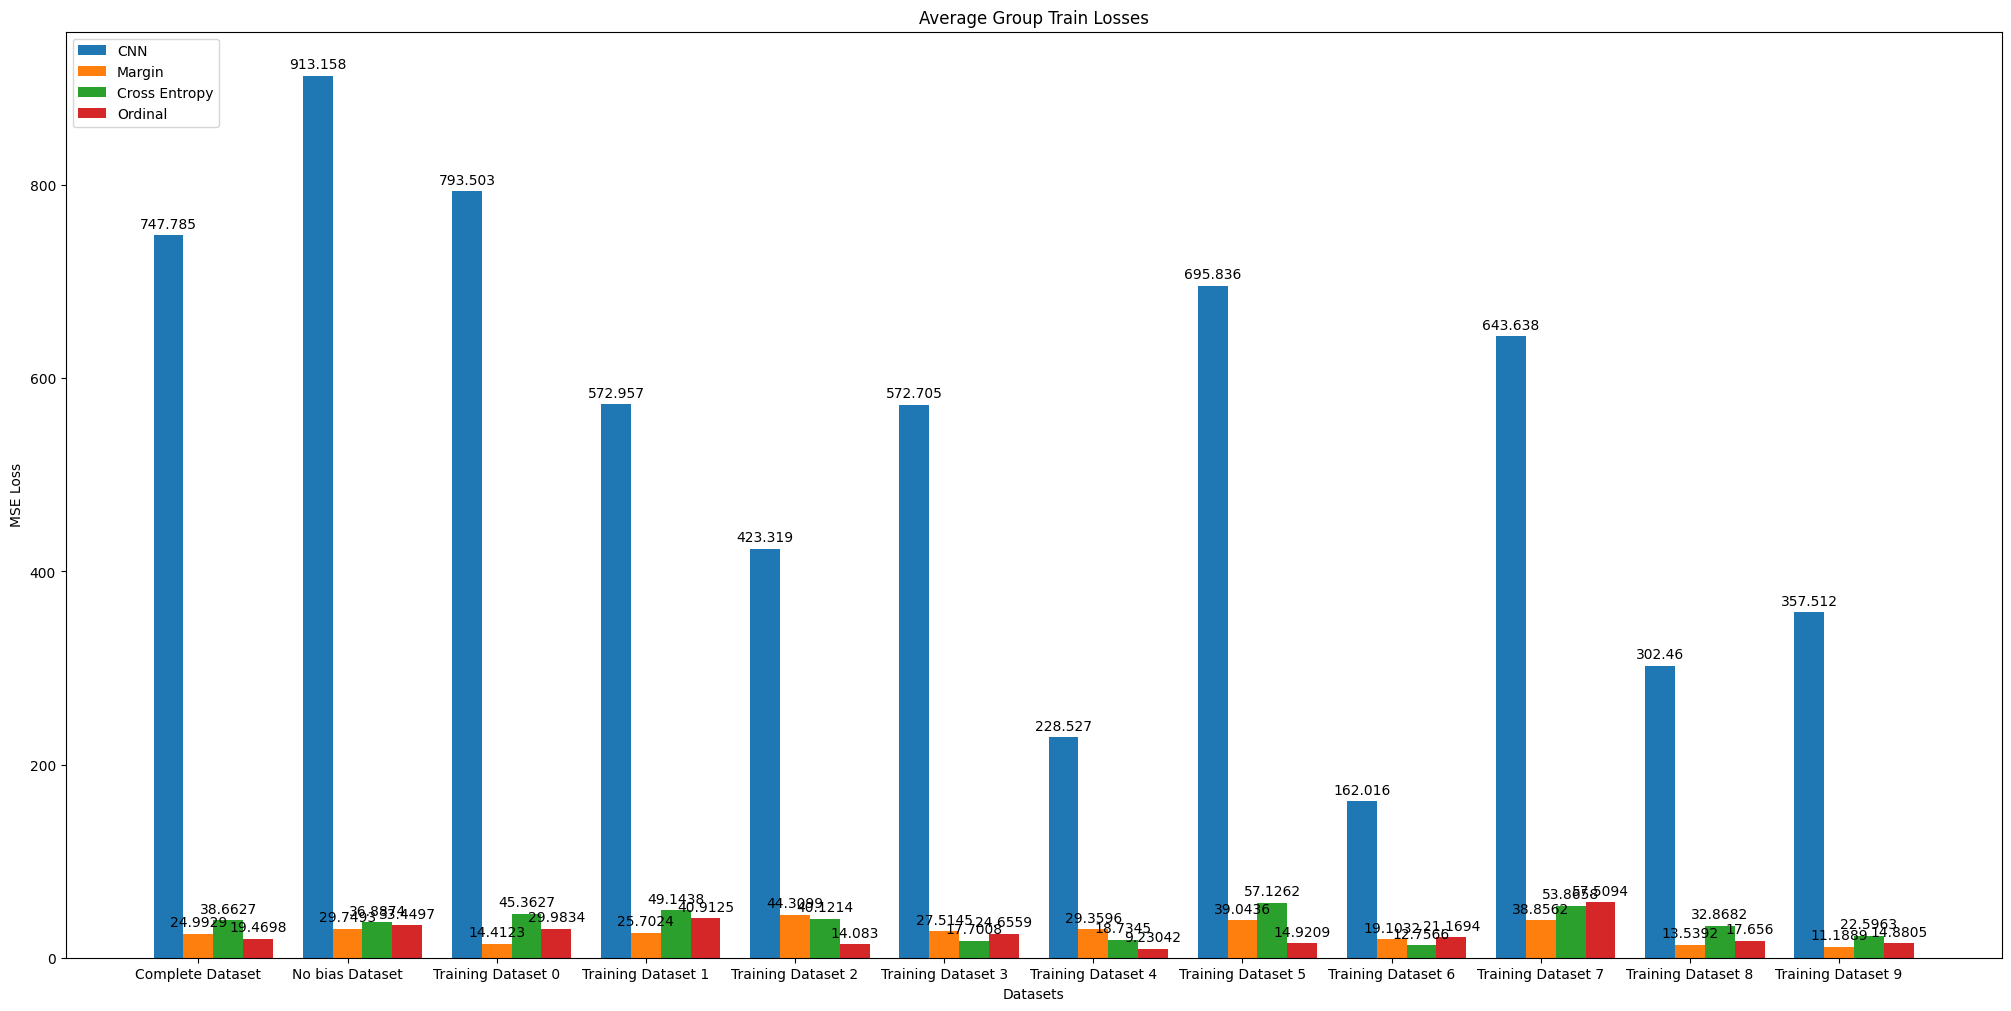

In [85]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
test_losses = {
    "CNN": grp_tst_losses_t,
    "Margin": fs_grp_tst_losses_t,
    "Cross Entropy": fs_ce_grp_tst_losses_t,
    "Ordinal": fs_ord_grp_tst_losses_t
}

bar_plot(datasets, test_losses, 'Datasets', "MSE Loss", "Average Group Train Losses", "Group_train_losses")

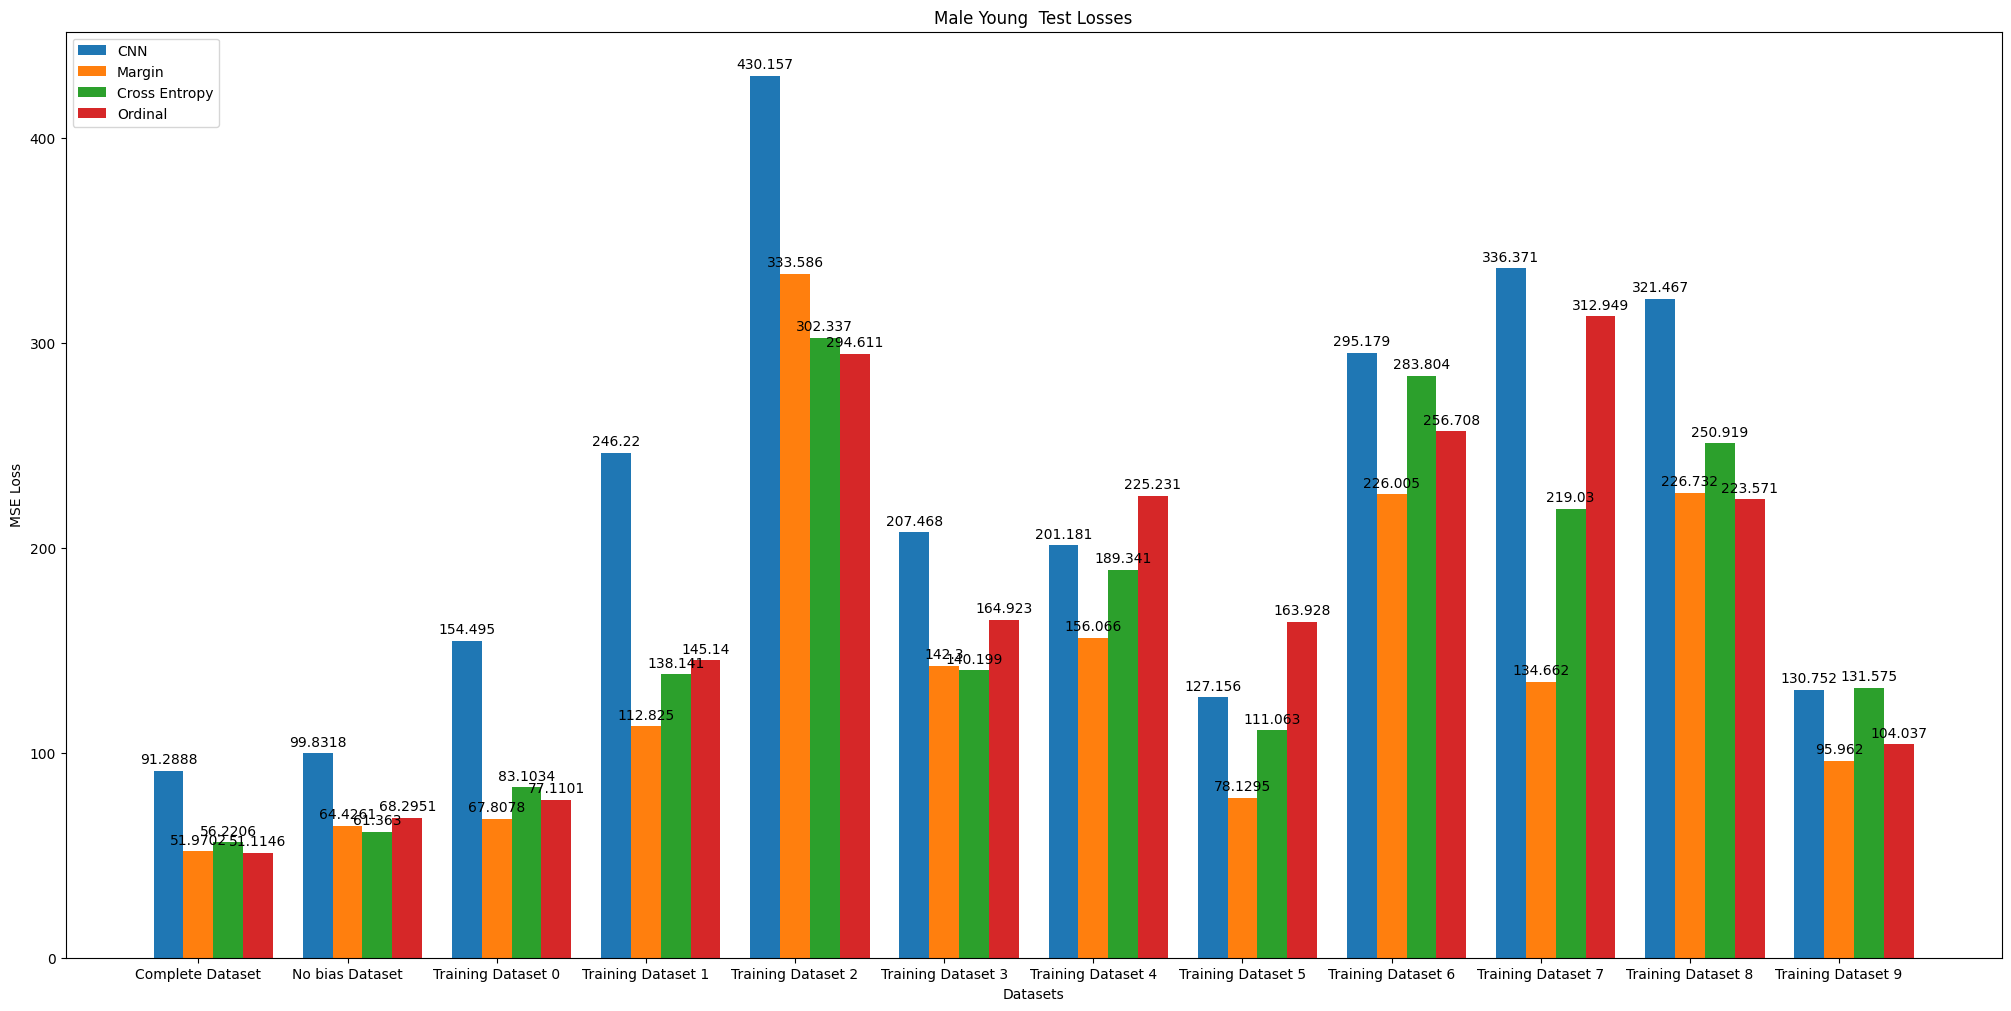

In [86]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
male_yng_test_losses = {
    "CNN": grp_wise_losses["m yng"],
    "Margin": fs_grp_wise_losses["m yng"],
    "Cross Entropy": fs_ce_grp_wise_losses["m yng"],
    "Ordinal": fs_ord_grp_wise_losses["m yng"]
}

bar_plot(datasets, male_yng_test_losses, 'Datasets', "MSE Loss", "Male Young  Test Losses", "male_yng_losses")

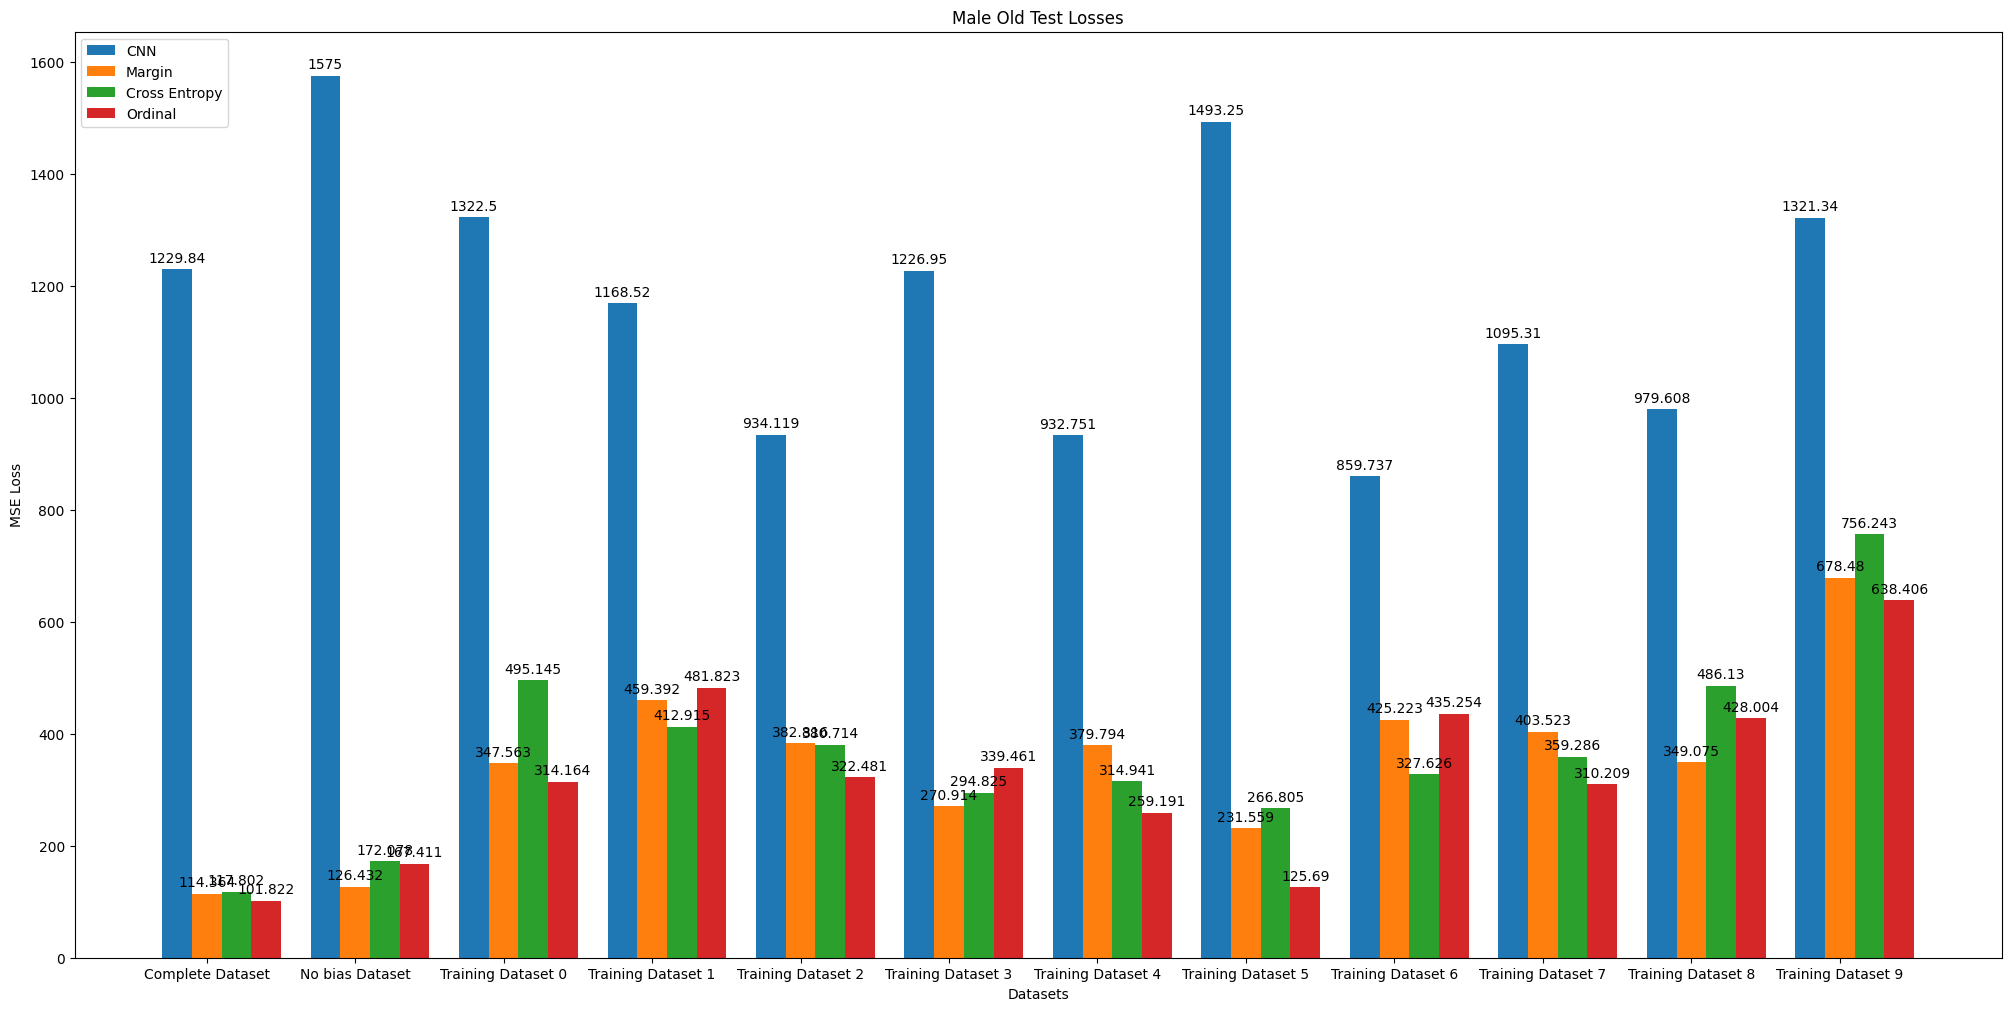

In [87]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
male_old_test_losses = {
    "CNN": grp_wise_losses["m old"],
    "Margin": fs_grp_wise_losses["m old"],
    "Cross Entropy": fs_ce_grp_wise_losses["m old"],
    "Ordinal": fs_ord_grp_wise_losses["m old"]
}

bar_plot(datasets, male_old_test_losses, 'Datasets', "MSE Loss", "Male Old Test Losses", "male_old_losses")

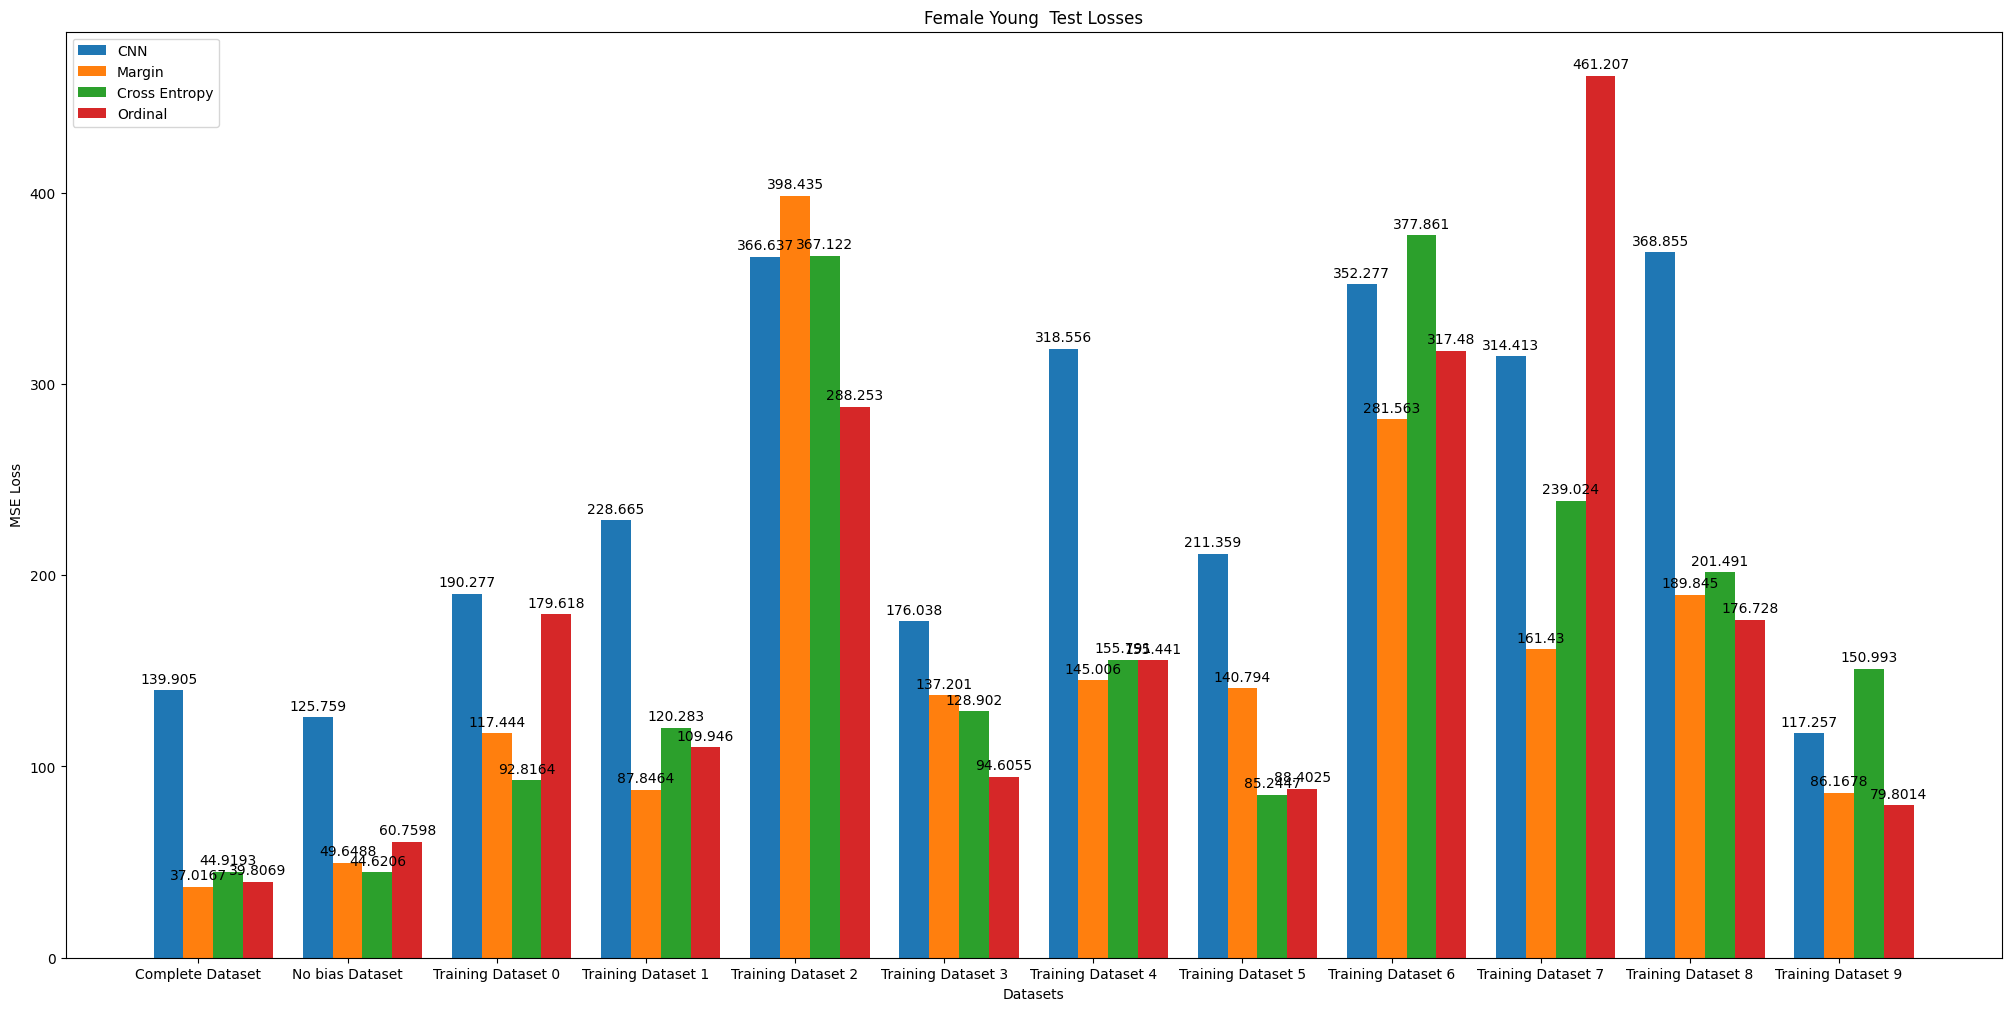

In [88]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
female_yng_test_losses = {
    "CNN": grp_wise_losses["f yng"],
    "Margin": fs_grp_wise_losses["f yng"],
    "Cross Entropy": fs_ce_grp_wise_losses["f yng"],
    "Ordinal": fs_ord_grp_wise_losses["f yng"]
}

bar_plot(datasets, female_yng_test_losses, 'Datasets', "MSE Loss", "Female Young  Test Losses", "female_yng_losses")

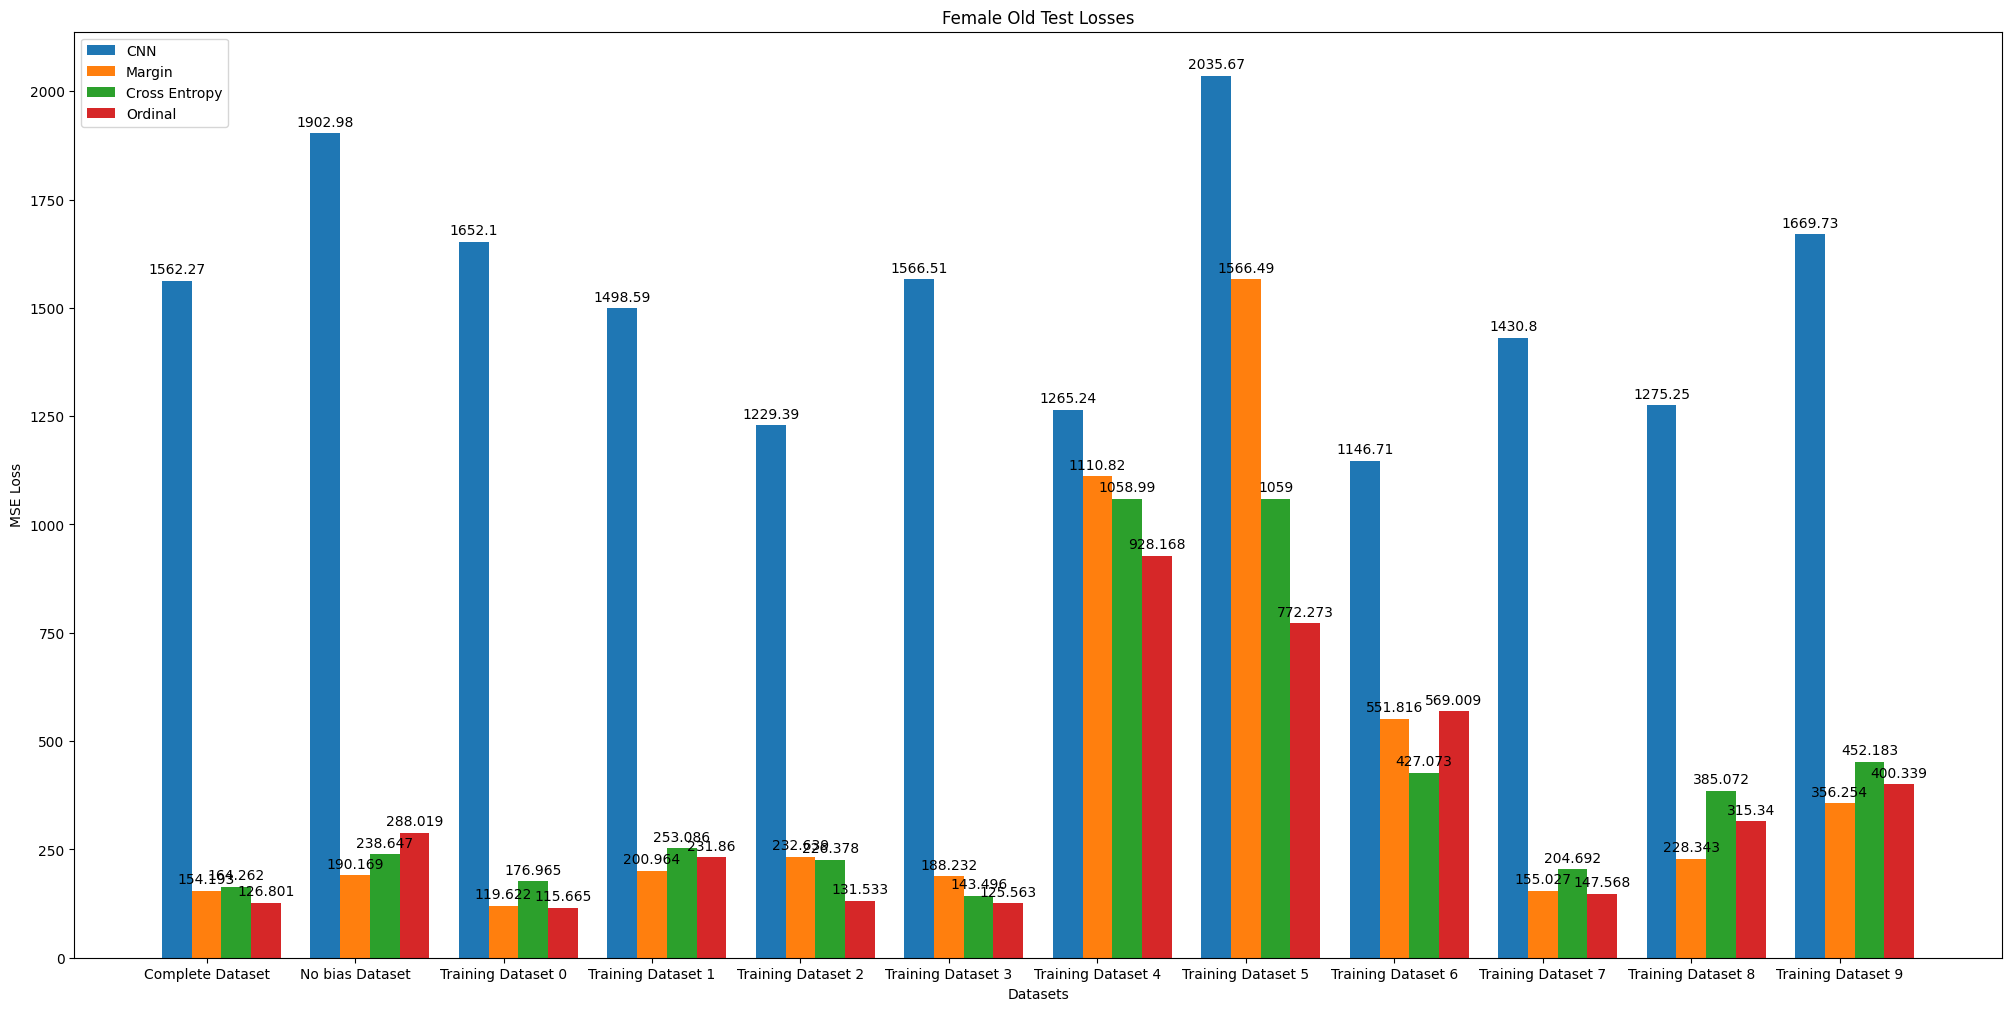

In [101]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
female_old_test_losses = {
    "CNN": grp_wise_losses["f old"],
    "Margin": fs_grp_wise_losses["f old"],
    "Cross Entropy": fs_ce_grp_wise_losses["f old"],
    "Ordinal": fs_ord_grp_wise_losses["f old"]
}

bar_plot(datasets, female_old_test_losses, 'Datasets', "MSE Loss", "Female Old Test Losses", "female_old_losses")

In [90]:
# average statistirus = RandomUnderSampler(random_state = 3407)
# high_train_arr, high_train_tar = rus.fit_resample(high_train_arr, high_train_tar)
# low_train_arr, low_train_tar = rus.fit_resample(low_train_arr, low_train_tar)cs
## Test Losses
cnn_tst_loss = np.mean(tst_losses[2:])
fs_tst_loss = np.mean(fs_tst_losses[2:])
fs_ce_tst_loss = np.mean(fs_ce_tst_losses[2:])
fs_ord_tst_loss = np.mean(fs_ord_tst_losses[2:])

## Group Test Loss
cnn_grp_tst_loss = np.mean(grp_tst_losses[2:])
fs_grp_tst_loss = np.mean(fs_grp_tst_losses[2:])
fs_ce_grp_tst_loss = np.mean(fs_ce_grp_tst_losses[2:])
fs_ord_grp_tst_loss = np.mean(fs_ce_grp_tst_losses[2:])

grp_wise_loss = {"m yng":0, "m old": 0, "f yng": 0, "f old": 0}
fs_grp_wise_loss = {"m yng":0, "m old": 0, "f yng": 0, "f old": 0}
fs_ce_grp_wise_loss = {"m yng":0, "m old": 0, "f yng": 0, "f old": 0}
fs_ord_grp_wise_loss = {"m yng":0, "m old": 0, "f yng": 0, "f old": 0}

## Grp_wise_tst_loss
for grp in grp_wise_loss.keys():
    grp_wise_loss[grp] = np.mean(grp_wise_losses[grp][2:])
    fs_grp_wise_loss[grp] = np.mean(fs_grp_wise_losses[grp][2:])
    fs_ce_grp_wise_loss[grp] = np.mean(fs_ce_grp_wise_losses[grp][2:])
    fs_ord_grp_wise_loss[grp] = np.mean(fs_ord_grp_wise_losses[grp][2:])

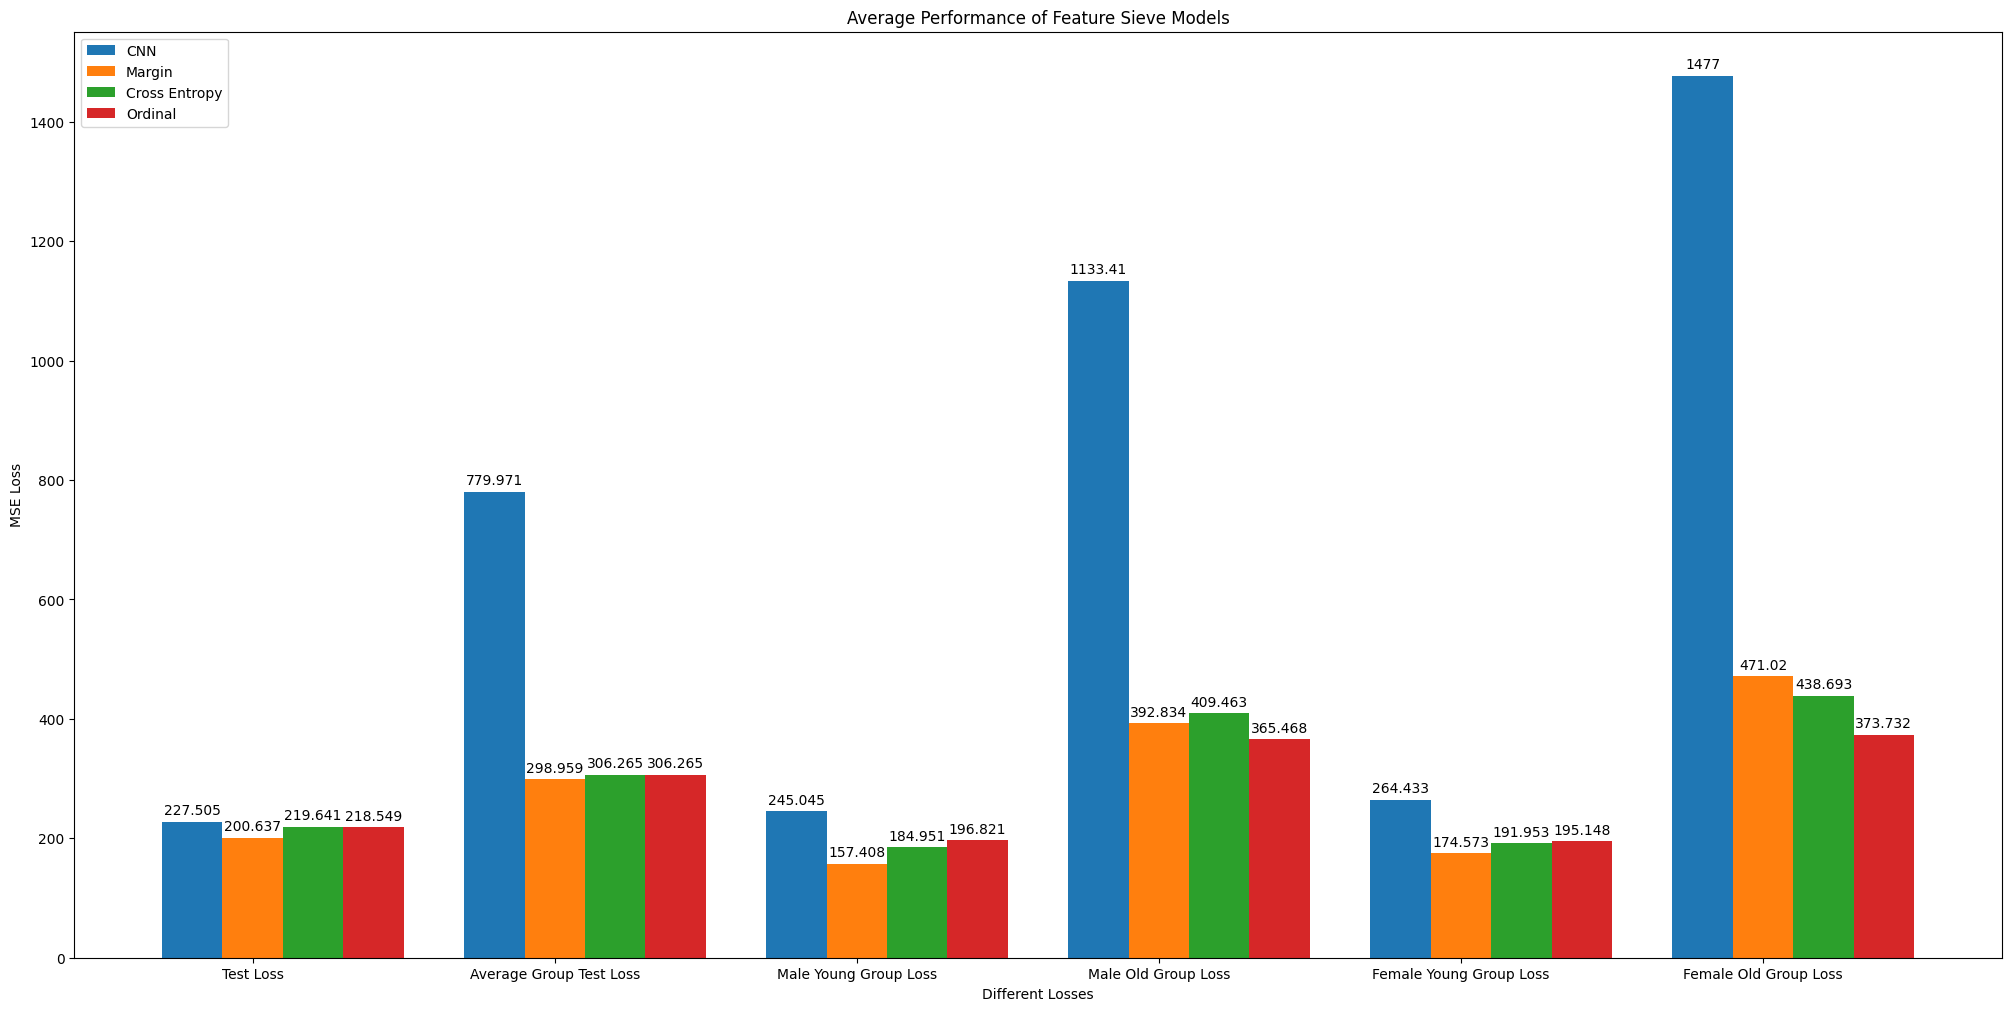

In [91]:
# plotting the average statistics
losses = ["Test Loss", "Average Group Test Loss", "Male Young Group Loss", "Male Old Group Loss", "Female Young Group Loss", "Female Old Group Loss"]
model_losses = {
    "CNN": [cnn_tst_loss, cnn_grp_tst_loss, grp_wise_loss["m yng"], grp_wise_loss["m old"], grp_wise_loss['f yng'], grp_wise_loss['f old']], 
    "Margin": [fs_tst_loss, fs_grp_tst_loss, fs_grp_wise_loss['m yng'], fs_grp_wise_loss['m old'], fs_grp_wise_loss['f yng'], fs_grp_wise_loss['f old']], 
    "Cross Entropy": [fs_ce_tst_loss, fs_ce_grp_tst_loss, fs_ce_grp_wise_loss['m yng'], fs_ce_grp_wise_loss['m old'], fs_ce_grp_wise_loss['f yng'], fs_ce_grp_wise_loss['f old']], 
    "Ordinal": [fs_ord_tst_loss, fs_ord_grp_tst_loss, fs_ord_grp_wise_loss['m yng'], fs_ord_grp_wise_loss['m old'], fs_ord_grp_wise_loss['f yng'], fs_ord_grp_wise_loss['f old']]
}
bar_plot(losses, model_losses, "Different Losses", "MSE Loss", "Average Performance of Feature Sieve Models", "avg_fs_models_unbiased")

#### Tabular form of the results
##### Test Group Losses

In [ ]:
datasets =  ["Complete Dataset", "No bias Dataset"] + [f"Training Dataset {i}" for i in range(10)]
datasets_df = pd.DataFrame({"Dataset": datasets})

male_yng_test_losses_df = pd.DataFrame(male_yng_test_losses)
male_yng_test_losses_df = pd.concat([datasets_df, male_yng_test_losses_df], axis = 1).set_index("Dataset")
male_yng_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_yng_test_losses.csv")
male_yng_test_losses_df

In [ ]:
male_old_test_losses_df = pd.DataFrame(male_old_test_losses)
male_old_test_losses_df = pd.concat([datasets_df, male_old_test_losses_df], axis = 1).set_index("Dataset")
male_old_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_old_test_losses.csv")
male_old_test_losses_df

In [ ]:
female_yng_test_losses_df = pd.DataFrame(female_yng_test_losses)
female_yng_test_losses_df = pd.concat([datasets_df, female_yng_test_losses_df], axis = 1).set_index("Dataset")
female_yng_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}female_yng_test_losses.csv")
female_yng_test_losses_df

In [ ]:
female_old_test_losses_df = pd.DataFrame(female_old_test_losses)
female_old_test_losses_df = pd.concat([datasets_df, female_old_test_losses_df], axis = 1).set_index("Dataset")
female_old_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_old_test_losses.csv")
female_old_test_losses_df

##### Train Group Losses

In [ ]:
male_yng_train_losses = {
    "CNN": grp_wise_losses_t["m yng"],
    "Margin": fs_grp_wise_losses_t["m yng"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["m yng"],
    "Ordinal": fs_ord_grp_wise_losses_t["m yng"]
}

male_yng_train_losses_df = pd.DataFrame(male_yng_train_losses)
male_yng_train_losses_df = pd.concat([datasets_df, male_yng_train_losses_df], axis = 1).set_index("Dataset")
male_yng_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_yng_train_losses.csv")
male_yng_train_losses_df

In [ ]:
male_old_train_losses = {
    "CNN": grp_wise_losses_t["m old"],
    "Margin": fs_grp_wise_losses_t["m old"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["m old"],
    "Ordinal": fs_ord_grp_wise_losses_t["m old"]
}

male_old_train_losses_df = pd.DataFrame(male_old_train_losses)
male_old_train_losses_df = pd.concat([datasets_df, male_old_train_losses_df], axis = 1).set_index("Dataset")
male_old_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/male_old_train_losses.csv")
male_old_train_losses_df

In [ ]:
female_yng_train_losses = {
    "CNN": grp_wise_losses_t["f yng"],
    "Margin": fs_grp_wise_losses_t["f yng"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["f yng"],
    "Ordinal": fs_ord_grp_wise_losses_t["f yng"]
}

female_yng_train_losses_df = pd.DataFrame(female_yng_train_losses)
female_yng_train_losses_df = pd.concat([datasets_df, female_yng_train_losses_df], axis = 1).set_index("Dataset")
female_yng_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_yng_train_losses.csv")
female_yng_train_losses_df

In [ ]:
female_old_train_losses = {
    "CNN": grp_wise_losses_t["f old"],
    "Margin": fs_grp_wise_losses_t["f old"],
    "Cross Entropy": fs_ce_grp_wise_losses_t["f old"],
    "Ordinal": fs_ord_grp_wise_losses_t["f old"]
}

female_old_train_losses_df = pd.DataFrame(female_old_train_losses)
female_old_train_losses_df = pd.concat([datasets_df, female_old_train_losses_df], axis = 1).set_index("Dataset")
female_old_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/female_old_train_losses.csv")
female_old_train_losses_df

In [ ]:
grp_train_losses_df = {
    "CNN": grp_tst_losses_t,
    "Margin": fs_grp_tst_losses_t,
    "Cross Entropy": fs_ce_grp_tst_losses_t,
    "Ordinal": fs_ord_grp_tst_losses_t
}

grp_train_losses_df = pd.DataFrame(grp_train_losses_df)
grp_train_losses_df = pd.concat([datasets_df, grp_train_losses_df], axis = 1).set_index("Dataset")
grp_train_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/grp_train_losses.csv")
grp_train_losses_df

In [ ]:
grp_test_losses_df = {
    "CNN": grp_tst_losses,
    "Margin": fs_grp_tst_losses,
    "Cross Entropy": fs_ce_grp_tst_losses,
    "Ordinal": fs_ord_grp_tst_losses
}

grp_test_losses_df = pd.DataFrame(grp_test_losses_df)
grp_test_losses_df = pd.concat([datasets_df, grp_test_losses_df], axis = 1).set_index("Dataset")
grp_test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/grp_test_losses.csv")
grp_test_losses_df

In [ ]:
test_losses_df = {
    "CNN": tst_losses,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_tst_losses,
    "Ordinal": fs_ord_tst_losses
}

test_losses_df = pd.DataFrame(test_losses_df)
test_losses_df = pd.concat([datasets_df, test_losses_df], axis = 1).set_index("Dataset")
test_losses_df.to_csv(f"./Outputs/Losses/SEED_{SEED}/test_losses.csv")
test_losses_df

In [ ]:
grp = pd.read_csv('./Outputs/Losses/SEED_3407/grp_test_losses.csv')
grp

In [ ]:
grp['Margin'] = (grp['Margin'] - grp['CNN']) / grp['CNN'] * 100
grp['Cross Entropy'] = (grp['Cross Entropy'] - grp['CNN']) / grp['CNN'] * 100
grp['Ordinal'] = (grp['Ordinal'] - grp['CNN']) / grp['CNN'] * 100
grp